# K-Fold CV for Boosting Methods Using SKLearn 

In [1]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random
import statistics

In [2]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [4]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


In [5]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [6]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [7]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'IQR', 'Var', 'Rmean_Var', 'Trans_AppEn', 'Rhythm',
       'Subject'],
      dtype='object')


# CatBoosting

In [8]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


0:	learn: 0.6162917	total: 166ms	remaining: 17.3s
1:	learn: 0.5535464	total: 172ms	remaining: 8.88s
2:	learn: 0.5006996	total: 178ms	remaining: 6.05s
3:	learn: 0.4556475	total: 183ms	remaining: 4.62s
4:	learn: 0.4168439	total: 187ms	remaining: 3.75s
5:	learn: 0.3841751	total: 192ms	remaining: 3.16s
6:	learn: 0.3552587	total: 196ms	remaining: 2.74s
7:	learn: 0.3299414	total: 200ms	remaining: 2.43s
8:	learn: 0.3079266	total: 205ms	remaining: 2.18s
9:	learn: 0.2879754	total: 209ms	remaining: 1.99s
10:	learn: 0.2707337	total: 214ms	remaining: 1.82s
11:	learn: 0.2548097	total: 218ms	remaining: 1.69s
12:	learn: 0.2408188	total: 223ms	remaining: 1.58s
13:	learn: 0.2287592	total: 227ms	remaining: 1.48s
14:	learn: 0.2179643	total: 232ms	remaining: 1.39s
15:	learn: 0.2082531	total: 236ms	remaining: 1.31s
16:	learn: 0.1997885	total: 240ms	remaining: 1.24s
17:	learn: 0.1915331	total: 245ms	remaining: 1.18s
18:	learn: 0.1844304	total: 249ms	remaining: 1.13s
19:	learn: 0.1784240	total: 253ms	remaini

90:	learn: 0.0992951	total: 383ms	remaining: 58.9ms
91:	learn: 0.0989045	total: 387ms	remaining: 54.7ms
92:	learn: 0.0987382	total: 391ms	remaining: 50.5ms
93:	learn: 0.0985214	total: 396ms	remaining: 46.3ms
94:	learn: 0.0984156	total: 400ms	remaining: 42.1ms
95:	learn: 0.0982393	total: 404ms	remaining: 37.8ms
96:	learn: 0.0978714	total: 408ms	remaining: 33.6ms
97:	learn: 0.0976415	total: 412ms	remaining: 29.4ms
98:	learn: 0.0973518	total: 416ms	remaining: 25.2ms
99:	learn: 0.0968758	total: 420ms	remaining: 21ms
100:	learn: 0.0966331	total: 424ms	remaining: 16.8ms
101:	learn: 0.0964536	total: 428ms	remaining: 12.6ms
102:	learn: 0.0963885	total: 432ms	remaining: 8.39ms
103:	learn: 0.0962278	total: 436ms	remaining: 4.19ms
104:	learn: 0.0958966	total: 440ms	remaining: 0us
0:	learn: 0.6153399	total: 6.16ms	remaining: 641ms
1:	learn: 0.5497499	total: 11.3ms	remaining: 582ms
2:	learn: 0.4961490	total: 15.7ms	remaining: 535ms
3:	learn: 0.4504521	total: 20.1ms	remaining: 508ms
4:	learn: 0.4117

49:	learn: 0.0974407	total: 270ms	remaining: 297ms
50:	learn: 0.0970147	total: 274ms	remaining: 290ms
51:	learn: 0.0964683	total: 279ms	remaining: 284ms
52:	learn: 0.0960188	total: 283ms	remaining: 278ms
53:	learn: 0.0957866	total: 288ms	remaining: 272ms
54:	learn: 0.0954120	total: 292ms	remaining: 266ms
55:	learn: 0.0949418	total: 297ms	remaining: 260ms
56:	learn: 0.0944642	total: 301ms	remaining: 254ms
57:	learn: 0.0941107	total: 305ms	remaining: 247ms
58:	learn: 0.0936472	total: 310ms	remaining: 242ms
59:	learn: 0.0932565	total: 314ms	remaining: 235ms
60:	learn: 0.0929410	total: 318ms	remaining: 229ms
61:	learn: 0.0927789	total: 322ms	remaining: 223ms
62:	learn: 0.0923922	total: 327ms	remaining: 218ms
63:	learn: 0.0919482	total: 331ms	remaining: 212ms
64:	learn: 0.0914821	total: 335ms	remaining: 206ms
65:	learn: 0.0913122	total: 339ms	remaining: 200ms
66:	learn: 0.0908641	total: 343ms	remaining: 195ms
67:	learn: 0.0904341	total: 347ms	remaining: 189ms
68:	learn: 0.0902317	total: 351

24:	learn: 0.1504995	total: 138ms	remaining: 460ms
25:	learn: 0.1464379	total: 144ms	remaining: 455ms
26:	learn: 0.1434236	total: 150ms	remaining: 450ms
27:	learn: 0.1408430	total: 156ms	remaining: 445ms
28:	learn: 0.1380211	total: 161ms	remaining: 440ms
29:	learn: 0.1355128	total: 167ms	remaining: 434ms
30:	learn: 0.1329558	total: 172ms	remaining: 428ms
31:	learn: 0.1311033	total: 178ms	remaining: 422ms
32:	learn: 0.1288074	total: 183ms	remaining: 417ms
33:	learn: 0.1273028	total: 189ms	remaining: 412ms
34:	learn: 0.1257127	total: 194ms	remaining: 406ms
35:	learn: 0.1240056	total: 200ms	remaining: 399ms
36:	learn: 0.1225069	total: 205ms	remaining: 394ms
37:	learn: 0.1213419	total: 211ms	remaining: 389ms
38:	learn: 0.1197454	total: 217ms	remaining: 383ms
39:	learn: 0.1184298	total: 222ms	remaining: 378ms
40:	learn: 0.1175007	total: 228ms	remaining: 373ms
41:	learn: 0.1164559	total: 234ms	remaining: 367ms
42:	learn: 0.1156348	total: 239ms	remaining: 362ms
43:	learn: 0.1145209	total: 245

99:	learn: 0.0940929	total: 562ms	remaining: 44.9ms
100:	learn: 0.0939939	total: 567ms	remaining: 39.3ms
101:	learn: 0.0938652	total: 573ms	remaining: 33.7ms
102:	learn: 0.0936141	total: 579ms	remaining: 28.1ms
103:	learn: 0.0933350	total: 584ms	remaining: 22.5ms
104:	learn: 0.0929942	total: 590ms	remaining: 16.8ms
105:	learn: 0.0928306	total: 595ms	remaining: 11.2ms
106:	learn: 0.0925858	total: 601ms	remaining: 5.61ms
107:	learn: 0.0925063	total: 606ms	remaining: 0us
0:	learn: 0.6153048	total: 5.98ms	remaining: 640ms
1:	learn: 0.5499151	total: 11.6ms	remaining: 617ms
2:	learn: 0.4966343	total: 17.2ms	remaining: 603ms
3:	learn: 0.4505605	total: 22.7ms	remaining: 589ms
4:	learn: 0.4111111	total: 28.5ms	remaining: 587ms
5:	learn: 0.3773832	total: 34.3ms	remaining: 583ms
6:	learn: 0.3486990	total: 39.7ms	remaining: 574ms
7:	learn: 0.3228978	total: 45.4ms	remaining: 567ms
8:	learn: 0.3005682	total: 51.1ms	remaining: 562ms
9:	learn: 0.2805268	total: 56.8ms	remaining: 556ms
10:	learn: 0.2625

66:	learn: 0.0879806	total: 384ms	remaining: 235ms
67:	learn: 0.0876801	total: 389ms	remaining: 229ms
68:	learn: 0.0872729	total: 395ms	remaining: 223ms
69:	learn: 0.0870631	total: 401ms	remaining: 217ms
70:	learn: 0.0869147	total: 406ms	remaining: 211ms
71:	learn: 0.0866813	total: 411ms	remaining: 206ms
72:	learn: 0.0865649	total: 416ms	remaining: 199ms
73:	learn: 0.0864272	total: 421ms	remaining: 194ms
74:	learn: 0.0862321	total: 426ms	remaining: 188ms
75:	learn: 0.0860070	total: 432ms	remaining: 182ms
76:	learn: 0.0858351	total: 437ms	remaining: 176ms
77:	learn: 0.0854142	total: 442ms	remaining: 170ms
78:	learn: 0.0849929	total: 448ms	remaining: 164ms
79:	learn: 0.0847268	total: 453ms	remaining: 158ms
80:	learn: 0.0844877	total: 458ms	remaining: 153ms
81:	learn: 0.0841517	total: 464ms	remaining: 147ms
82:	learn: 0.0838481	total: 469ms	remaining: 141ms
83:	learn: 0.0834392	total: 474ms	remaining: 136ms
84:	learn: 0.0832128	total: 480ms	remaining: 130ms
85:	learn: 0.0829995	total: 485

33:	learn: 0.1273028	total: 191ms	remaining: 410ms
34:	learn: 0.1257127	total: 197ms	remaining: 404ms
35:	learn: 0.1240056	total: 203ms	remaining: 400ms
36:	learn: 0.1225069	total: 209ms	remaining: 395ms
37:	learn: 0.1213419	total: 214ms	remaining: 389ms
38:	learn: 0.1197454	total: 220ms	remaining: 383ms
39:	learn: 0.1184298	total: 225ms	remaining: 377ms
40:	learn: 0.1175007	total: 231ms	remaining: 371ms
41:	learn: 0.1164559	total: 236ms	remaining: 365ms
42:	learn: 0.1156348	total: 242ms	remaining: 360ms
43:	learn: 0.1145209	total: 247ms	remaining: 354ms
44:	learn: 0.1136666	total: 253ms	remaining: 348ms
45:	learn: 0.1129119	total: 258ms	remaining: 342ms
46:	learn: 0.1121069	total: 264ms	remaining: 336ms
47:	learn: 0.1113353	total: 269ms	remaining: 331ms
48:	learn: 0.1103807	total: 274ms	remaining: 325ms
49:	learn: 0.1096969	total: 280ms	remaining: 319ms
50:	learn: 0.1090986	total: 285ms	remaining: 313ms
51:	learn: 0.1085939	total: 291ms	remaining: 308ms
52:	learn: 0.1079775	total: 297

1:	learn: 0.5499151	total: 14.4ms	remaining: 755ms
2:	learn: 0.4966343	total: 20.6ms	remaining: 713ms
3:	learn: 0.4505605	total: 26.4ms	remaining: 679ms
4:	learn: 0.4111111	total: 31.9ms	remaining: 651ms
5:	learn: 0.3773832	total: 37.3ms	remaining: 628ms
6:	learn: 0.3486990	total: 43.1ms	remaining: 616ms
7:	learn: 0.3228978	total: 48.9ms	remaining: 605ms
8:	learn: 0.3005682	total: 54.5ms	remaining: 593ms
9:	learn: 0.2805268	total: 60.4ms	remaining: 586ms
10:	learn: 0.2625377	total: 66.1ms	remaining: 577ms
11:	learn: 0.2470284	total: 72.2ms	remaining: 571ms
12:	learn: 0.2329033	total: 78.2ms	remaining: 565ms
13:	learn: 0.2206051	total: 83.5ms	remaining: 555ms
14:	learn: 0.2096913	total: 89.1ms	remaining: 546ms
15:	learn: 0.1998892	total: 94.9ms	remaining: 540ms
16:	learn: 0.1908952	total: 101ms	remaining: 532ms
17:	learn: 0.1835297	total: 106ms	remaining: 524ms
18:	learn: 0.1760408	total: 111ms	remaining: 516ms
19:	learn: 0.1694021	total: 117ms	remaining: 509ms
20:	learn: 0.1636190	tota

83:	learn: 0.0834392	total: 468ms	remaining: 128ms
84:	learn: 0.0832128	total: 474ms	remaining: 123ms
85:	learn: 0.0829995	total: 480ms	remaining: 117ms
86:	learn: 0.0827827	total: 486ms	remaining: 112ms
87:	learn: 0.0824829	total: 491ms	remaining: 106ms
88:	learn: 0.0822805	total: 497ms	remaining: 101ms
89:	learn: 0.0819846	total: 502ms	remaining: 94.9ms
90:	learn: 0.0816453	total: 508ms	remaining: 89.4ms
91:	learn: 0.0815482	total: 513ms	remaining: 83.7ms
92:	learn: 0.0813685	total: 519ms	remaining: 78.1ms
93:	learn: 0.0811186	total: 524ms	remaining: 72.5ms
94:	learn: 0.0809110	total: 529ms	remaining: 66.9ms
95:	learn: 0.0806823	total: 535ms	remaining: 61.3ms
96:	learn: 0.0805973	total: 540ms	remaining: 55.6ms
97:	learn: 0.0803824	total: 545ms	remaining: 50.1ms
98:	learn: 0.0802754	total: 550ms	remaining: 44.4ms
99:	learn: 0.0800360	total: 555ms	remaining: 38.9ms
100:	learn: 0.0798919	total: 561ms	remaining: 33.3ms
101:	learn: 0.0796929	total: 566ms	remaining: 27.8ms
102:	learn: 0.07

66:	learn: 0.1036510	total: 288ms	remaining: 163ms
67:	learn: 0.1032936	total: 293ms	remaining: 159ms
68:	learn: 0.1031176	total: 297ms	remaining: 155ms
69:	learn: 0.1027290	total: 302ms	remaining: 151ms
70:	learn: 0.1024667	total: 306ms	remaining: 147ms
71:	learn: 0.1021140	total: 310ms	remaining: 142ms
72:	learn: 0.1019505	total: 314ms	remaining: 138ms
73:	learn: 0.1016648	total: 319ms	remaining: 133ms
74:	learn: 0.1014403	total: 323ms	remaining: 129ms
75:	learn: 0.1009964	total: 327ms	remaining: 125ms
76:	learn: 0.1007531	total: 331ms	remaining: 121ms
77:	learn: 0.1004509	total: 336ms	remaining: 116ms
78:	learn: 0.1000188	total: 340ms	remaining: 112ms
79:	learn: 0.0998176	total: 344ms	remaining: 108ms
80:	learn: 0.0994318	total: 349ms	remaining: 103ms
81:	learn: 0.0991871	total: 353ms	remaining: 99ms
82:	learn: 0.0988775	total: 357ms	remaining: 94.7ms
83:	learn: 0.0986149	total: 362ms	remaining: 90.4ms
84:	learn: 0.0983956	total: 366ms	remaining: 86ms
85:	learn: 0.0982827	total: 369

54:	learn: 0.1060140	total: 242ms	remaining: 220ms
55:	learn: 0.1054712	total: 246ms	remaining: 215ms
56:	learn: 0.1049242	total: 250ms	remaining: 211ms
57:	learn: 0.1044702	total: 255ms	remaining: 207ms
58:	learn: 0.1039976	total: 259ms	remaining: 202ms
59:	learn: 0.1035323	total: 263ms	remaining: 198ms
60:	learn: 0.1031223	total: 268ms	remaining: 193ms
61:	learn: 0.1024291	total: 272ms	remaining: 188ms
62:	learn: 0.1021210	total: 275ms	remaining: 184ms
63:	learn: 0.1018297	total: 280ms	remaining: 179ms
64:	learn: 0.1014352	total: 284ms	remaining: 175ms
65:	learn: 0.1012370	total: 287ms	remaining: 170ms
66:	learn: 0.1009118	total: 292ms	remaining: 165ms
67:	learn: 0.1005934	total: 296ms	remaining: 161ms
68:	learn: 0.1004270	total: 300ms	remaining: 156ms
69:	learn: 0.1000626	total: 304ms	remaining: 152ms
70:	learn: 0.0998162	total: 308ms	remaining: 148ms
71:	learn: 0.0996151	total: 312ms	remaining: 143ms
72:	learn: 0.0994601	total: 316ms	remaining: 139ms
73:	learn: 0.0991574	total: 320

43:	learn: 0.1352585	total: 192ms	remaining: 267ms
44:	learn: 0.1343570	total: 198ms	remaining: 264ms
45:	learn: 0.1336500	total: 202ms	remaining: 259ms
46:	learn: 0.1327652	total: 207ms	remaining: 255ms
47:	learn: 0.1318121	total: 211ms	remaining: 251ms
48:	learn: 0.1311281	total: 216ms	remaining: 247ms
49:	learn: 0.1306030	total: 220ms	remaining: 242ms
50:	learn: 0.1298864	total: 224ms	remaining: 237ms
51:	learn: 0.1291153	total: 228ms	remaining: 233ms
52:	learn: 0.1286487	total: 232ms	remaining: 228ms
53:	learn: 0.1280326	total: 236ms	remaining: 223ms
54:	learn: 0.1271604	total: 240ms	remaining: 219ms
55:	learn: 0.1263238	total: 245ms	remaining: 214ms
56:	learn: 0.1258534	total: 249ms	remaining: 210ms
57:	learn: 0.1254008	total: 253ms	remaining: 205ms
58:	learn: 0.1249687	total: 257ms	remaining: 201ms
59:	learn: 0.1245476	total: 262ms	remaining: 196ms
60:	learn: 0.1238155	total: 266ms	remaining: 192ms
61:	learn: 0.1234508	total: 270ms	remaining: 187ms
62:	learn: 0.1230592	total: 274

18:	learn: 0.1879248	total: 84.4ms	remaining: 400ms
19:	learn: 0.1813520	total: 89.4ms	remaining: 398ms
20:	learn: 0.1756353	total: 93.8ms	remaining: 393ms
21:	learn: 0.1705248	total: 98.7ms	remaining: 390ms
22:	learn: 0.1659250	total: 103ms	remaining: 385ms
23:	learn: 0.1613432	total: 107ms	remaining: 380ms
24:	learn: 0.1575852	total: 111ms	remaining: 375ms
25:	learn: 0.1538188	total: 116ms	remaining: 370ms
26:	learn: 0.1507845	total: 120ms	remaining: 365ms
27:	learn: 0.1477030	total: 124ms	remaining: 359ms
28:	learn: 0.1450055	total: 128ms	remaining: 354ms
29:	learn: 0.1421100	total: 132ms	remaining: 349ms
30:	learn: 0.1395983	total: 137ms	remaining: 344ms
31:	learn: 0.1375803	total: 141ms	remaining: 338ms
32:	learn: 0.1355675	total: 145ms	remaining: 333ms
33:	learn: 0.1335889	total: 149ms	remaining: 328ms
34:	learn: 0.1318531	total: 153ms	remaining: 324ms
35:	learn: 0.1301301	total: 157ms	remaining: 319ms
36:	learn: 0.1284903	total: 161ms	remaining: 314ms
37:	learn: 0.1272053	total:

0:	learn: 0.6124168	total: 4.77ms	remaining: 516ms
1:	learn: 0.5461328	total: 9.54ms	remaining: 510ms
2:	learn: 0.4925146	total: 13.9ms	remaining: 491ms
3:	learn: 0.4466096	total: 18.2ms	remaining: 477ms
4:	learn: 0.4068814	total: 22.4ms	remaining: 466ms
5:	learn: 0.3723657	total: 26.8ms	remaining: 460ms
6:	learn: 0.3418999	total: 31.5ms	remaining: 459ms
7:	learn: 0.3157820	total: 35.8ms	remaining: 452ms
8:	learn: 0.2930119	total: 40ms	remaining: 444ms
9:	learn: 0.2729358	total: 44.3ms	remaining: 439ms
10:	learn: 0.2549595	total: 48.8ms	remaining: 434ms
11:	learn: 0.2386959	total: 52.9ms	remaining: 428ms
12:	learn: 0.2245754	total: 57.3ms	remaining: 423ms
13:	learn: 0.2124853	total: 61.5ms	remaining: 417ms
14:	learn: 0.2010819	total: 66.1ms	remaining: 414ms
15:	learn: 0.1909218	total: 70.4ms	remaining: 409ms
16:	learn: 0.1818900	total: 74.6ms	remaining: 404ms
17:	learn: 0.1735050	total: 79.1ms	remaining: 400ms
18:	learn: 0.1668635	total: 83.7ms	remaining: 397ms
19:	learn: 0.1601336	tot

91:	learn: 0.1142151	total: 394ms	remaining: 72.9ms
92:	learn: 0.1141024	total: 398ms	remaining: 68.6ms
93:	learn: 0.1138792	total: 403ms	remaining: 64.3ms
94:	learn: 0.1137093	total: 407ms	remaining: 60ms
95:	learn: 0.1134744	total: 412ms	remaining: 55.7ms
96:	learn: 0.1131490	total: 416ms	remaining: 51.4ms
97:	learn: 0.1130102	total: 420ms	remaining: 47.1ms
98:	learn: 0.1126190	total: 424ms	remaining: 42.9ms
99:	learn: 0.1123672	total: 428ms	remaining: 38.6ms
100:	learn: 0.1121459	total: 433ms	remaining: 34.3ms
101:	learn: 0.1120359	total: 437ms	remaining: 30ms
102:	learn: 0.1119117	total: 441ms	remaining: 25.7ms
103:	learn: 0.1117509	total: 445ms	remaining: 21.4ms
104:	learn: 0.1115372	total: 450ms	remaining: 17.1ms
105:	learn: 0.1113328	total: 454ms	remaining: 12.9ms
106:	learn: 0.1110021	total: 459ms	remaining: 8.58ms
107:	learn: 0.1108366	total: 463ms	remaining: 4.29ms
108:	learn: 0.1106594	total: 468ms	remaining: 0us
0:	learn: 0.6161032	total: 9.28ms	remaining: 975ms
1:	learn: 0

57:	learn: 0.1049611	total: 488ms	remaining: 404ms
58:	learn: 0.1044477	total: 498ms	remaining: 397ms
59:	learn: 0.1039609	total: 506ms	remaining: 388ms
60:	learn: 0.1035746	total: 514ms	remaining: 379ms
61:	learn: 0.1032003	total: 522ms	remaining: 370ms
62:	learn: 0.1025328	total: 530ms	remaining: 362ms
63:	learn: 0.1021665	total: 538ms	remaining: 353ms
64:	learn: 0.1019671	total: 546ms	remaining: 345ms
65:	learn: 0.1013366	total: 554ms	remaining: 336ms
66:	learn: 0.1010809	total: 562ms	remaining: 327ms
67:	learn: 0.1008600	total: 570ms	remaining: 319ms
68:	learn: 0.1004792	total: 578ms	remaining: 310ms
69:	learn: 0.1001736	total: 586ms	remaining: 301ms
70:	learn: 0.0999222	total: 594ms	remaining: 293ms
71:	learn: 0.0997466	total: 602ms	remaining: 284ms
72:	learn: 0.0993857	total: 610ms	remaining: 276ms
73:	learn: 0.0991365	total: 618ms	remaining: 267ms
74:	learn: 0.0989752	total: 626ms	remaining: 259ms
75:	learn: 0.0988056	total: 633ms	remaining: 250ms
76:	learn: 0.0982482	total: 641

16:	learn: 0.1792121	total: 145ms	remaining: 761ms
17:	learn: 0.1707304	total: 155ms	remaining: 756ms
18:	learn: 0.1634253	total: 163ms	remaining: 748ms
19:	learn: 0.1571111	total: 172ms	remaining: 740ms
20:	learn: 0.1512209	total: 181ms	remaining: 732ms
21:	learn: 0.1458526	total: 190ms	remaining: 724ms
22:	learn: 0.1410847	total: 198ms	remaining: 714ms
23:	learn: 0.1366904	total: 206ms	remaining: 705ms
24:	learn: 0.1327712	total: 215ms	remaining: 698ms
25:	learn: 0.1291929	total: 224ms	remaining: 689ms
26:	learn: 0.1257505	total: 233ms	remaining: 681ms
27:	learn: 0.1229968	total: 241ms	remaining: 672ms
28:	learn: 0.1201958	total: 249ms	remaining: 662ms
29:	learn: 0.1176899	total: 258ms	remaining: 653ms
30:	learn: 0.1154454	total: 267ms	remaining: 645ms
31:	learn: 0.1132311	total: 275ms	remaining: 636ms
32:	learn: 0.1114590	total: 284ms	remaining: 628ms
33:	learn: 0.1097102	total: 292ms	remaining: 618ms
34:	learn: 0.1083019	total: 301ms	remaining: 610ms
35:	learn: 0.1065332	total: 309

93:	learn: 0.1075258	total: 754ms	remaining: 96.2ms
94:	learn: 0.1073387	total: 762ms	remaining: 88.2ms
95:	learn: 0.1070307	total: 770ms	remaining: 80.2ms
96:	learn: 0.1069239	total: 778ms	remaining: 72.1ms
97:	learn: 0.1067503	total: 785ms	remaining: 64.1ms
98:	learn: 0.1066388	total: 793ms	remaining: 56.1ms
99:	learn: 0.1065425	total: 800ms	remaining: 48ms
100:	learn: 0.1062492	total: 808ms	remaining: 40ms
101:	learn: 0.1060299	total: 815ms	remaining: 32ms
102:	learn: 0.1058041	total: 823ms	remaining: 24ms
103:	learn: 0.1056405	total: 830ms	remaining: 16ms
104:	learn: 0.1053715	total: 838ms	remaining: 7.98ms
105:	learn: 0.1052341	total: 846ms	remaining: 0us
0:	learn: 0.6161032	total: 8.65ms	remaining: 900ms
1:	learn: 0.5543049	total: 16.6ms	remaining: 857ms
2:	learn: 0.5020476	total: 24.8ms	remaining: 843ms
3:	learn: 0.4566724	total: 32.9ms	remaining: 831ms
4:	learn: 0.4169424	total: 41.9ms	remaining: 838ms
5:	learn: 0.3826707	total: 50.2ms	remaining: 828ms
6:	learn: 0.3539312	total

55:	learn: 0.1061252	total: 458ms	remaining: 400ms
56:	learn: 0.1056446	total: 466ms	remaining: 393ms
57:	learn: 0.1049611	total: 474ms	remaining: 384ms
58:	learn: 0.1044477	total: 483ms	remaining: 376ms
59:	learn: 0.1039609	total: 490ms	remaining: 368ms
60:	learn: 0.1035746	total: 498ms	remaining: 359ms
61:	learn: 0.1032003	total: 506ms	remaining: 351ms
62:	learn: 0.1025328	total: 514ms	remaining: 342ms
63:	learn: 0.1021665	total: 521ms	remaining: 334ms
64:	learn: 0.1019671	total: 529ms	remaining: 325ms
65:	learn: 0.1013366	total: 537ms	remaining: 317ms
66:	learn: 0.1010809	total: 544ms	remaining: 309ms
67:	learn: 0.1008600	total: 552ms	remaining: 300ms
68:	learn: 0.1004792	total: 560ms	remaining: 292ms
69:	learn: 0.1001736	total: 568ms	remaining: 284ms
70:	learn: 0.0999222	total: 575ms	remaining: 275ms
71:	learn: 0.0997466	total: 583ms	remaining: 267ms
72:	learn: 0.0993857	total: 591ms	remaining: 259ms
73:	learn: 0.0991365	total: 599ms	remaining: 251ms
74:	learn: 0.0989752	total: 606

23:	learn: 0.1366904	total: 196ms	remaining: 663ms
24:	learn: 0.1327712	total: 205ms	remaining: 657ms
25:	learn: 0.1291929	total: 214ms	remaining: 649ms
26:	learn: 0.1257505	total: 222ms	remaining: 641ms
27:	learn: 0.1229968	total: 230ms	remaining: 632ms
28:	learn: 0.1201958	total: 237ms	remaining: 622ms
29:	learn: 0.1176899	total: 246ms	remaining: 614ms
30:	learn: 0.1154454	total: 253ms	remaining: 605ms
31:	learn: 0.1132311	total: 261ms	remaining: 596ms
32:	learn: 0.1114590	total: 269ms	remaining: 588ms
33:	learn: 0.1097102	total: 277ms	remaining: 579ms
34:	learn: 0.1083019	total: 286ms	remaining: 571ms
35:	learn: 0.1065332	total: 294ms	remaining: 563ms
36:	learn: 0.1051206	total: 302ms	remaining: 555ms
37:	learn: 0.1035467	total: 310ms	remaining: 546ms
38:	learn: 0.1024264	total: 318ms	remaining: 538ms
39:	learn: 0.1012977	total: 326ms	remaining: 530ms
40:	learn: 0.1002486	total: 334ms	remaining: 522ms
41:	learn: 0.0992029	total: 342ms	remaining: 513ms
42:	learn: 0.0984461	total: 350

88:	learn: 0.1087411	total: 783ms	remaining: 141ms
89:	learn: 0.1085784	total: 791ms	remaining: 132ms
90:	learn: 0.1082732	total: 799ms	remaining: 123ms
91:	learn: 0.1081549	total: 807ms	remaining: 114ms
92:	learn: 0.1077799	total: 815ms	remaining: 105ms
93:	learn: 0.1075258	total: 823ms	remaining: 96.3ms
94:	learn: 0.1073387	total: 831ms	remaining: 87.5ms
95:	learn: 0.1070307	total: 839ms	remaining: 78.7ms
96:	learn: 0.1069239	total: 847ms	remaining: 69.9ms
97:	learn: 0.1067503	total: 855ms	remaining: 61.1ms
98:	learn: 0.1066388	total: 862ms	remaining: 52.3ms
99:	learn: 0.1065425	total: 870ms	remaining: 43.5ms
100:	learn: 0.1062492	total: 878ms	remaining: 34.8ms
101:	learn: 0.1060299	total: 886ms	remaining: 26.1ms
102:	learn: 0.1058041	total: 894ms	remaining: 17.4ms
103:	learn: 0.1056405	total: 902ms	remaining: 8.68ms
104:	learn: 0.1053715	total: 911ms	remaining: 0us
0:	learn: 0.6160731	total: 6.73ms	remaining: 706ms
1:	learn: 0.5528179	total: 11.7ms	remaining: 611ms
2:	learn: 0.50065

50:	learn: 0.1120150	total: 282ms	remaining: 305ms
51:	learn: 0.1112270	total: 288ms	remaining: 299ms
52:	learn: 0.1104470	total: 294ms	remaining: 294ms
53:	learn: 0.1099014	total: 300ms	remaining: 289ms
54:	learn: 0.1094197	total: 305ms	remaining: 283ms
55:	learn: 0.1089373	total: 310ms	remaining: 277ms
56:	learn: 0.1081750	total: 315ms	remaining: 271ms
57:	learn: 0.1075129	total: 321ms	remaining: 266ms
58:	learn: 0.1072725	total: 326ms	remaining: 260ms
59:	learn: 0.1069200	total: 331ms	remaining: 254ms
60:	learn: 0.1063027	total: 337ms	remaining: 248ms
61:	learn: 0.1059192	total: 342ms	remaining: 243ms
62:	learn: 0.1054980	total: 347ms	remaining: 237ms
63:	learn: 0.1052069	total: 353ms	remaining: 231ms
64:	learn: 0.1048997	total: 358ms	remaining: 226ms
65:	learn: 0.1043731	total: 364ms	remaining: 220ms
66:	learn: 0.1038518	total: 369ms	remaining: 215ms
67:	learn: 0.1034382	total: 374ms	remaining: 209ms
68:	learn: 0.1031087	total: 379ms	remaining: 203ms
69:	learn: 0.1026402	total: 385

18:	learn: 0.1642466	total: 109ms	remaining: 497ms
19:	learn: 0.1581338	total: 114ms	remaining: 491ms
20:	learn: 0.1523170	total: 121ms	remaining: 489ms
21:	learn: 0.1471504	total: 127ms	remaining: 484ms
22:	learn: 0.1423620	total: 132ms	remaining: 477ms
23:	learn: 0.1380650	total: 138ms	remaining: 471ms
24:	learn: 0.1340821	total: 143ms	remaining: 464ms
25:	learn: 0.1301946	total: 149ms	remaining: 458ms
26:	learn: 0.1271458	total: 154ms	remaining: 451ms
27:	learn: 0.1243787	total: 160ms	remaining: 445ms
28:	learn: 0.1215248	total: 166ms	remaining: 440ms
29:	learn: 0.1190106	total: 171ms	remaining: 434ms
30:	learn: 0.1167190	total: 177ms	remaining: 428ms
31:	learn: 0.1147053	total: 182ms	remaining: 422ms
32:	learn: 0.1130140	total: 188ms	remaining: 415ms
33:	learn: 0.1114187	total: 193ms	remaining: 409ms
34:	learn: 0.1097141	total: 199ms	remaining: 404ms
35:	learn: 0.1083579	total: 205ms	remaining: 399ms
36:	learn: 0.1070473	total: 211ms	remaining: 394ms
37:	learn: 0.1056271	total: 217

100:	learn: 0.1084576	total: 559ms	remaining: 27.6ms
101:	learn: 0.1083188	total: 564ms	remaining: 22.1ms
102:	learn: 0.1081513	total: 570ms	remaining: 16.6ms
103:	learn: 0.1079127	total: 575ms	remaining: 11.1ms
104:	learn: 0.1078250	total: 581ms	remaining: 5.53ms
105:	learn: 0.1075930	total: 586ms	remaining: 0us
0:	learn: 0.6160731	total: 6.27ms	remaining: 652ms
1:	learn: 0.5528179	total: 10.5ms	remaining: 543ms
2:	learn: 0.5006542	total: 15.8ms	remaining: 539ms
3:	learn: 0.4547927	total: 21.4ms	remaining: 539ms
4:	learn: 0.4160930	total: 26.9ms	remaining: 538ms
5:	learn: 0.3833087	total: 32.3ms	remaining: 534ms
6:	learn: 0.3544164	total: 38.1ms	remaining: 533ms
7:	learn: 0.3287307	total: 43.8ms	remaining: 531ms
8:	learn: 0.3064103	total: 49.5ms	remaining: 528ms
9:	learn: 0.2861831	total: 55ms	remaining: 522ms
10:	learn: 0.2685644	total: 60.5ms	remaining: 517ms
11:	learn: 0.2531473	total: 66ms	remaining: 511ms
12:	learn: 0.2389614	total: 71.6ms	remaining: 507ms
13:	learn: 0.2264761	to

70:	learn: 0.1023306	total: 397ms	remaining: 190ms
71:	learn: 0.1019646	total: 402ms	remaining: 184ms
72:	learn: 0.1016399	total: 408ms	remaining: 179ms
73:	learn: 0.1013066	total: 414ms	remaining: 173ms
74:	learn: 0.1009282	total: 420ms	remaining: 168ms
75:	learn: 0.1004791	total: 425ms	remaining: 162ms
76:	learn: 0.1000886	total: 431ms	remaining: 157ms
77:	learn: 0.0996962	total: 437ms	remaining: 151ms
78:	learn: 0.0995731	total: 442ms	remaining: 146ms
79:	learn: 0.0992249	total: 448ms	remaining: 140ms
80:	learn: 0.0990739	total: 453ms	remaining: 134ms
81:	learn: 0.0990104	total: 458ms	remaining: 129ms
82:	learn: 0.0987443	total: 464ms	remaining: 123ms
83:	learn: 0.0984954	total: 469ms	remaining: 117ms
84:	learn: 0.0982064	total: 475ms	remaining: 112ms
85:	learn: 0.0977780	total: 480ms	remaining: 106ms
86:	learn: 0.0973867	total: 486ms	remaining: 101ms
87:	learn: 0.0969118	total: 491ms	remaining: 94.9ms
88:	learn: 0.0966359	total: 497ms	remaining: 89.3ms
89:	learn: 0.0965438	total: 5

37:	learn: 0.1056271	total: 221ms	remaining: 389ms
38:	learn: 0.1048053	total: 226ms	remaining: 383ms
39:	learn: 0.1034773	total: 232ms	remaining: 377ms
40:	learn: 0.1025361	total: 237ms	remaining: 371ms
41:	learn: 0.1014022	total: 243ms	remaining: 364ms
42:	learn: 0.1004491	total: 248ms	remaining: 358ms
43:	learn: 0.0997523	total: 254ms	remaining: 352ms
44:	learn: 0.0988464	total: 259ms	remaining: 345ms
45:	learn: 0.0982023	total: 264ms	remaining: 339ms
46:	learn: 0.0975664	total: 270ms	remaining: 333ms
47:	learn: 0.0968906	total: 275ms	remaining: 326ms
48:	learn: 0.0960829	total: 280ms	remaining: 320ms
49:	learn: 0.0951638	total: 285ms	remaining: 314ms
50:	learn: 0.0946204	total: 291ms	remaining: 308ms
51:	learn: 0.0941592	total: 296ms	remaining: 302ms
52:	learn: 0.0936630	total: 301ms	remaining: 296ms
53:	learn: 0.0930460	total: 307ms	remaining: 290ms
54:	learn: 0.0925685	total: 313ms	remaining: 284ms
55:	learn: 0.0919605	total: 318ms	remaining: 278ms
56:	learn: 0.0916332	total: 323

2:	learn: 0.5006542	total: 16.6ms	remaining: 586ms
3:	learn: 0.4547927	total: 22.9ms	remaining: 600ms
4:	learn: 0.4160930	total: 29.6ms	remaining: 615ms
5:	learn: 0.3833087	total: 35.4ms	remaining: 607ms
6:	learn: 0.3544164	total: 41.4ms	remaining: 604ms
7:	learn: 0.3287307	total: 47.5ms	remaining: 599ms
8:	learn: 0.3064103	total: 53.7ms	remaining: 596ms
9:	learn: 0.2861831	total: 59.7ms	remaining: 591ms
10:	learn: 0.2685644	total: 65.6ms	remaining: 585ms
11:	learn: 0.2531473	total: 71.4ms	remaining: 577ms
12:	learn: 0.2389614	total: 77.3ms	remaining: 571ms
13:	learn: 0.2264761	total: 83.2ms	remaining: 565ms
14:	learn: 0.2160126	total: 89.2ms	remaining: 559ms
15:	learn: 0.2057945	total: 95.3ms	remaining: 554ms
16:	learn: 0.1966853	total: 101ms	remaining: 548ms
17:	learn: 0.1888808	total: 107ms	remaining: 543ms
18:	learn: 0.1818147	total: 113ms	remaining: 536ms
19:	learn: 0.1749034	total: 119ms	remaining: 531ms
20:	learn: 0.1687287	total: 126ms	remaining: 527ms
21:	learn: 0.1629956	tota

71:	learn: 0.1019646	total: 420ms	remaining: 216ms
72:	learn: 0.1016399	total: 425ms	remaining: 210ms
73:	learn: 0.1013066	total: 432ms	remaining: 204ms
74:	learn: 0.1009282	total: 439ms	remaining: 199ms
75:	learn: 0.1004791	total: 444ms	remaining: 193ms
76:	learn: 0.1000886	total: 451ms	remaining: 187ms
77:	learn: 0.0996962	total: 457ms	remaining: 182ms
78:	learn: 0.0995731	total: 463ms	remaining: 176ms
79:	learn: 0.0992249	total: 469ms	remaining: 170ms
80:	learn: 0.0990739	total: 475ms	remaining: 164ms
81:	learn: 0.0990104	total: 481ms	remaining: 158ms
82:	learn: 0.0987443	total: 486ms	remaining: 152ms
83:	learn: 0.0984954	total: 492ms	remaining: 146ms
84:	learn: 0.0982064	total: 498ms	remaining: 141ms
85:	learn: 0.0977780	total: 504ms	remaining: 135ms
86:	learn: 0.0973867	total: 510ms	remaining: 129ms
87:	learn: 0.0969118	total: 516ms	remaining: 123ms
88:	learn: 0.0966359	total: 522ms	remaining: 117ms
89:	learn: 0.0965438	total: 527ms	remaining: 111ms
90:	learn: 0.0962295	total: 534

19:	learn: 0.1581338	total: 117ms	remaining: 519ms
20:	learn: 0.1523170	total: 123ms	remaining: 514ms
21:	learn: 0.1471504	total: 130ms	remaining: 513ms
22:	learn: 0.1423620	total: 136ms	remaining: 507ms
23:	learn: 0.1380650	total: 142ms	remaining: 501ms
24:	learn: 0.1340821	total: 147ms	remaining: 496ms
25:	learn: 0.1301946	total: 153ms	remaining: 489ms
26:	learn: 0.1271458	total: 159ms	remaining: 484ms
27:	learn: 0.1243787	total: 166ms	remaining: 479ms
28:	learn: 0.1215248	total: 172ms	remaining: 474ms
29:	learn: 0.1190106	total: 178ms	remaining: 469ms
30:	learn: 0.1167190	total: 184ms	remaining: 463ms
31:	learn: 0.1147053	total: 190ms	remaining: 457ms
32:	learn: 0.1130140	total: 196ms	remaining: 451ms
33:	learn: 0.1114187	total: 202ms	remaining: 445ms
34:	learn: 0.1097141	total: 208ms	remaining: 439ms
35:	learn: 0.1083579	total: 214ms	remaining: 433ms
36:	learn: 0.1070473	total: 220ms	remaining: 428ms
37:	learn: 0.1056271	total: 226ms	remaining: 422ms
38:	learn: 0.1048053	total: 231

78:	learn: 0.1145409	total: 501ms	remaining: 190ms
79:	learn: 0.1141443	total: 508ms	remaining: 184ms
80:	learn: 0.1139740	total: 514ms	remaining: 178ms
81:	learn: 0.1136601	total: 521ms	remaining: 172ms
82:	learn: 0.1134065	total: 528ms	remaining: 165ms
83:	learn: 0.1130287	total: 535ms	remaining: 159ms
84:	learn: 0.1128878	total: 541ms	remaining: 153ms
85:	learn: 0.1127189	total: 547ms	remaining: 146ms
86:	learn: 0.1124343	total: 553ms	remaining: 140ms
87:	learn: 0.1121383	total: 560ms	remaining: 134ms
88:	learn: 0.1118271	total: 566ms	remaining: 127ms
89:	learn: 0.1114554	total: 573ms	remaining: 121ms
90:	learn: 0.1112021	total: 579ms	remaining: 115ms
91:	learn: 0.1108338	total: 586ms	remaining: 108ms
92:	learn: 0.1107163	total: 592ms	remaining: 102ms
93:	learn: 0.1103684	total: 599ms	remaining: 95.6ms
94:	learn: 0.1101702	total: 606ms	remaining: 89.2ms
95:	learn: 0.1096969	total: 612ms	remaining: 82.9ms
96:	learn: 0.1094142	total: 619ms	remaining: 76.6ms
97:	learn: 0.1090836	total:

28:	learn: 0.1386812	total: 266ms	remaining: 705ms
29:	learn: 0.1364203	total: 275ms	remaining: 697ms
30:	learn: 0.1344293	total: 285ms	remaining: 689ms
31:	learn: 0.1322530	total: 294ms	remaining: 679ms
32:	learn: 0.1306252	total: 304ms	remaining: 672ms
33:	learn: 0.1287195	total: 314ms	remaining: 664ms
34:	learn: 0.1272020	total: 323ms	remaining: 655ms
35:	learn: 0.1256185	total: 332ms	remaining: 645ms
36:	learn: 0.1241842	total: 341ms	remaining: 637ms
37:	learn: 0.1230700	total: 350ms	remaining: 627ms
38:	learn: 0.1216578	total: 359ms	remaining: 617ms
39:	learn: 0.1205516	total: 368ms	remaining: 607ms
40:	learn: 0.1194053	total: 377ms	remaining: 598ms
41:	learn: 0.1182210	total: 386ms	remaining: 589ms
42:	learn: 0.1173395	total: 395ms	remaining: 579ms
43:	learn: 0.1166367	total: 404ms	remaining: 570ms
44:	learn: 0.1158400	total: 413ms	remaining: 560ms
45:	learn: 0.1148559	total: 422ms	remaining: 551ms
46:	learn: 0.1141714	total: 431ms	remaining: 542ms
47:	learn: 0.1136336	total: 440

83:	learn: 0.0983038	total: 361ms	remaining: 90.3ms
84:	learn: 0.0979999	total: 366ms	remaining: 86ms
85:	learn: 0.0977293	total: 370ms	remaining: 81.8ms
86:	learn: 0.0973639	total: 375ms	remaining: 77.6ms
87:	learn: 0.0970737	total: 380ms	remaining: 73.3ms
88:	learn: 0.0967480	total: 385ms	remaining: 69.1ms
89:	learn: 0.0964609	total: 390ms	remaining: 65ms
90:	learn: 0.0963376	total: 394ms	remaining: 60.7ms
91:	learn: 0.0962579	total: 398ms	remaining: 56.3ms
92:	learn: 0.0959131	total: 403ms	remaining: 52ms
93:	learn: 0.0957135	total: 408ms	remaining: 47.7ms
94:	learn: 0.0956152	total: 412ms	remaining: 43.3ms
95:	learn: 0.0954002	total: 416ms	remaining: 39ms
96:	learn: 0.0952053	total: 420ms	remaining: 34.7ms
97:	learn: 0.0949121	total: 425ms	remaining: 30.4ms
98:	learn: 0.0947426	total: 430ms	remaining: 26ms
99:	learn: 0.0945556	total: 434ms	remaining: 21.7ms
100:	learn: 0.0942225	total: 439ms	remaining: 17.4ms
101:	learn: 0.0940265	total: 443ms	remaining: 13ms
102:	learn: 0.0939306	

51:	learn: 0.1070674	total: 240ms	remaining: 244ms
52:	learn: 0.1066231	total: 244ms	remaining: 239ms
53:	learn: 0.1061203	total: 249ms	remaining: 235ms
54:	learn: 0.1054869	total: 254ms	remaining: 231ms
55:	learn: 0.1051057	total: 259ms	remaining: 227ms
56:	learn: 0.1044350	total: 264ms	remaining: 223ms
57:	learn: 0.1038936	total: 269ms	remaining: 218ms
58:	learn: 0.1033297	total: 274ms	remaining: 214ms
59:	learn: 0.1029733	total: 278ms	remaining: 209ms
60:	learn: 0.1026070	total: 283ms	remaining: 204ms
61:	learn: 0.1022048	total: 287ms	remaining: 199ms
62:	learn: 0.1019485	total: 292ms	remaining: 194ms
63:	learn: 0.1016536	total: 296ms	remaining: 190ms
64:	learn: 0.1012185	total: 301ms	remaining: 185ms
65:	learn: 0.1008979	total: 305ms	remaining: 180ms
66:	learn: 0.1006605	total: 309ms	remaining: 175ms
67:	learn: 0.1004415	total: 314ms	remaining: 171ms
68:	learn: 0.1001638	total: 318ms	remaining: 166ms
69:	learn: 0.0997170	total: 323ms	remaining: 162ms
70:	learn: 0.0993607	total: 328

11:	learn: 0.2712534	total: 58.9ms	remaining: 456ms
12:	learn: 0.2581429	total: 63.9ms	remaining: 452ms
13:	learn: 0.2467263	total: 68.9ms	remaining: 448ms
14:	learn: 0.2361957	total: 73.6ms	remaining: 442ms
15:	learn: 0.2266934	total: 78.9ms	remaining: 439ms
16:	learn: 0.2182810	total: 83.4ms	remaining: 432ms
17:	learn: 0.2110563	total: 88.2ms	remaining: 426ms
18:	learn: 0.2042904	total: 92.7ms	remaining: 419ms
19:	learn: 0.1980002	total: 97.7ms	remaining: 415ms
20:	learn: 0.1931051	total: 102ms	remaining: 409ms
21:	learn: 0.1879080	total: 107ms	remaining: 405ms
22:	learn: 0.1832527	total: 112ms	remaining: 399ms
23:	learn: 0.1789171	total: 117ms	remaining: 394ms
24:	learn: 0.1751318	total: 121ms	remaining: 388ms
25:	learn: 0.1717307	total: 126ms	remaining: 383ms
26:	learn: 0.1691990	total: 130ms	remaining: 377ms
27:	learn: 0.1662485	total: 135ms	remaining: 371ms
28:	learn: 0.1633128	total: 140ms	remaining: 366ms
29:	learn: 0.1607811	total: 144ms	remaining: 360ms
30:	learn: 0.1586325	t

71:	learn: 0.0991221	total: 432ms	remaining: 216ms
72:	learn: 0.0988408	total: 438ms	remaining: 210ms
73:	learn: 0.0984579	total: 444ms	remaining: 204ms
74:	learn: 0.0982014	total: 451ms	remaining: 198ms
75:	learn: 0.0978357	total: 458ms	remaining: 193ms
76:	learn: 0.0975963	total: 464ms	remaining: 187ms
77:	learn: 0.0971796	total: 470ms	remaining: 181ms
78:	learn: 0.0969419	total: 476ms	remaining: 175ms
79:	learn: 0.0967236	total: 482ms	remaining: 169ms
80:	learn: 0.0963377	total: 488ms	remaining: 163ms
81:	learn: 0.0960719	total: 494ms	remaining: 157ms
82:	learn: 0.0957205	total: 500ms	remaining: 151ms
83:	learn: 0.0954201	total: 506ms	remaining: 145ms
84:	learn: 0.0950396	total: 513ms	remaining: 139ms
85:	learn: 0.0948746	total: 518ms	remaining: 133ms
86:	learn: 0.0945097	total: 524ms	remaining: 127ms
87:	learn: 0.0941894	total: 530ms	remaining: 121ms
88:	learn: 0.0939103	total: 536ms	remaining: 115ms
89:	learn: 0.0937268	total: 542ms	remaining: 108ms
90:	learn: 0.0934231	total: 549

21:	learn: 0.1560840	total: 131ms	remaining: 513ms
22:	learn: 0.1513148	total: 137ms	remaining: 508ms
23:	learn: 0.1469962	total: 144ms	remaining: 504ms
24:	learn: 0.1429198	total: 150ms	remaining: 498ms
25:	learn: 0.1393815	total: 156ms	remaining: 493ms
26:	learn: 0.1364884	total: 162ms	remaining: 486ms
27:	learn: 0.1336919	total: 168ms	remaining: 480ms
28:	learn: 0.1311808	total: 174ms	remaining: 474ms
29:	learn: 0.1287592	total: 180ms	remaining: 467ms
30:	learn: 0.1265052	total: 186ms	remaining: 461ms
31:	learn: 0.1248148	total: 192ms	remaining: 455ms
32:	learn: 0.1227767	total: 198ms	remaining: 449ms
33:	learn: 0.1212290	total: 204ms	remaining: 443ms
34:	learn: 0.1194278	total: 209ms	remaining: 437ms
35:	learn: 0.1179952	total: 215ms	remaining: 430ms
36:	learn: 0.1167753	total: 221ms	remaining: 425ms
37:	learn: 0.1156074	total: 227ms	remaining: 419ms
38:	learn: 0.1143028	total: 233ms	remaining: 412ms
39:	learn: 0.1133394	total: 239ms	remaining: 406ms
40:	learn: 0.1123279	total: 244

93:	learn: 0.0851319	total: 563ms	remaining: 83.8ms
94:	learn: 0.0850008	total: 569ms	remaining: 77.8ms
95:	learn: 0.0847578	total: 575ms	remaining: 71.8ms
96:	learn: 0.0844841	total: 581ms	remaining: 65.9ms
97:	learn: 0.0842707	total: 587ms	remaining: 59.9ms
98:	learn: 0.0840274	total: 594ms	remaining: 54ms
99:	learn: 0.0838968	total: 600ms	remaining: 48ms
100:	learn: 0.0836869	total: 606ms	remaining: 42ms
101:	learn: 0.0835498	total: 612ms	remaining: 36ms
102:	learn: 0.0834657	total: 618ms	remaining: 30ms
103:	learn: 0.0833267	total: 624ms	remaining: 24ms
104:	learn: 0.0829610	total: 630ms	remaining: 18ms
105:	learn: 0.0828723	total: 636ms	remaining: 12ms
106:	learn: 0.0825643	total: 643ms	remaining: 6.01ms
107:	learn: 0.0824478	total: 649ms	remaining: 0us
0:	learn: 0.6188196	total: 6.4ms	remaining: 684ms
1:	learn: 0.5577284	total: 12.1ms	remaining: 640ms
2:	learn: 0.5054891	total: 18ms	remaining: 628ms
3:	learn: 0.4624661	total: 23.5ms	remaining: 612ms
4:	learn: 0.4257201	total: 29.

41:	learn: 0.1166030	total: 258ms	remaining: 400ms
42:	learn: 0.1159379	total: 264ms	remaining: 392ms
43:	learn: 0.1147571	total: 269ms	remaining: 386ms
44:	learn: 0.1139454	total: 275ms	remaining: 379ms
45:	learn: 0.1129075	total: 282ms	remaining: 374ms
46:	learn: 0.1119480	total: 288ms	remaining: 368ms
47:	learn: 0.1110424	total: 294ms	remaining: 361ms
48:	learn: 0.1100296	total: 300ms	remaining: 356ms
49:	learn: 0.1094495	total: 306ms	remaining: 349ms
50:	learn: 0.1088623	total: 312ms	remaining: 342ms
51:	learn: 0.1080876	total: 318ms	remaining: 337ms
52:	learn: 0.1075309	total: 325ms	remaining: 331ms
53:	learn: 0.1070910	total: 330ms	remaining: 324ms
54:	learn: 0.1065978	total: 336ms	remaining: 318ms
55:	learn: 0.1060480	total: 342ms	remaining: 312ms
56:	learn: 0.1056240	total: 348ms	remaining: 305ms
57:	learn: 0.1053023	total: 353ms	remaining: 298ms
58:	learn: 0.1046818	total: 359ms	remaining: 292ms
59:	learn: 0.1043670	total: 365ms	remaining: 286ms
60:	learn: 0.1039960	total: 371

0:	learn: 0.6154484	total: 6.7ms	remaining: 710ms
1:	learn: 0.5512337	total: 12.1ms	remaining: 637ms
2:	learn: 0.4964243	total: 18.1ms	remaining: 627ms
3:	learn: 0.4497859	total: 24ms	remaining: 617ms
4:	learn: 0.4100121	total: 29.7ms	remaining: 605ms
5:	learn: 0.3766895	total: 35.2ms	remaining: 592ms
6:	learn: 0.3469424	total: 41ms	remaining: 586ms
7:	learn: 0.3209365	total: 46.6ms	remaining: 577ms
8:	learn: 0.2978230	total: 52.5ms	remaining: 572ms
9:	learn: 0.2783730	total: 58.7ms	remaining: 570ms
10:	learn: 0.2608106	total: 64.6ms	remaining: 564ms
11:	learn: 0.2451746	total: 71.3ms	remaining: 564ms
12:	learn: 0.2312039	total: 77.2ms	remaining: 558ms
13:	learn: 0.2186811	total: 83.1ms	remaining: 552ms
14:	learn: 0.2078363	total: 89.3ms	remaining: 548ms
15:	learn: 0.1976266	total: 95.3ms	remaining: 542ms
16:	learn: 0.1889121	total: 102ms	remaining: 538ms
17:	learn: 0.1807628	total: 107ms	remaining: 531ms
18:	learn: 0.1736836	total: 114ms	remaining: 527ms
19:	learn: 0.1671219	total: 12

67:	learn: 0.0918337	total: 399ms	remaining: 229ms
68:	learn: 0.0915718	total: 405ms	remaining: 223ms
69:	learn: 0.0913338	total: 411ms	remaining: 217ms
70:	learn: 0.0910481	total: 416ms	remaining: 211ms
71:	learn: 0.0906670	total: 422ms	remaining: 205ms
72:	learn: 0.0904755	total: 427ms	remaining: 199ms
73:	learn: 0.0903398	total: 433ms	remaining: 193ms
74:	learn: 0.0899629	total: 438ms	remaining: 187ms
75:	learn: 0.0897584	total: 444ms	remaining: 181ms
76:	learn: 0.0894796	total: 450ms	remaining: 175ms
77:	learn: 0.0892897	total: 456ms	remaining: 169ms
78:	learn: 0.0890903	total: 461ms	remaining: 164ms
79:	learn: 0.0886678	total: 468ms	remaining: 158ms
80:	learn: 0.0883439	total: 474ms	remaining: 152ms
81:	learn: 0.0879316	total: 479ms	remaining: 146ms
82:	learn: 0.0875875	total: 485ms	remaining: 140ms
83:	learn: 0.0873780	total: 491ms	remaining: 134ms
84:	learn: 0.0871928	total: 497ms	remaining: 129ms
85:	learn: 0.0870861	total: 502ms	remaining: 123ms
86:	learn: 0.0868168	total: 508

17:	learn: 0.1921172	total: 101ms	remaining: 486ms
18:	learn: 0.1849108	total: 106ms	remaining: 481ms
19:	learn: 0.1780481	total: 113ms	remaining: 479ms
20:	learn: 0.1723555	total: 117ms	remaining: 469ms
21:	learn: 0.1666625	total: 122ms	remaining: 458ms
22:	learn: 0.1619172	total: 127ms	remaining: 453ms
23:	learn: 0.1572366	total: 132ms	remaining: 445ms
24:	learn: 0.1532969	total: 136ms	remaining: 436ms
25:	learn: 0.1494221	total: 141ms	remaining: 428ms
26:	learn: 0.1459866	total: 146ms	remaining: 421ms
27:	learn: 0.1433163	total: 150ms	remaining: 413ms
28:	learn: 0.1409511	total: 155ms	remaining: 406ms
29:	learn: 0.1387515	total: 160ms	remaining: 400ms
30:	learn: 0.1363787	total: 165ms	remaining: 394ms
31:	learn: 0.1339092	total: 169ms	remaining: 386ms
32:	learn: 0.1317136	total: 190ms	remaining: 415ms
33:	learn: 0.1301608	total: 197ms	remaining: 410ms
34:	learn: 0.1283876	total: 202ms	remaining: 405ms
35:	learn: 0.1269139	total: 208ms	remaining: 399ms
36:	learn: 0.1255277	total: 213

95:	learn: 0.1040866	total: 436ms	remaining: 40.9ms
96:	learn: 0.1037578	total: 441ms	remaining: 36.3ms
97:	learn: 0.1036121	total: 445ms	remaining: 31.8ms
98:	learn: 0.1033736	total: 450ms	remaining: 27.2ms
99:	learn: 0.1031478	total: 454ms	remaining: 22.7ms
100:	learn: 0.1029606	total: 458ms	remaining: 18.2ms
101:	learn: 0.1027883	total: 462ms	remaining: 13.6ms
102:	learn: 0.1026247	total: 467ms	remaining: 9.06ms
103:	learn: 0.1024329	total: 472ms	remaining: 4.53ms
104:	learn: 0.1021979	total: 476ms	remaining: 0us
0:	learn: 0.6152526	total: 5.19ms	remaining: 540ms
1:	learn: 0.5498993	total: 9.88ms	remaining: 509ms
2:	learn: 0.4962531	total: 14.9ms	remaining: 507ms
3:	learn: 0.4502263	total: 19.4ms	remaining: 490ms
4:	learn: 0.4109192	total: 23.6ms	remaining: 472ms
5:	learn: 0.3772409	total: 27.9ms	remaining: 460ms
6:	learn: 0.3474039	total: 32.2ms	remaining: 451ms
7:	learn: 0.3215516	total: 36.7ms	remaining: 445ms
8:	learn: 0.2989367	total: 40.9ms	remaining: 436ms
9:	learn: 0.2789930

59:	learn: 0.0988692	total: 284ms	remaining: 213ms
60:	learn: 0.0984310	total: 289ms	remaining: 208ms
61:	learn: 0.0980679	total: 294ms	remaining: 204ms
62:	learn: 0.0976260	total: 299ms	remaining: 199ms
63:	learn: 0.0972439	total: 303ms	remaining: 194ms
64:	learn: 0.0965837	total: 309ms	remaining: 190ms
65:	learn: 0.0961653	total: 313ms	remaining: 185ms
66:	learn: 0.0957169	total: 318ms	remaining: 180ms
67:	learn: 0.0954119	total: 323ms	remaining: 176ms
68:	learn: 0.0951342	total: 327ms	remaining: 170ms
69:	learn: 0.0949238	total: 331ms	remaining: 166ms
70:	learn: 0.0943728	total: 336ms	remaining: 161ms
71:	learn: 0.0941210	total: 341ms	remaining: 156ms
72:	learn: 0.0939144	total: 345ms	remaining: 151ms
73:	learn: 0.0937123	total: 350ms	remaining: 147ms
74:	learn: 0.0933876	total: 355ms	remaining: 142ms
75:	learn: 0.0930783	total: 360ms	remaining: 137ms
76:	learn: 0.0926959	total: 364ms	remaining: 132ms
77:	learn: 0.0925215	total: 369ms	remaining: 128ms
78:	learn: 0.0923582	total: 373

28:	learn: 0.1409511	total: 139ms	remaining: 384ms
29:	learn: 0.1387515	total: 144ms	remaining: 380ms
30:	learn: 0.1363787	total: 150ms	remaining: 378ms
31:	learn: 0.1339092	total: 155ms	remaining: 373ms
32:	learn: 0.1317136	total: 160ms	remaining: 369ms
33:	learn: 0.1301608	total: 166ms	remaining: 367ms
34:	learn: 0.1283876	total: 171ms	remaining: 361ms
35:	learn: 0.1269139	total: 176ms	remaining: 357ms
36:	learn: 0.1255277	total: 181ms	remaining: 352ms
37:	learn: 0.1239307	total: 186ms	remaining: 347ms
38:	learn: 0.1227863	total: 191ms	remaining: 342ms
39:	learn: 0.1213855	total: 196ms	remaining: 338ms
40:	learn: 0.1204043	total: 201ms	remaining: 333ms
41:	learn: 0.1191565	total: 206ms	remaining: 328ms
42:	learn: 0.1181837	total: 211ms	remaining: 324ms
43:	learn: 0.1171520	total: 216ms	remaining: 318ms
44:	learn: 0.1163181	total: 220ms	remaining: 313ms
45:	learn: 0.1153273	total: 225ms	remaining: 308ms
46:	learn: 0.1145566	total: 230ms	remaining: 303ms
47:	learn: 0.1139071	total: 235

90:	learn: 0.1049159	total: 456ms	remaining: 90.1ms
91:	learn: 0.1045957	total: 461ms	remaining: 85.1ms
92:	learn: 0.1044362	total: 466ms	remaining: 80.1ms
93:	learn: 0.1042955	total: 471ms	remaining: 75.1ms
94:	learn: 0.1041984	total: 475ms	remaining: 70.1ms
95:	learn: 0.1040866	total: 480ms	remaining: 65ms
96:	learn: 0.1037578	total: 485ms	remaining: 60ms
97:	learn: 0.1036121	total: 489ms	remaining: 54.9ms
98:	learn: 0.1033736	total: 494ms	remaining: 49.9ms
99:	learn: 0.1031478	total: 498ms	remaining: 44.8ms
100:	learn: 0.1029606	total: 503ms	remaining: 39.8ms
101:	learn: 0.1027883	total: 507ms	remaining: 34.8ms
102:	learn: 0.1026247	total: 512ms	remaining: 29.8ms
103:	learn: 0.1024329	total: 516ms	remaining: 24.8ms
104:	learn: 0.1021979	total: 521ms	remaining: 19.8ms
105:	learn: 0.1019944	total: 526ms	remaining: 14.9ms
106:	learn: 0.1018660	total: 530ms	remaining: 9.91ms
107:	learn: 0.1017588	total: 535ms	remaining: 4.95ms
108:	learn: 0.1016262	total: 539ms	remaining: 0us
0:	learn: 

47:	learn: 0.1052065	total: 220ms	remaining: 280ms
48:	learn: 0.1044111	total: 225ms	remaining: 275ms
49:	learn: 0.1037090	total: 230ms	remaining: 271ms
50:	learn: 0.1032874	total: 235ms	remaining: 267ms
51:	learn: 0.1026484	total: 239ms	remaining: 262ms
52:	learn: 0.1021679	total: 244ms	remaining: 258ms
53:	learn: 0.1017909	total: 248ms	remaining: 253ms
54:	learn: 0.1012682	total: 252ms	remaining: 248ms
55:	learn: 0.1006609	total: 257ms	remaining: 243ms
56:	learn: 0.1000527	total: 262ms	remaining: 239ms
57:	learn: 0.0997177	total: 266ms	remaining: 234ms
58:	learn: 0.0992727	total: 270ms	remaining: 229ms
59:	learn: 0.0988692	total: 275ms	remaining: 224ms
60:	learn: 0.0984310	total: 279ms	remaining: 220ms
61:	learn: 0.0980679	total: 284ms	remaining: 215ms
62:	learn: 0.0976260	total: 288ms	remaining: 210ms
63:	learn: 0.0972439	total: 293ms	remaining: 206ms
64:	learn: 0.0965837	total: 297ms	remaining: 201ms
65:	learn: 0.0961653	total: 301ms	remaining: 196ms
66:	learn: 0.0957169	total: 306

2:	learn: 0.5019109	total: 25.8ms	remaining: 887ms
3:	learn: 0.4559827	total: 34.9ms	remaining: 890ms
4:	learn: 0.4166784	total: 43.6ms	remaining: 881ms
5:	learn: 0.3826955	total: 51.9ms	remaining: 865ms
6:	learn: 0.3540573	total: 60.3ms	remaining: 853ms
7:	learn: 0.3275804	total: 68.8ms	remaining: 843ms
8:	learn: 0.3058374	total: 77.2ms	remaining: 832ms
9:	learn: 0.2857879	total: 86.4ms	remaining: 829ms
10:	learn: 0.2682057	total: 94.9ms	remaining: 819ms
11:	learn: 0.2522616	total: 104ms	remaining: 812ms
12:	learn: 0.2378367	total: 112ms	remaining: 802ms
13:	learn: 0.2246545	total: 121ms	remaining: 796ms
14:	learn: 0.2132483	total: 130ms	remaining: 786ms
15:	learn: 0.2028951	total: 139ms	remaining: 780ms
16:	learn: 0.1939851	total: 147ms	remaining: 770ms
17:	learn: 0.1857932	total: 156ms	remaining: 760ms
18:	learn: 0.1789138	total: 164ms	remaining: 751ms
19:	learn: 0.1720285	total: 173ms	remaining: 742ms
20:	learn: 0.1664701	total: 181ms	remaining: 732ms
21:	learn: 0.1613700	total: 19

67:	learn: 0.1060760	total: 574ms	remaining: 321ms
68:	learn: 0.1057583	total: 583ms	remaining: 312ms
69:	learn: 0.1055298	total: 591ms	remaining: 304ms
70:	learn: 0.1052134	total: 600ms	remaining: 296ms
71:	learn: 0.1049681	total: 608ms	remaining: 287ms
72:	learn: 0.1045546	total: 617ms	remaining: 279ms
73:	learn: 0.1042098	total: 626ms	remaining: 271ms
74:	learn: 0.1037530	total: 634ms	remaining: 262ms
75:	learn: 0.1032465	total: 643ms	remaining: 254ms
76:	learn: 0.1029184	total: 652ms	remaining: 246ms
77:	learn: 0.1026896	total: 661ms	remaining: 237ms
78:	learn: 0.1024288	total: 669ms	remaining: 229ms
79:	learn: 0.1022090	total: 677ms	remaining: 220ms
80:	learn: 0.1017330	total: 686ms	remaining: 212ms
81:	learn: 0.1015947	total: 695ms	remaining: 203ms
82:	learn: 0.1012750	total: 703ms	remaining: 195ms
83:	learn: 0.1010442	total: 712ms	remaining: 186ms
84:	learn: 0.1007898	total: 720ms	remaining: 178ms
85:	learn: 0.1005104	total: 728ms	remaining: 169ms
86:	learn: 0.1002021	total: 737

23:	learn: 0.1412533	total: 202ms	remaining: 690ms
24:	learn: 0.1373203	total: 211ms	remaining: 682ms
25:	learn: 0.1338230	total: 219ms	remaining: 675ms
26:	learn: 0.1304055	total: 228ms	remaining: 666ms
27:	learn: 0.1275581	total: 236ms	remaining: 657ms
28:	learn: 0.1248524	total: 244ms	remaining: 648ms
29:	learn: 0.1225009	total: 252ms	remaining: 640ms
30:	learn: 0.1201073	total: 261ms	remaining: 631ms
31:	learn: 0.1181350	total: 269ms	remaining: 623ms
32:	learn: 0.1162460	total: 278ms	remaining: 615ms
33:	learn: 0.1143890	total: 287ms	remaining: 607ms
34:	learn: 0.1126251	total: 295ms	remaining: 598ms
35:	learn: 0.1112392	total: 304ms	remaining: 591ms
36:	learn: 0.1098416	total: 312ms	remaining: 582ms
37:	learn: 0.1089512	total: 320ms	remaining: 572ms
38:	learn: 0.1078952	total: 328ms	remaining: 564ms
39:	learn: 0.1068154	total: 336ms	remaining: 555ms
40:	learn: 0.1057677	total: 345ms	remaining: 547ms
41:	learn: 0.1046174	total: 353ms	remaining: 538ms
42:	learn: 0.1036880	total: 362

86:	learn: 0.1123319	total: 756ms	remaining: 165ms
87:	learn: 0.1119904	total: 765ms	remaining: 157ms
88:	learn: 0.1117683	total: 773ms	remaining: 148ms
89:	learn: 0.1116250	total: 781ms	remaining: 139ms
90:	learn: 0.1114236	total: 789ms	remaining: 130ms
91:	learn: 0.1109923	total: 798ms	remaining: 121ms
92:	learn: 0.1106995	total: 806ms	remaining: 113ms
93:	learn: 0.1104548	total: 815ms	remaining: 104ms
94:	learn: 0.1102918	total: 823ms	remaining: 95.3ms
95:	learn: 0.1101296	total: 832ms	remaining: 86.6ms
96:	learn: 0.1099320	total: 840ms	remaining: 77.9ms
97:	learn: 0.1097296	total: 849ms	remaining: 69.3ms
98:	learn: 0.1093996	total: 857ms	remaining: 60.6ms
99:	learn: 0.1093001	total: 865ms	remaining: 51.9ms
100:	learn: 0.1091173	total: 873ms	remaining: 43.2ms
101:	learn: 0.1088011	total: 882ms	remaining: 34.6ms
102:	learn: 0.1085838	total: 890ms	remaining: 25.9ms
103:	learn: 0.1084109	total: 898ms	remaining: 17.3ms
104:	learn: 0.1082950	total: 906ms	remaining: 8.63ms
105:	learn: 0.1

43:	learn: 0.1203141	total: 384ms	remaining: 533ms
44:	learn: 0.1196211	total: 393ms	remaining: 524ms
45:	learn: 0.1186727	total: 401ms	remaining: 515ms
46:	learn: 0.1176867	total: 411ms	remaining: 507ms
47:	learn: 0.1172010	total: 419ms	remaining: 498ms
48:	learn: 0.1163080	total: 429ms	remaining: 490ms
49:	learn: 0.1155690	total: 437ms	remaining: 481ms
50:	learn: 0.1149819	total: 446ms	remaining: 472ms
51:	learn: 0.1144529	total: 454ms	remaining: 463ms
52:	learn: 0.1138345	total: 462ms	remaining: 454ms
53:	learn: 0.1134061	total: 471ms	remaining: 445ms
54:	learn: 0.1128095	total: 480ms	remaining: 436ms
55:	learn: 0.1120650	total: 489ms	remaining: 428ms
56:	learn: 0.1117596	total: 497ms	remaining: 419ms
57:	learn: 0.1109086	total: 506ms	remaining: 410ms
58:	learn: 0.1103666	total: 515ms	remaining: 402ms
59:	learn: 0.1096924	total: 524ms	remaining: 393ms
60:	learn: 0.1093617	total: 533ms	remaining: 384ms
61:	learn: 0.1090818	total: 541ms	remaining: 375ms
62:	learn: 0.1087321	total: 549

3:	learn: 0.4484687	total: 36.3ms	remaining: 916ms
4:	learn: 0.4086102	total: 44.9ms	remaining: 898ms
5:	learn: 0.3740089	total: 53.3ms	remaining: 880ms
6:	learn: 0.3443615	total: 62.2ms	remaining: 871ms
7:	learn: 0.3181689	total: 70.9ms	remaining: 860ms
8:	learn: 0.2953611	total: 79.1ms	remaining: 844ms
9:	learn: 0.2755942	total: 87.5ms	remaining: 831ms
10:	learn: 0.2581959	total: 96.2ms	remaining: 822ms
11:	learn: 0.2422670	total: 104ms	remaining: 810ms
12:	learn: 0.2279531	total: 113ms	remaining: 802ms
13:	learn: 0.2151314	total: 122ms	remaining: 795ms
14:	learn: 0.2039535	total: 131ms	remaining: 787ms
15:	learn: 0.1936071	total: 140ms	remaining: 777ms
16:	learn: 0.1844193	total: 149ms	remaining: 770ms
17:	learn: 0.1760850	total: 157ms	remaining: 760ms
18:	learn: 0.1686075	total: 166ms	remaining: 751ms
19:	learn: 0.1619543	total: 175ms	remaining: 743ms
20:	learn: 0.1560213	total: 184ms	remaining: 735ms
21:	learn: 0.1507497	total: 192ms	remaining: 725ms
22:	learn: 0.1455554	total: 20

68:	learn: 0.1186639	total: 579ms	remaining: 302ms
69:	learn: 0.1181632	total: 588ms	remaining: 294ms
70:	learn: 0.1176389	total: 597ms	remaining: 286ms
71:	learn: 0.1174207	total: 604ms	remaining: 277ms
72:	learn: 0.1170194	total: 613ms	remaining: 269ms
73:	learn: 0.1166928	total: 621ms	remaining: 260ms
74:	learn: 0.1163966	total: 629ms	remaining: 252ms
75:	learn: 0.1158726	total: 638ms	remaining: 243ms
76:	learn: 0.1153965	total: 646ms	remaining: 235ms
77:	learn: 0.1150540	total: 654ms	remaining: 226ms
78:	learn: 0.1146370	total: 663ms	remaining: 218ms
79:	learn: 0.1143753	total: 671ms	remaining: 210ms
80:	learn: 0.1140258	total: 679ms	remaining: 201ms
81:	learn: 0.1137895	total: 687ms	remaining: 193ms
82:	learn: 0.1135356	total: 695ms	remaining: 184ms
83:	learn: 0.1132818	total: 704ms	remaining: 176ms
84:	learn: 0.1128338	total: 712ms	remaining: 168ms
85:	learn: 0.1126288	total: 720ms	remaining: 159ms
86:	learn: 0.1123319	total: 729ms	remaining: 151ms
87:	learn: 0.1119904	total: 738

36:	learn: 0.1303936	total: 223ms	remaining: 416ms
37:	learn: 0.1290431	total: 229ms	remaining: 410ms
38:	learn: 0.1277500	total: 236ms	remaining: 405ms
39:	learn: 0.1264701	total: 242ms	remaining: 399ms
40:	learn: 0.1254225	total: 247ms	remaining: 392ms
41:	learn: 0.1242434	total: 253ms	remaining: 386ms
42:	learn: 0.1234103	total: 259ms	remaining: 379ms
43:	learn: 0.1223468	total: 265ms	remaining: 373ms
44:	learn: 0.1213140	total: 271ms	remaining: 367ms
45:	learn: 0.1207345	total: 277ms	remaining: 361ms
46:	learn: 0.1200570	total: 282ms	remaining: 354ms
47:	learn: 0.1191627	total: 288ms	remaining: 348ms
48:	learn: 0.1183645	total: 294ms	remaining: 342ms
49:	learn: 0.1177568	total: 299ms	remaining: 335ms
50:	learn: 0.1168723	total: 305ms	remaining: 329ms
51:	learn: 0.1164621	total: 311ms	remaining: 323ms
52:	learn: 0.1157691	total: 316ms	remaining: 316ms
53:	learn: 0.1151788	total: 322ms	remaining: 310ms
54:	learn: 0.1147519	total: 328ms	remaining: 304ms
55:	learn: 0.1142957	total: 333

0:	learn: 0.6136338	total: 6.53ms	remaining: 685ms
1:	learn: 0.5484886	total: 11.2ms	remaining: 581ms
2:	learn: 0.4933884	total: 17.1ms	remaining: 587ms
3:	learn: 0.4473035	total: 23ms	remaining: 585ms
4:	learn: 0.4074404	total: 28.7ms	remaining: 580ms
5:	learn: 0.3730578	total: 35.1ms	remaining: 584ms
6:	learn: 0.3430676	total: 41.3ms	remaining: 584ms
7:	learn: 0.3167184	total: 47.5ms	remaining: 581ms
8:	learn: 0.2944194	total: 53.1ms	remaining: 573ms
9:	learn: 0.2744651	total: 58.9ms	remaining: 565ms
10:	learn: 0.2567985	total: 65.2ms	remaining: 563ms
11:	learn: 0.2416906	total: 71.3ms	remaining: 558ms
12:	learn: 0.2277969	total: 76.9ms	remaining: 550ms
13:	learn: 0.2150393	total: 83.1ms	remaining: 546ms
14:	learn: 0.2037158	total: 89ms	remaining: 540ms
15:	learn: 0.1935092	total: 95.1ms	remaining: 535ms
16:	learn: 0.1849863	total: 101ms	remaining: 529ms
17:	learn: 0.1770510	total: 107ms	remaining: 524ms
18:	learn: 0.1699200	total: 114ms	remaining: 521ms
19:	learn: 0.1633717	total: 1

70:	learn: 0.1212367	total: 423ms	remaining: 209ms
71:	learn: 0.1208688	total: 430ms	remaining: 203ms
72:	learn: 0.1206437	total: 437ms	remaining: 197ms
73:	learn: 0.1201661	total: 442ms	remaining: 191ms
74:	learn: 0.1198345	total: 449ms	remaining: 185ms
75:	learn: 0.1194368	total: 455ms	remaining: 179ms
76:	learn: 0.1191305	total: 460ms	remaining: 173ms
77:	learn: 0.1187562	total: 466ms	remaining: 167ms
78:	learn: 0.1185741	total: 471ms	remaining: 161ms
79:	learn: 0.1182101	total: 477ms	remaining: 155ms
80:	learn: 0.1179809	total: 484ms	remaining: 149ms
81:	learn: 0.1175706	total: 490ms	remaining: 144ms
82:	learn: 0.1171022	total: 497ms	remaining: 138ms
83:	learn: 0.1168839	total: 502ms	remaining: 132ms
84:	learn: 0.1164447	total: 508ms	remaining: 126ms
85:	learn: 0.1161557	total: 514ms	remaining: 120ms
86:	learn: 0.1159560	total: 520ms	remaining: 114ms
87:	learn: 0.1156787	total: 525ms	remaining: 107ms
88:	learn: 0.1154348	total: 531ms	remaining: 101ms
89:	learn: 0.1152577	total: 537

46:	learn: 0.1200570	total: 292ms	remaining: 360ms
47:	learn: 0.1191627	total: 298ms	remaining: 354ms
48:	learn: 0.1183645	total: 306ms	remaining: 349ms
49:	learn: 0.1177568	total: 313ms	remaining: 344ms
50:	learn: 0.1168723	total: 319ms	remaining: 338ms
51:	learn: 0.1164621	total: 325ms	remaining: 331ms
52:	learn: 0.1157691	total: 331ms	remaining: 325ms
53:	learn: 0.1151788	total: 337ms	remaining: 318ms
54:	learn: 0.1147519	total: 342ms	remaining: 311ms
55:	learn: 0.1142957	total: 348ms	remaining: 305ms
56:	learn: 0.1135886	total: 354ms	remaining: 298ms
57:	learn: 0.1132260	total: 360ms	remaining: 291ms
58:	learn: 0.1129406	total: 366ms	remaining: 285ms
59:	learn: 0.1127202	total: 372ms	remaining: 279ms
60:	learn: 0.1120306	total: 379ms	remaining: 273ms
61:	learn: 0.1115799	total: 385ms	remaining: 267ms
62:	learn: 0.1113245	total: 391ms	remaining: 261ms
63:	learn: 0.1109494	total: 397ms	remaining: 254ms
64:	learn: 0.1104696	total: 404ms	remaining: 249ms
65:	learn: 0.1100053	total: 411

12:	learn: 0.2277969	total: 76.6ms	remaining: 542ms
13:	learn: 0.2150393	total: 82.6ms	remaining: 537ms
14:	learn: 0.2037158	total: 88.5ms	remaining: 531ms
15:	learn: 0.1935092	total: 94.7ms	remaining: 527ms
16:	learn: 0.1849863	total: 101ms	remaining: 523ms
17:	learn: 0.1770510	total: 107ms	remaining: 520ms
18:	learn: 0.1699200	total: 113ms	remaining: 512ms
19:	learn: 0.1633717	total: 119ms	remaining: 506ms
20:	learn: 0.1574012	total: 125ms	remaining: 499ms
21:	learn: 0.1520297	total: 130ms	remaining: 491ms
22:	learn: 0.1471693	total: 136ms	remaining: 485ms
23:	learn: 0.1427033	total: 142ms	remaining: 479ms
24:	learn: 0.1387206	total: 148ms	remaining: 473ms
25:	learn: 0.1350432	total: 154ms	remaining: 467ms
26:	learn: 0.1319431	total: 160ms	remaining: 461ms
27:	learn: 0.1295211	total: 166ms	remaining: 456ms
28:	learn: 0.1265481	total: 171ms	remaining: 449ms
29:	learn: 0.1244331	total: 177ms	remaining: 442ms
30:	learn: 0.1224470	total: 183ms	remaining: 436ms
31:	learn: 0.1202449	total:

76:	learn: 0.1191305	total: 486ms	remaining: 177ms
77:	learn: 0.1187562	total: 492ms	remaining: 170ms
78:	learn: 0.1185741	total: 498ms	remaining: 164ms
79:	learn: 0.1182101	total: 505ms	remaining: 158ms
80:	learn: 0.1179809	total: 511ms	remaining: 152ms
81:	learn: 0.1175706	total: 518ms	remaining: 145ms
82:	learn: 0.1171022	total: 525ms	remaining: 139ms
83:	learn: 0.1168839	total: 531ms	remaining: 133ms
84:	learn: 0.1164447	total: 537ms	remaining: 126ms
85:	learn: 0.1161557	total: 544ms	remaining: 120ms
86:	learn: 0.1159560	total: 550ms	remaining: 114ms
87:	learn: 0.1156787	total: 556ms	remaining: 107ms
88:	learn: 0.1154348	total: 563ms	remaining: 101ms
89:	learn: 0.1152577	total: 568ms	remaining: 94.7ms
90:	learn: 0.1150342	total: 575ms	remaining: 88.4ms
91:	learn: 0.1147323	total: 581ms	remaining: 82.1ms
92:	learn: 0.1146172	total: 586ms	remaining: 75.7ms
93:	learn: 0.1142381	total: 594ms	remaining: 69.5ms
94:	learn: 0.1140680	total: 603ms	remaining: 63.4ms
95:	learn: 0.1137364	tota

32:	learn: 0.1374398	total: 199ms	remaining: 458ms
33:	learn: 0.1353757	total: 205ms	remaining: 451ms
34:	learn: 0.1336345	total: 211ms	remaining: 447ms
35:	learn: 0.1321179	total: 218ms	remaining: 441ms
36:	learn: 0.1303936	total: 223ms	remaining: 435ms
37:	learn: 0.1290431	total: 230ms	remaining: 430ms
38:	learn: 0.1277500	total: 236ms	remaining: 424ms
39:	learn: 0.1264701	total: 243ms	remaining: 419ms
40:	learn: 0.1254225	total: 249ms	remaining: 413ms
41:	learn: 0.1242434	total: 255ms	remaining: 407ms
42:	learn: 0.1234103	total: 262ms	remaining: 402ms
43:	learn: 0.1223468	total: 268ms	remaining: 396ms
44:	learn: 0.1213140	total: 275ms	remaining: 391ms
45:	learn: 0.1207345	total: 281ms	remaining: 385ms
46:	learn: 0.1200570	total: 287ms	remaining: 378ms
47:	learn: 0.1191627	total: 293ms	remaining: 373ms
48:	learn: 0.1183645	total: 299ms	remaining: 366ms
49:	learn: 0.1177568	total: 305ms	remaining: 360ms
50:	learn: 0.1168723	total: 312ms	remaining: 355ms
51:	learn: 0.1164621	total: 318

94:	learn: 0.0917671	total: 574ms	remaining: 84.6ms
95:	learn: 0.0915789	total: 580ms	remaining: 78.6ms
96:	learn: 0.0913966	total: 586ms	remaining: 72.5ms
97:	learn: 0.0911922	total: 591ms	remaining: 66.4ms
98:	learn: 0.0908598	total: 597ms	remaining: 60.4ms
99:	learn: 0.0906753	total: 603ms	remaining: 54.3ms
100:	learn: 0.0905761	total: 609ms	remaining: 48.2ms
101:	learn: 0.0903835	total: 615ms	remaining: 42.2ms
102:	learn: 0.0901664	total: 621ms	remaining: 36.2ms
103:	learn: 0.0899881	total: 627ms	remaining: 30.1ms
104:	learn: 0.0898276	total: 633ms	remaining: 24.1ms
105:	learn: 0.0896806	total: 639ms	remaining: 18.1ms
106:	learn: 0.0893883	total: 646ms	remaining: 12.1ms
107:	learn: 0.0892411	total: 652ms	remaining: 6.04ms
108:	learn: 0.0890921	total: 658ms	remaining: 0us
0:	learn: 0.6136338	total: 6.36ms	remaining: 687ms
1:	learn: 0.5484886	total: 11.4ms	remaining: 608ms
2:	learn: 0.4933884	total: 17ms	remaining: 601ms
3:	learn: 0.4473035	total: 22.8ms	remaining: 599ms
4:	learn: 0.

39:	learn: 0.1404416	total: 248ms	remaining: 428ms
40:	learn: 0.1392357	total: 255ms	remaining: 424ms
41:	learn: 0.1384729	total: 262ms	remaining: 418ms
42:	learn: 0.1375031	total: 268ms	remaining: 412ms
43:	learn: 0.1365498	total: 274ms	remaining: 404ms
44:	learn: 0.1357366	total: 279ms	remaining: 397ms
45:	learn: 0.1349639	total: 286ms	remaining: 392ms
46:	learn: 0.1343148	total: 294ms	remaining: 388ms
47:	learn: 0.1333795	total: 301ms	remaining: 382ms
48:	learn: 0.1323876	total: 306ms	remaining: 375ms
49:	learn: 0.1315969	total: 313ms	remaining: 369ms
50:	learn: 0.1308480	total: 320ms	remaining: 364ms
51:	learn: 0.1302178	total: 325ms	remaining: 357ms
52:	learn: 0.1295844	total: 332ms	remaining: 350ms
53:	learn: 0.1290496	total: 337ms	remaining: 344ms
54:	learn: 0.1285213	total: 343ms	remaining: 337ms
55:	learn: 0.1278466	total: 350ms	remaining: 331ms
56:	learn: 0.1271842	total: 356ms	remaining: 325ms
57:	learn: 0.1267895	total: 362ms	remaining: 318ms
58:	learn: 0.1261978	total: 368

1:	learn: 0.5545693	total: 19.4ms	remaining: 1.01s
2:	learn: 0.5023503	total: 28.8ms	remaining: 990ms
3:	learn: 0.4571697	total: 38ms	remaining: 969ms
4:	learn: 0.4180562	total: 46.6ms	remaining: 942ms
5:	learn: 0.3843699	total: 55ms	remaining: 917ms
6:	learn: 0.3554713	total: 63.4ms	remaining: 897ms
7:	learn: 0.3303624	total: 72ms	remaining: 883ms
8:	learn: 0.3087075	total: 80.4ms	remaining: 867ms
9:	learn: 0.2889913	total: 89.6ms	remaining: 860ms
10:	learn: 0.2716547	total: 98.7ms	remaining: 852ms
11:	learn: 0.2560020	total: 108ms	remaining: 843ms
12:	learn: 0.2420107	total: 117ms	remaining: 834ms
13:	learn: 0.2297060	total: 125ms	remaining: 824ms
14:	learn: 0.2190105	total: 134ms	remaining: 812ms
15:	learn: 0.2090970	total: 143ms	remaining: 802ms
16:	learn: 0.2002635	total: 152ms	remaining: 795ms
17:	learn: 0.1923696	total: 161ms	remaining: 787ms
18:	learn: 0.1852823	total: 170ms	remaining: 778ms
19:	learn: 0.1793265	total: 179ms	remaining: 769ms
20:	learn: 0.1738564	total: 188ms	re

83:	learn: 0.0987093	total: 370ms	remaining: 92.4ms
84:	learn: 0.0984602	total: 374ms	remaining: 88ms
85:	learn: 0.0983478	total: 378ms	remaining: 83.6ms
86:	learn: 0.0980349	total: 383ms	remaining: 79.3ms
87:	learn: 0.0979131	total: 388ms	remaining: 75ms
88:	learn: 0.0976358	total: 392ms	remaining: 70.6ms
89:	learn: 0.0973549	total: 397ms	remaining: 66.2ms
90:	learn: 0.0972360	total: 402ms	remaining: 61.8ms
91:	learn: 0.0971271	total: 406ms	remaining: 57.3ms
92:	learn: 0.0969115	total: 410ms	remaining: 53ms
93:	learn: 0.0967137	total: 415ms	remaining: 48.5ms
94:	learn: 0.0966197	total: 419ms	remaining: 44.1ms
95:	learn: 0.0963829	total: 424ms	remaining: 39.7ms
96:	learn: 0.0960841	total: 428ms	remaining: 35.3ms
97:	learn: 0.0958275	total: 433ms	remaining: 30.9ms
98:	learn: 0.0957185	total: 437ms	remaining: 26.5ms
99:	learn: 0.0955593	total: 441ms	remaining: 22.1ms
100:	learn: 0.0953127	total: 446ms	remaining: 17.7ms
101:	learn: 0.0950764	total: 451ms	remaining: 13.3ms
102:	learn: 0.09

52:	learn: 0.1184082	total: 248ms	remaining: 243ms
53:	learn: 0.1179517	total: 253ms	remaining: 239ms
54:	learn: 0.1173240	total: 258ms	remaining: 234ms
55:	learn: 0.1169752	total: 262ms	remaining: 230ms
56:	learn: 0.1163077	total: 267ms	remaining: 225ms
57:	learn: 0.1157482	total: 272ms	remaining: 220ms
58:	learn: 0.1151576	total: 277ms	remaining: 216ms
59:	learn: 0.1147767	total: 281ms	remaining: 211ms
60:	learn: 0.1143769	total: 285ms	remaining: 206ms
61:	learn: 0.1139305	total: 290ms	remaining: 201ms
62:	learn: 0.1136487	total: 294ms	remaining: 196ms
63:	learn: 0.1134039	total: 299ms	remaining: 191ms
64:	learn: 0.1130315	total: 303ms	remaining: 187ms
65:	learn: 0.1127057	total: 308ms	remaining: 182ms
66:	learn: 0.1124220	total: 312ms	remaining: 177ms
67:	learn: 0.1121832	total: 317ms	remaining: 172ms
68:	learn: 0.1120221	total: 321ms	remaining: 167ms
69:	learn: 0.1116784	total: 326ms	remaining: 163ms
70:	learn: 0.1111489	total: 330ms	remaining: 158ms
71:	learn: 0.1109668	total: 335

20:	learn: 0.1974949	total: 93.3ms	remaining: 373ms
21:	learn: 0.1924751	total: 97.9ms	remaining: 369ms
22:	learn: 0.1882742	total: 103ms	remaining: 366ms
23:	learn: 0.1835119	total: 112ms	remaining: 379ms
24:	learn: 0.1795315	total: 118ms	remaining: 379ms
25:	learn: 0.1760100	total: 123ms	remaining: 374ms
26:	learn: 0.1733779	total: 128ms	remaining: 369ms
27:	learn: 0.1699563	total: 132ms	remaining: 363ms
28:	learn: 0.1671672	total: 137ms	remaining: 359ms
29:	learn: 0.1646467	total: 141ms	remaining: 354ms
30:	learn: 0.1623963	total: 146ms	remaining: 349ms
31:	learn: 0.1607263	total: 151ms	remaining: 344ms
32:	learn: 0.1587992	total: 155ms	remaining: 339ms
33:	learn: 0.1572476	total: 160ms	remaining: 334ms
34:	learn: 0.1552981	total: 165ms	remaining: 329ms
35:	learn: 0.1536916	total: 169ms	remaining: 324ms
36:	learn: 0.1523827	total: 174ms	remaining: 319ms
37:	learn: 0.1509232	total: 178ms	remaining: 314ms
38:	learn: 0.1495431	total: 183ms	remaining: 310ms
39:	learn: 0.1482851	total: 1

77:	learn: 0.0980908	total: 475ms	remaining: 183ms
78:	learn: 0.0979661	total: 481ms	remaining: 177ms
79:	learn: 0.0978216	total: 487ms	remaining: 171ms
80:	learn: 0.0974097	total: 493ms	remaining: 164ms
81:	learn: 0.0970329	total: 499ms	remaining: 158ms
82:	learn: 0.0967931	total: 505ms	remaining: 152ms
83:	learn: 0.0964880	total: 511ms	remaining: 146ms
84:	learn: 0.0960997	total: 517ms	remaining: 140ms
85:	learn: 0.0958545	total: 523ms	remaining: 134ms
86:	learn: 0.0954505	total: 529ms	remaining: 128ms
87:	learn: 0.0951053	total: 536ms	remaining: 122ms
88:	learn: 0.0946914	total: 542ms	remaining: 116ms
89:	learn: 0.0944619	total: 548ms	remaining: 110ms
90:	learn: 0.0943062	total: 554ms	remaining: 103ms
91:	learn: 0.0939215	total: 560ms	remaining: 97.3ms
92:	learn: 0.0938247	total: 565ms	remaining: 91.2ms
93:	learn: 0.0935031	total: 572ms	remaining: 85.1ms
94:	learn: 0.0934165	total: 577ms	remaining: 79ms
95:	learn: 0.0933008	total: 583ms	remaining: 72.9ms
96:	learn: 0.0930911	total: 

31:	learn: 0.1379861	total: 197ms	remaining: 467ms
32:	learn: 0.1359435	total: 203ms	remaining: 461ms
33:	learn: 0.1338518	total: 209ms	remaining: 455ms
34:	learn: 0.1320937	total: 216ms	remaining: 450ms
35:	learn: 0.1306267	total: 223ms	remaining: 446ms
36:	learn: 0.1292900	total: 229ms	remaining: 439ms
37:	learn: 0.1278651	total: 235ms	remaining: 433ms
38:	learn: 0.1267782	total: 242ms	remaining: 428ms
39:	learn: 0.1255950	total: 248ms	remaining: 421ms
40:	learn: 0.1244814	total: 254ms	remaining: 415ms
41:	learn: 0.1236050	total: 261ms	remaining: 409ms
42:	learn: 0.1227085	total: 266ms	remaining: 402ms
43:	learn: 0.1214636	total: 273ms	remaining: 397ms
44:	learn: 0.1205966	total: 278ms	remaining: 390ms
45:	learn: 0.1196892	total: 284ms	remaining: 383ms
46:	learn: 0.1188357	total: 291ms	remaining: 377ms
47:	learn: 0.1181339	total: 296ms	remaining: 371ms
48:	learn: 0.1172581	total: 302ms	remaining: 364ms
49:	learn: 0.1163561	total: 308ms	remaining: 357ms
50:	learn: 0.1158518	total: 314

100:	learn: 0.0907671	total: 594ms	remaining: 41.2ms
101:	learn: 0.0905704	total: 600ms	remaining: 35.3ms
102:	learn: 0.0902845	total: 606ms	remaining: 29.4ms
103:	learn: 0.0901302	total: 612ms	remaining: 23.6ms
104:	learn: 0.0899656	total: 619ms	remaining: 17.7ms
105:	learn: 0.0898752	total: 624ms	remaining: 11.8ms
106:	learn: 0.0897043	total: 630ms	remaining: 5.89ms
107:	learn: 0.0895394	total: 636ms	remaining: 0us
0:	learn: 0.6191877	total: 6.22ms	remaining: 666ms
1:	learn: 0.5596646	total: 11.6ms	remaining: 615ms
2:	learn: 0.5077080	total: 17.4ms	remaining: 610ms
3:	learn: 0.4643473	total: 23.1ms	remaining: 601ms
4:	learn: 0.4283715	total: 28.9ms	remaining: 595ms
5:	learn: 0.3959650	total: 34.9ms	remaining: 593ms
6:	learn: 0.3688158	total: 41.2ms	remaining: 594ms
7:	learn: 0.3440155	total: 47.3ms	remaining: 592ms
8:	learn: 0.3242452	total: 51ms	remaining: 561ms
9:	learn: 0.3052232	total: 57.2ms	remaining: 560ms
10:	learn: 0.2884231	total: 63.1ms	remaining: 557ms
11:	learn: 0.274074

51:	learn: 0.1084115	total: 315ms	remaining: 333ms
52:	learn: 0.1078039	total: 321ms	remaining: 327ms
53:	learn: 0.1074032	total: 327ms	remaining: 321ms
54:	learn: 0.1069016	total: 333ms	remaining: 315ms
55:	learn: 0.1063071	total: 340ms	remaining: 309ms
56:	learn: 0.1059021	total: 346ms	remaining: 303ms
57:	learn: 0.1052692	total: 352ms	remaining: 297ms
58:	learn: 0.1049642	total: 358ms	remaining: 291ms
59:	learn: 0.1045939	total: 364ms	remaining: 285ms
60:	learn: 0.1042579	total: 369ms	remaining: 279ms
61:	learn: 0.1035718	total: 376ms	remaining: 273ms
62:	learn: 0.1032502	total: 382ms	remaining: 267ms
63:	learn: 0.1029239	total: 387ms	remaining: 260ms
64:	learn: 0.1026189	total: 394ms	remaining: 254ms
65:	learn: 0.1021183	total: 400ms	remaining: 248ms
66:	learn: 0.1017686	total: 406ms	remaining: 242ms
67:	learn: 0.1013293	total: 413ms	remaining: 237ms
68:	learn: 0.1011079	total: 418ms	remaining: 230ms
69:	learn: 0.1006509	total: 425ms	remaining: 225ms
70:	learn: 0.1004424	total: 431

1:	learn: 0.5535664	total: 13.2ms	remaining: 693ms
2:	learn: 0.5009663	total: 19.4ms	remaining: 673ms
3:	learn: 0.4555543	total: 25.6ms	remaining: 659ms
4:	learn: 0.4165865	total: 32ms	remaining: 653ms
5:	learn: 0.3828352	total: 38ms	remaining: 640ms
6:	learn: 0.3549274	total: 44.6ms	remaining: 637ms
7:	learn: 0.3293082	total: 50.8ms	remaining: 629ms
8:	learn: 0.3072926	total: 56.8ms	remaining: 619ms
9:	learn: 0.2874851	total: 63.3ms	remaining: 614ms
10:	learn: 0.2699722	total: 69.6ms	remaining: 608ms
11:	learn: 0.2548289	total: 76ms	remaining: 602ms
12:	learn: 0.2412577	total: 82.4ms	remaining: 596ms
13:	learn: 0.2291511	total: 88.6ms	remaining: 588ms
14:	learn: 0.2189734	total: 95.3ms	remaining: 585ms
15:	learn: 0.2093714	total: 101ms	remaining: 576ms
16:	learn: 0.2007527	total: 107ms	remaining: 568ms
17:	learn: 0.1933933	total: 113ms	remaining: 560ms
18:	learn: 0.1865824	total: 119ms	remaining: 553ms
19:	learn: 0.1802633	total: 126ms	remaining: 547ms
20:	learn: 0.1746087	total: 132m

71:	learn: 0.0973089	total: 420ms	remaining: 204ms
72:	learn: 0.0969119	total: 426ms	remaining: 199ms
73:	learn: 0.0964533	total: 432ms	remaining: 193ms
74:	learn: 0.0962225	total: 438ms	remaining: 187ms
75:	learn: 0.0959663	total: 444ms	remaining: 181ms
76:	learn: 0.0957665	total: 450ms	remaining: 175ms
77:	learn: 0.0953762	total: 456ms	remaining: 170ms
78:	learn: 0.0953485	total: 459ms	remaining: 163ms
79:	learn: 0.0951374	total: 464ms	remaining: 157ms
80:	learn: 0.0948822	total: 470ms	remaining: 151ms
81:	learn: 0.0946606	total: 476ms	remaining: 145ms
82:	learn: 0.0945086	total: 481ms	remaining: 139ms
83:	learn: 0.0942621	total: 487ms	remaining: 133ms
84:	learn: 0.0941705	total: 492ms	remaining: 127ms
85:	learn: 0.0938032	total: 498ms	remaining: 122ms
86:	learn: 0.0935522	total: 504ms	remaining: 116ms
87:	learn: 0.0933478	total: 509ms	remaining: 110ms
88:	learn: 0.0932085	total: 514ms	remaining: 104ms
89:	learn: 0.0929216	total: 520ms	remaining: 98.2ms
90:	learn: 0.0927488	total: 52

36:	learn: 0.1263792	total: 190ms	remaining: 349ms
37:	learn: 0.1246388	total: 195ms	remaining: 343ms
38:	learn: 0.1235840	total: 199ms	remaining: 338ms
39:	learn: 0.1221678	total: 205ms	remaining: 332ms
40:	learn: 0.1211551	total: 209ms	remaining: 327ms
41:	learn: 0.1201646	total: 214ms	remaining: 321ms
42:	learn: 0.1189539	total: 219ms	remaining: 316ms
43:	learn: 0.1178856	total: 224ms	remaining: 310ms
44:	learn: 0.1169631	total: 228ms	remaining: 304ms
45:	learn: 0.1158776	total: 233ms	remaining: 299ms
46:	learn: 0.1150785	total: 238ms	remaining: 293ms
47:	learn: 0.1140382	total: 242ms	remaining: 287ms
48:	learn: 0.1133275	total: 246ms	remaining: 281ms
49:	learn: 0.1128618	total: 251ms	remaining: 276ms
50:	learn: 0.1118269	total: 255ms	remaining: 270ms
51:	learn: 0.1112633	total: 260ms	remaining: 265ms
52:	learn: 0.1107112	total: 264ms	remaining: 259ms
53:	learn: 0.1103661	total: 269ms	remaining: 254ms
54:	learn: 0.1096611	total: 273ms	remaining: 248ms
55:	learn: 0.1090518	total: 278

9:	learn: 0.2879239	total: 42.3ms	remaining: 402ms
10:	learn: 0.2709208	total: 47ms	remaining: 402ms
11:	learn: 0.2555783	total: 51.5ms	remaining: 399ms
12:	learn: 0.2423796	total: 56.5ms	remaining: 400ms
13:	learn: 0.2300391	total: 61.1ms	remaining: 397ms
14:	learn: 0.2193719	total: 66.1ms	remaining: 397ms
15:	learn: 0.2097752	total: 70.5ms	remaining: 392ms
16:	learn: 0.2014838	total: 75.4ms	remaining: 390ms
17:	learn: 0.1943605	total: 79.7ms	remaining: 385ms
18:	learn: 0.1876316	total: 84.4ms	remaining: 382ms
19:	learn: 0.1812238	total: 88.8ms	remaining: 378ms
20:	learn: 0.1756325	total: 93.6ms	remaining: 375ms
21:	learn: 0.1705256	total: 98.3ms	remaining: 371ms
22:	learn: 0.1654127	total: 103ms	remaining: 366ms
23:	learn: 0.1612179	total: 107ms	remaining: 361ms
24:	learn: 0.1577072	total: 112ms	remaining: 357ms
25:	learn: 0.1544358	total: 116ms	remaining: 353ms
26:	learn: 0.1511642	total: 121ms	remaining: 349ms
27:	learn: 0.1482246	total: 125ms	remaining: 345ms
28:	learn: 0.1456506	

90:	learn: 0.0956756	total: 422ms	remaining: 64.9ms
91:	learn: 0.0954950	total: 426ms	remaining: 60.3ms
92:	learn: 0.0952742	total: 431ms	remaining: 55.6ms
93:	learn: 0.0951365	total: 436ms	remaining: 51ms
94:	learn: 0.0949764	total: 441ms	remaining: 46.4ms
95:	learn: 0.0947046	total: 446ms	remaining: 41.8ms
96:	learn: 0.0945751	total: 450ms	remaining: 37.1ms
97:	learn: 0.0943323	total: 455ms	remaining: 32.5ms
98:	learn: 0.0941535	total: 459ms	remaining: 27.8ms
99:	learn: 0.0938720	total: 464ms	remaining: 23.2ms
100:	learn: 0.0937026	total: 469ms	remaining: 18.6ms
101:	learn: 0.0935757	total: 478ms	remaining: 14.1ms
102:	learn: 0.0933684	total: 483ms	remaining: 9.38ms
103:	learn: 0.0931773	total: 487ms	remaining: 4.69ms
104:	learn: 0.0930932	total: 492ms	remaining: 0us
0:	learn: 0.6195001	total: 4.87ms	remaining: 506ms
1:	learn: 0.5596156	total: 9.03ms	remaining: 465ms
2:	learn: 0.5091606	total: 13.4ms	remaining: 455ms
3:	learn: 0.4669113	total: 17.8ms	remaining: 449ms
4:	learn: 0.4298

50:	learn: 0.1118269	total: 229ms	remaining: 261ms
51:	learn: 0.1112633	total: 234ms	remaining: 256ms
52:	learn: 0.1107112	total: 239ms	remaining: 252ms
53:	learn: 0.1103661	total: 243ms	remaining: 247ms
54:	learn: 0.1096611	total: 248ms	remaining: 244ms
55:	learn: 0.1090518	total: 253ms	remaining: 239ms
56:	learn: 0.1085936	total: 257ms	remaining: 235ms
57:	learn: 0.1081473	total: 262ms	remaining: 230ms
58:	learn: 0.1077211	total: 266ms	remaining: 225ms
59:	learn: 0.1072300	total: 270ms	remaining: 221ms
60:	learn: 0.1066473	total: 274ms	remaining: 216ms
61:	learn: 0.1061342	total: 279ms	remaining: 211ms
62:	learn: 0.1054484	total: 283ms	remaining: 207ms
63:	learn: 0.1050949	total: 287ms	remaining: 202ms
64:	learn: 0.1046921	total: 292ms	remaining: 198ms
65:	learn: 0.1042772	total: 297ms	remaining: 194ms
66:	learn: 0.1037216	total: 302ms	remaining: 189ms
67:	learn: 0.1033389	total: 306ms	remaining: 185ms
68:	learn: 0.1031401	total: 310ms	remaining: 180ms
69:	learn: 0.1027412	total: 315

10:	learn: 0.2709208	total: 50ms	remaining: 445ms
11:	learn: 0.2555783	total: 54.6ms	remaining: 441ms
12:	learn: 0.2423796	total: 59.9ms	remaining: 442ms
13:	learn: 0.2300391	total: 64.9ms	remaining: 440ms
14:	learn: 0.2193719	total: 69.6ms	remaining: 436ms
15:	learn: 0.2097752	total: 74ms	remaining: 430ms
16:	learn: 0.2014838	total: 78.5ms	remaining: 425ms
17:	learn: 0.1943605	total: 83.1ms	remaining: 420ms
18:	learn: 0.1876316	total: 87.7ms	remaining: 415ms
19:	learn: 0.1812238	total: 92.5ms	remaining: 412ms
20:	learn: 0.1756325	total: 97.5ms	remaining: 409ms
21:	learn: 0.1705256	total: 102ms	remaining: 403ms
22:	learn: 0.1654127	total: 107ms	remaining: 399ms
23:	learn: 0.1612179	total: 111ms	remaining: 395ms
24:	learn: 0.1577072	total: 116ms	remaining: 390ms
25:	learn: 0.1544358	total: 121ms	remaining: 385ms
26:	learn: 0.1511642	total: 125ms	remaining: 381ms
27:	learn: 0.1482246	total: 130ms	remaining: 376ms
28:	learn: 0.1456506	total: 135ms	remaining: 371ms
29:	learn: 0.1431870	tot

91:	learn: 0.0954950	total: 410ms	remaining: 75.7ms
92:	learn: 0.0952742	total: 414ms	remaining: 71.3ms
93:	learn: 0.0951365	total: 419ms	remaining: 66.8ms
94:	learn: 0.0949764	total: 423ms	remaining: 62.4ms
95:	learn: 0.0947046	total: 428ms	remaining: 58ms
96:	learn: 0.0945751	total: 433ms	remaining: 53.5ms
97:	learn: 0.0943323	total: 437ms	remaining: 49ms
98:	learn: 0.0941535	total: 441ms	remaining: 44.6ms
99:	learn: 0.0938720	total: 446ms	remaining: 40.1ms
100:	learn: 0.0937026	total: 450ms	remaining: 35.7ms
101:	learn: 0.0935757	total: 454ms	remaining: 31.2ms
102:	learn: 0.0933684	total: 459ms	remaining: 26.7ms
103:	learn: 0.0931773	total: 463ms	remaining: 22.3ms
104:	learn: 0.0930932	total: 467ms	remaining: 17.8ms
105:	learn: 0.0929505	total: 472ms	remaining: 13.3ms
106:	learn: 0.0928170	total: 476ms	remaining: 8.89ms
107:	learn: 0.0927127	total: 480ms	remaining: 4.45ms
108:	learn: 0.0925966	total: 485ms	remaining: 0us
0:	learn: 0.6195001	total: 5.06ms	remaining: 547ms
1:	learn: 0

49:	learn: 0.1074115	total: 435ms	remaining: 488ms
50:	learn: 0.1065542	total: 445ms	remaining: 479ms
51:	learn: 0.1058924	total: 454ms	remaining: 471ms
52:	learn: 0.1052734	total: 463ms	remaining: 463ms
53:	learn: 0.1049194	total: 471ms	remaining: 454ms
54:	learn: 0.1044305	total: 480ms	remaining: 445ms
55:	learn: 0.1037702	total: 488ms	remaining: 436ms
56:	learn: 0.1032589	total: 496ms	remaining: 427ms
57:	learn: 0.1029276	total: 504ms	remaining: 417ms
58:	learn: 0.1021627	total: 513ms	remaining: 408ms
59:	learn: 0.1018098	total: 521ms	remaining: 399ms
60:	learn: 0.1013327	total: 530ms	remaining: 391ms
61:	learn: 0.1010456	total: 538ms	remaining: 382ms
62:	learn: 0.1003989	total: 547ms	remaining: 374ms
63:	learn: 0.0998233	total: 556ms	remaining: 365ms
64:	learn: 0.0994713	total: 565ms	remaining: 356ms
65:	learn: 0.0990630	total: 573ms	remaining: 347ms
66:	learn: 0.0986468	total: 582ms	remaining: 339ms
67:	learn: 0.0982999	total: 592ms	remaining: 331ms
68:	learn: 0.0978655	total: 601

1:	learn: 0.5527263	total: 17.3ms	remaining: 897ms
2:	learn: 0.5002119	total: 25.8ms	remaining: 884ms
3:	learn: 0.4555214	total: 34.2ms	remaining: 873ms
4:	learn: 0.4172837	total: 42.9ms	remaining: 867ms
5:	learn: 0.3835080	total: 51.4ms	remaining: 857ms
6:	learn: 0.3541457	total: 59.7ms	remaining: 845ms
7:	learn: 0.3291222	total: 68.2ms	remaining: 835ms
8:	learn: 0.3071298	total: 76.5ms	remaining: 824ms
9:	learn: 0.2874337	total: 85.3ms	remaining: 819ms
10:	learn: 0.2701431	total: 93.9ms	remaining: 811ms
11:	learn: 0.2549213	total: 103ms	remaining: 810ms
12:	learn: 0.2410822	total: 112ms	remaining: 802ms
13:	learn: 0.2289688	total: 120ms	remaining: 791ms
14:	learn: 0.2177987	total: 129ms	remaining: 782ms
15:	learn: 0.2080723	total: 138ms	remaining: 774ms
16:	learn: 0.1993141	total: 147ms	remaining: 770ms
17:	learn: 0.1913295	total: 156ms	remaining: 761ms
18:	learn: 0.1842589	total: 165ms	remaining: 756ms
19:	learn: 0.1777041	total: 174ms	remaining: 747ms
20:	learn: 0.1718893	total: 18

67:	learn: 0.0970020	total: 570ms	remaining: 319ms
68:	learn: 0.0964261	total: 579ms	remaining: 310ms
69:	learn: 0.0961648	total: 587ms	remaining: 302ms
70:	learn: 0.0958763	total: 595ms	remaining: 293ms
71:	learn: 0.0955886	total: 603ms	remaining: 285ms
72:	learn: 0.0952260	total: 611ms	remaining: 276ms
73:	learn: 0.0948458	total: 620ms	remaining: 268ms
74:	learn: 0.0944076	total: 629ms	remaining: 260ms
75:	learn: 0.0941783	total: 637ms	remaining: 251ms
76:	learn: 0.0938787	total: 645ms	remaining: 243ms
77:	learn: 0.0936834	total: 653ms	remaining: 234ms
78:	learn: 0.0933262	total: 663ms	remaining: 226ms
79:	learn: 0.0931182	total: 671ms	remaining: 218ms
80:	learn: 0.0928407	total: 680ms	remaining: 210ms
81:	learn: 0.0925462	total: 689ms	remaining: 202ms
82:	learn: 0.0923394	total: 698ms	remaining: 193ms
83:	learn: 0.0921099	total: 706ms	remaining: 185ms
84:	learn: 0.0918927	total: 714ms	remaining: 176ms
85:	learn: 0.0916360	total: 723ms	remaining: 168ms
86:	learn: 0.0913446	total: 731

22:	learn: 0.1564005	total: 192ms	remaining: 685ms
23:	learn: 0.1523022	total: 202ms	remaining: 680ms
24:	learn: 0.1479330	total: 210ms	remaining: 673ms
25:	learn: 0.1443713	total: 219ms	remaining: 665ms
26:	learn: 0.1409300	total: 227ms	remaining: 656ms
27:	learn: 0.1382698	total: 236ms	remaining: 648ms
28:	learn: 0.1355309	total: 244ms	remaining: 639ms
29:	learn: 0.1328769	total: 252ms	remaining: 630ms
30:	learn: 0.1306192	total: 260ms	remaining: 621ms
31:	learn: 0.1289739	total: 268ms	remaining: 612ms
32:	learn: 0.1269283	total: 277ms	remaining: 604ms
33:	learn: 0.1247474	total: 285ms	remaining: 596ms
34:	learn: 0.1233364	total: 294ms	remaining: 588ms
35:	learn: 0.1219431	total: 302ms	remaining: 580ms
36:	learn: 0.1203863	total: 310ms	remaining: 571ms
37:	learn: 0.1190926	total: 319ms	remaining: 563ms
38:	learn: 0.1177220	total: 328ms	remaining: 555ms
39:	learn: 0.1166051	total: 337ms	remaining: 547ms
40:	learn: 0.1154133	total: 346ms	remaining: 540ms
41:	learn: 0.1141153	total: 355

86:	learn: 0.1041703	total: 757ms	remaining: 157ms
87:	learn: 0.1038281	total: 766ms	remaining: 148ms
88:	learn: 0.1035657	total: 775ms	remaining: 139ms
89:	learn: 0.1034473	total: 784ms	remaining: 131ms
90:	learn: 0.1030285	total: 793ms	remaining: 122ms
91:	learn: 0.1029237	total: 801ms	remaining: 113ms
92:	learn: 0.1027075	total: 809ms	remaining: 104ms
93:	learn: 0.1024469	total: 817ms	remaining: 95.6ms
94:	learn: 0.1022710	total: 825ms	remaining: 86.9ms
95:	learn: 0.1021122	total: 833ms	remaining: 78.1ms
96:	learn: 0.1019635	total: 841ms	remaining: 69.4ms
97:	learn: 0.1016547	total: 849ms	remaining: 60.7ms
98:	learn: 0.1015135	total: 857ms	remaining: 52ms
99:	learn: 0.1011786	total: 866ms	remaining: 43.3ms
100:	learn: 0.1007489	total: 874ms	remaining: 34.6ms
101:	learn: 0.1006120	total: 882ms	remaining: 26ms
102:	learn: 0.1003471	total: 890ms	remaining: 17.3ms
103:	learn: 0.1002366	total: 898ms	remaining: 8.63ms
104:	learn: 0.1000545	total: 906ms	remaining: 0us
0:	learn: 0.6166950	t

42:	learn: 0.1101649	total: 383ms	remaining: 552ms
43:	learn: 0.1092866	total: 392ms	remaining: 543ms
44:	learn: 0.1086072	total: 405ms	remaining: 541ms
45:	learn: 0.1077899	total: 415ms	remaining: 532ms
46:	learn: 0.1071279	total: 423ms	remaining: 522ms
47:	learn: 0.1061936	total: 432ms	remaining: 513ms
48:	learn: 0.1053697	total: 440ms	remaining: 503ms
49:	learn: 0.1048705	total: 448ms	remaining: 493ms
50:	learn: 0.1044214	total: 456ms	remaining: 483ms
51:	learn: 0.1035754	total: 465ms	remaining: 474ms
52:	learn: 0.1032164	total: 474ms	remaining: 465ms
53:	learn: 0.1027862	total: 482ms	remaining: 455ms
54:	learn: 0.1022142	total: 491ms	remaining: 446ms
55:	learn: 0.1017918	total: 499ms	remaining: 436ms
56:	learn: 0.1013560	total: 507ms	remaining: 427ms
57:	learn: 0.1008438	total: 516ms	remaining: 418ms
58:	learn: 0.1004793	total: 524ms	remaining: 408ms
59:	learn: 0.1001559	total: 532ms	remaining: 399ms
60:	learn: 0.0996980	total: 540ms	remaining: 390ms
61:	learn: 0.0993947	total: 549

1:	learn: 0.5530138	total: 12.4ms	remaining: 644ms
2:	learn: 0.4996283	total: 18.1ms	remaining: 621ms
3:	learn: 0.4546886	total: 24.3ms	remaining: 620ms
4:	learn: 0.4161385	total: 30.1ms	remaining: 608ms
5:	learn: 0.3828832	total: 36.1ms	remaining: 601ms
6:	learn: 0.3542493	total: 41.8ms	remaining: 592ms
7:	learn: 0.3279561	total: 47.7ms	remaining: 584ms
8:	learn: 0.3053342	total: 54.3ms	remaining: 585ms
9:	learn: 0.2855266	total: 60.2ms	remaining: 578ms
10:	learn: 0.2674589	total: 66ms	remaining: 570ms
11:	learn: 0.2521384	total: 72ms	remaining: 564ms
12:	learn: 0.2380360	total: 77.8ms	remaining: 556ms
13:	learn: 0.2258541	total: 83.8ms	remaining: 551ms
14:	learn: 0.2150435	total: 89.9ms	remaining: 545ms
15:	learn: 0.2054786	total: 95.7ms	remaining: 538ms
16:	learn: 0.1967518	total: 102ms	remaining: 533ms
17:	learn: 0.1889710	total: 108ms	remaining: 526ms
18:	learn: 0.1817692	total: 114ms	remaining: 520ms
19:	learn: 0.1753458	total: 120ms	remaining: 514ms
20:	learn: 0.1695132	total: 1

72:	learn: 0.1115511	total: 427ms	remaining: 193ms
73:	learn: 0.1112887	total: 433ms	remaining: 187ms
74:	learn: 0.1109339	total: 439ms	remaining: 181ms
75:	learn: 0.1106304	total: 445ms	remaining: 176ms
76:	learn: 0.1102238	total: 451ms	remaining: 170ms
77:	learn: 0.1097019	total: 457ms	remaining: 164ms
78:	learn: 0.1094680	total: 462ms	remaining: 158ms
79:	learn: 0.1090636	total: 468ms	remaining: 152ms
80:	learn: 0.1086968	total: 474ms	remaining: 146ms
81:	learn: 0.1085232	total: 479ms	remaining: 140ms
82:	learn: 0.1081665	total: 485ms	remaining: 134ms
83:	learn: 0.1078384	total: 491ms	remaining: 129ms
84:	learn: 0.1075923	total: 496ms	remaining: 123ms
85:	learn: 0.1073085	total: 502ms	remaining: 117ms
86:	learn: 0.1070221	total: 507ms	remaining: 111ms
87:	learn: 0.1066282	total: 514ms	remaining: 105ms
88:	learn: 0.1064757	total: 519ms	remaining: 99.1ms
89:	learn: 0.1062787	total: 525ms	remaining: 93.3ms
90:	learn: 0.1061269	total: 530ms	remaining: 87.3ms
91:	learn: 0.1058092	total: 

30:	learn: 0.1294040	total: 187ms	remaining: 452ms
31:	learn: 0.1277276	total: 193ms	remaining: 446ms
32:	learn: 0.1256154	total: 199ms	remaining: 441ms
33:	learn: 0.1236340	total: 206ms	remaining: 436ms
34:	learn: 0.1220384	total: 212ms	remaining: 430ms
35:	learn: 0.1206368	total: 218ms	remaining: 424ms
36:	learn: 0.1191460	total: 224ms	remaining: 418ms
37:	learn: 0.1179278	total: 246ms	remaining: 440ms
38:	learn: 0.1167975	total: 254ms	remaining: 436ms
39:	learn: 0.1155235	total: 261ms	remaining: 431ms
40:	learn: 0.1144409	total: 268ms	remaining: 424ms
41:	learn: 0.1135447	total: 274ms	remaining: 417ms
42:	learn: 0.1125720	total: 279ms	remaining: 409ms
43:	learn: 0.1115834	total: 285ms	remaining: 401ms
44:	learn: 0.1110612	total: 290ms	remaining: 393ms
45:	learn: 0.1101973	total: 296ms	remaining: 385ms
46:	learn: 0.1093679	total: 301ms	remaining: 378ms
47:	learn: 0.1087822	total: 306ms	remaining: 370ms
48:	learn: 0.1079533	total: 312ms	remaining: 363ms
49:	learn: 0.1070163	total: 318

99:	learn: 0.1182875	total: 581ms	remaining: 34.9ms
100:	learn: 0.1182097	total: 587ms	remaining: 29ms
101:	learn: 0.1179129	total: 593ms	remaining: 23.3ms
102:	learn: 0.1177103	total: 600ms	remaining: 17.5ms
103:	learn: 0.1175140	total: 606ms	remaining: 11.7ms
104:	learn: 0.1173130	total: 612ms	remaining: 5.83ms
105:	learn: 0.1170561	total: 618ms	remaining: 0us
0:	learn: 0.6161077	total: 6.05ms	remaining: 629ms
1:	learn: 0.5530138	total: 11.6ms	remaining: 596ms
2:	learn: 0.4996283	total: 17ms	remaining: 579ms
3:	learn: 0.4546886	total: 22.5ms	remaining: 569ms
4:	learn: 0.4161385	total: 28.1ms	remaining: 561ms
5:	learn: 0.3828832	total: 33.5ms	remaining: 554ms
6:	learn: 0.3542493	total: 38.8ms	remaining: 544ms
7:	learn: 0.3279561	total: 44.9ms	remaining: 544ms
8:	learn: 0.3053342	total: 50.6ms	remaining: 539ms
9:	learn: 0.2855266	total: 56.2ms	remaining: 534ms
10:	learn: 0.2674589	total: 62.2ms	remaining: 531ms
11:	learn: 0.2521384	total: 67.9ms	remaining: 526ms
12:	learn: 0.2380360	to

62:	learn: 0.1153157	total: 377ms	remaining: 251ms
63:	learn: 0.1150401	total: 383ms	remaining: 245ms
64:	learn: 0.1148014	total: 389ms	remaining: 239ms
65:	learn: 0.1143716	total: 396ms	remaining: 234ms
66:	learn: 0.1139369	total: 401ms	remaining: 228ms
67:	learn: 0.1136865	total: 407ms	remaining: 222ms
68:	learn: 0.1133186	total: 413ms	remaining: 215ms
69:	learn: 0.1127749	total: 419ms	remaining: 209ms
70:	learn: 0.1123571	total: 425ms	remaining: 203ms
71:	learn: 0.1119831	total: 431ms	remaining: 197ms
72:	learn: 0.1115511	total: 436ms	remaining: 191ms
73:	learn: 0.1112887	total: 442ms	remaining: 185ms
74:	learn: 0.1109339	total: 448ms	remaining: 179ms
75:	learn: 0.1106304	total: 453ms	remaining: 173ms
76:	learn: 0.1102238	total: 459ms	remaining: 167ms
77:	learn: 0.1097019	total: 466ms	remaining: 161ms
78:	learn: 0.1094680	total: 471ms	remaining: 155ms
79:	learn: 0.1090636	total: 477ms	remaining: 149ms
80:	learn: 0.1086968	total: 483ms	remaining: 143ms
81:	learn: 0.1085232	total: 489

21:	learn: 0.1585120	total: 128ms	remaining: 484ms
22:	learn: 0.1539490	total: 134ms	remaining: 479ms
23:	learn: 0.1496758	total: 140ms	remaining: 473ms
24:	learn: 0.1459544	total: 147ms	remaining: 469ms
25:	learn: 0.1421437	total: 153ms	remaining: 464ms
26:	learn: 0.1388801	total: 159ms	remaining: 459ms
27:	learn: 0.1359756	total: 165ms	remaining: 453ms
28:	learn: 0.1334444	total: 170ms	remaining: 446ms
29:	learn: 0.1313064	total: 176ms	remaining: 440ms
30:	learn: 0.1294040	total: 181ms	remaining: 433ms
31:	learn: 0.1277276	total: 187ms	remaining: 426ms
32:	learn: 0.1256154	total: 193ms	remaining: 421ms
33:	learn: 0.1236340	total: 199ms	remaining: 415ms
34:	learn: 0.1220384	total: 205ms	remaining: 409ms
35:	learn: 0.1206368	total: 210ms	remaining: 403ms
36:	learn: 0.1191460	total: 216ms	remaining: 397ms
37:	learn: 0.1179278	total: 222ms	remaining: 391ms
38:	learn: 0.1167975	total: 227ms	remaining: 385ms
39:	learn: 0.1155235	total: 233ms	remaining: 379ms
40:	learn: 0.1144409	total: 239

94:	learn: 0.1194327	total: 564ms	remaining: 59.4ms
95:	learn: 0.1192769	total: 570ms	remaining: 53.4ms
96:	learn: 0.1188816	total: 576ms	remaining: 47.5ms
97:	learn: 0.1186628	total: 582ms	remaining: 41.6ms
98:	learn: 0.1184072	total: 588ms	remaining: 35.6ms
99:	learn: 0.1182875	total: 593ms	remaining: 29.7ms
100:	learn: 0.1182097	total: 599ms	remaining: 23.7ms
101:	learn: 0.1179129	total: 605ms	remaining: 17.8ms
102:	learn: 0.1177103	total: 610ms	remaining: 11.8ms
103:	learn: 0.1175140	total: 616ms	remaining: 5.92ms
104:	learn: 0.1173130	total: 621ms	remaining: 0us
0:	learn: 0.6161077	total: 6.11ms	remaining: 660ms
1:	learn: 0.5530138	total: 11.7ms	remaining: 625ms
2:	learn: 0.4996283	total: 17.3ms	remaining: 610ms
3:	learn: 0.4546886	total: 22.8ms	remaining: 597ms
4:	learn: 0.4161385	total: 28.2ms	remaining: 588ms
5:	learn: 0.3828832	total: 34.2ms	remaining: 588ms
6:	learn: 0.3542493	total: 39.9ms	remaining: 581ms
7:	learn: 0.3279561	total: 45.7ms	remaining: 576ms
8:	learn: 0.305334

51:	learn: 0.1217637	total: 299ms	remaining: 328ms
52:	learn: 0.1208803	total: 306ms	remaining: 323ms
53:	learn: 0.1203199	total: 312ms	remaining: 318ms
54:	learn: 0.1199633	total: 318ms	remaining: 312ms
55:	learn: 0.1193262	total: 324ms	remaining: 307ms
56:	learn: 0.1186176	total: 330ms	remaining: 301ms
57:	learn: 0.1178240	total: 336ms	remaining: 295ms
58:	learn: 0.1173374	total: 342ms	remaining: 290ms
59:	learn: 0.1167711	total: 348ms	remaining: 284ms
60:	learn: 0.1162450	total: 354ms	remaining: 279ms
61:	learn: 0.1158649	total: 360ms	remaining: 273ms
62:	learn: 0.1153157	total: 366ms	remaining: 267ms
63:	learn: 0.1150401	total: 372ms	remaining: 262ms
64:	learn: 0.1148014	total: 378ms	remaining: 256ms
65:	learn: 0.1143716	total: 384ms	remaining: 250ms
66:	learn: 0.1139369	total: 390ms	remaining: 244ms
67:	learn: 0.1136865	total: 395ms	remaining: 238ms
68:	learn: 0.1133186	total: 401ms	remaining: 232ms
69:	learn: 0.1127749	total: 407ms	remaining: 227ms
70:	learn: 0.1123571	total: 413

4:	learn: 0.4114879	total: 36.9ms	remaining: 768ms
5:	learn: 0.3778525	total: 43.2ms	remaining: 742ms
6:	learn: 0.3488893	total: 49.6ms	remaining: 722ms
7:	learn: 0.3226096	total: 55.4ms	remaining: 700ms
8:	learn: 0.2998707	total: 61.3ms	remaining: 681ms
9:	learn: 0.2799128	total: 66.6ms	remaining: 659ms
10:	learn: 0.2622440	total: 72ms	remaining: 641ms
11:	learn: 0.2465834	total: 78.1ms	remaining: 632ms
12:	learn: 0.2325452	total: 85.1ms	remaining: 628ms
13:	learn: 0.2205540	total: 91ms	remaining: 617ms
14:	learn: 0.2097130	total: 96.6ms	remaining: 605ms
15:	learn: 0.1997773	total: 102ms	remaining: 593ms
16:	learn: 0.1907756	total: 108ms	remaining: 584ms
17:	learn: 0.1832381	total: 114ms	remaining: 575ms
18:	learn: 0.1758477	total: 120ms	remaining: 567ms
19:	learn: 0.1692032	total: 126ms	remaining: 559ms
20:	learn: 0.1634385	total: 132ms	remaining: 552ms
21:	learn: 0.1585120	total: 138ms	remaining: 544ms
22:	learn: 0.1539490	total: 144ms	remaining: 537ms
23:	learn: 0.1496758	total: 15

70:	learn: 0.1267910	total: 422ms	remaining: 226ms
71:	learn: 0.1263660	total: 429ms	remaining: 220ms
72:	learn: 0.1259531	total: 435ms	remaining: 215ms
73:	learn: 0.1255115	total: 441ms	remaining: 209ms
74:	learn: 0.1252534	total: 447ms	remaining: 203ms
75:	learn: 0.1249009	total: 453ms	remaining: 197ms
76:	learn: 0.1245771	total: 459ms	remaining: 191ms
77:	learn: 0.1241058	total: 465ms	remaining: 185ms
78:	learn: 0.1238717	total: 471ms	remaining: 179ms
79:	learn: 0.1235962	total: 477ms	remaining: 173ms
80:	learn: 0.1232224	total: 483ms	remaining: 167ms
81:	learn: 0.1229659	total: 489ms	remaining: 161ms
82:	learn: 0.1225720	total: 495ms	remaining: 155ms
83:	learn: 0.1223420	total: 500ms	remaining: 149ms
84:	learn: 0.1219448	total: 506ms	remaining: 143ms
85:	learn: 0.1216429	total: 512ms	remaining: 137ms
86:	learn: 0.1213637	total: 518ms	remaining: 131ms
87:	learn: 0.1212232	total: 524ms	remaining: 125ms
88:	learn: 0.1208037	total: 530ms	remaining: 119ms
89:	learn: 0.1204951	total: 536

25:	learn: 0.1561503	total: 230ms	remaining: 700ms
26:	learn: 0.1528954	total: 239ms	remaining: 692ms
27:	learn: 0.1503473	total: 248ms	remaining: 682ms
28:	learn: 0.1479345	total: 257ms	remaining: 673ms
29:	learn: 0.1454529	total: 266ms	remaining: 664ms
30:	learn: 0.1437283	total: 274ms	remaining: 655ms
31:	learn: 0.1419450	total: 283ms	remaining: 647ms
32:	learn: 0.1400019	total: 293ms	remaining: 638ms
33:	learn: 0.1382705	total: 302ms	remaining: 630ms
34:	learn: 0.1365529	total: 311ms	remaining: 622ms
35:	learn: 0.1350076	total: 320ms	remaining: 614ms
36:	learn: 0.1334034	total: 330ms	remaining: 606ms
37:	learn: 0.1322643	total: 339ms	remaining: 597ms
38:	learn: 0.1309412	total: 348ms	remaining: 588ms
39:	learn: 0.1299693	total: 356ms	remaining: 579ms
40:	learn: 0.1288927	total: 365ms	remaining: 570ms
41:	learn: 0.1278953	total: 374ms	remaining: 561ms
42:	learn: 0.1265880	total: 383ms	remaining: 553ms
43:	learn: 0.1258274	total: 392ms	remaining: 544ms
44:	learn: 0.1246900	total: 402

4:	learn: 0.4208811	total: 22.4ms	remaining: 448ms
5:	learn: 0.3882114	total: 27.4ms	remaining: 452ms
6:	learn: 0.3595895	total: 32ms	remaining: 448ms
7:	learn: 0.3352803	total: 37ms	remaining: 448ms
8:	learn: 0.3133672	total: 42ms	remaining: 448ms
9:	learn: 0.2940324	total: 46.7ms	remaining: 443ms
10:	learn: 0.2778024	total: 51.5ms	remaining: 440ms
11:	learn: 0.2626841	total: 56.1ms	remaining: 435ms
12:	learn: 0.2495117	total: 60.7ms	remaining: 429ms
13:	learn: 0.2381960	total: 65.1ms	remaining: 423ms
14:	learn: 0.2276453	total: 70.2ms	remaining: 421ms
15:	learn: 0.2180528	total: 75ms	remaining: 417ms
16:	learn: 0.2093796	total: 79.8ms	remaining: 413ms
17:	learn: 0.2018730	total: 84.2ms	remaining: 407ms
18:	learn: 0.1951526	total: 89ms	remaining: 403ms
19:	learn: 0.1892208	total: 93.5ms	remaining: 397ms
20:	learn: 0.1835351	total: 98ms	remaining: 392ms
21:	learn: 0.1785071	total: 102ms	remaining: 386ms
22:	learn: 0.1735203	total: 107ms	remaining: 381ms
23:	learn: 0.1692607	total: 111m

75:	learn: 0.1031039	total: 393ms	remaining: 150ms
76:	learn: 0.1029175	total: 398ms	remaining: 145ms
77:	learn: 0.1026642	total: 403ms	remaining: 140ms
78:	learn: 0.1025431	total: 408ms	remaining: 134ms
79:	learn: 0.1023886	total: 413ms	remaining: 129ms
80:	learn: 0.1020316	total: 418ms	remaining: 124ms
81:	learn: 0.1016180	total: 423ms	remaining: 119ms
82:	learn: 0.1012306	total: 428ms	remaining: 113ms
83:	learn: 0.1010689	total: 433ms	remaining: 108ms
84:	learn: 0.1007493	total: 437ms	remaining: 103ms
85:	learn: 0.1006417	total: 442ms	remaining: 97.7ms
86:	learn: 0.1004877	total: 447ms	remaining: 92.4ms
87:	learn: 0.1003362	total: 451ms	remaining: 87.2ms
88:	learn: 0.1001174	total: 456ms	remaining: 82ms
89:	learn: 0.0999056	total: 461ms	remaining: 76.8ms
90:	learn: 0.0995812	total: 466ms	remaining: 71.6ms
91:	learn: 0.0994393	total: 470ms	remaining: 66.4ms
92:	learn: 0.0992896	total: 474ms	remaining: 61.2ms
93:	learn: 0.0991404	total: 478ms	remaining: 56ms
94:	learn: 0.0989987	total

39:	learn: 0.1412767	total: 188ms	remaining: 305ms
40:	learn: 0.1400444	total: 193ms	remaining: 301ms
41:	learn: 0.1388935	total: 198ms	remaining: 296ms
42:	learn: 0.1380101	total: 202ms	remaining: 292ms
43:	learn: 0.1373182	total: 207ms	remaining: 287ms
44:	learn: 0.1364661	total: 212ms	remaining: 282ms
45:	learn: 0.1354226	total: 216ms	remaining: 277ms
46:	learn: 0.1345532	total: 221ms	remaining: 273ms
47:	learn: 0.1335034	total: 226ms	remaining: 268ms
48:	learn: 0.1327456	total: 230ms	remaining: 263ms
49:	learn: 0.1320021	total: 235ms	remaining: 258ms
50:	learn: 0.1313614	total: 239ms	remaining: 253ms
51:	learn: 0.1308487	total: 243ms	remaining: 248ms
52:	learn: 0.1305306	total: 248ms	remaining: 243ms
53:	learn: 0.1301821	total: 252ms	remaining: 238ms
54:	learn: 0.1292210	total: 256ms	remaining: 233ms
55:	learn: 0.1284839	total: 261ms	remaining: 228ms
56:	learn: 0.1279332	total: 266ms	remaining: 224ms
57:	learn: 0.1276186	total: 270ms	remaining: 218ms
58:	learn: 0.1271002	total: 274

96:	learn: 0.0904191	total: 572ms	remaining: 64.9ms
97:	learn: 0.0902386	total: 579ms	remaining: 59ms
98:	learn: 0.0900302	total: 585ms	remaining: 53.2ms
99:	learn: 0.0898157	total: 591ms	remaining: 47.3ms
100:	learn: 0.0895987	total: 598ms	remaining: 41.4ms
101:	learn: 0.0894036	total: 604ms	remaining: 35.5ms
102:	learn: 0.0892108	total: 610ms	remaining: 29.6ms
103:	learn: 0.0891379	total: 615ms	remaining: 23.7ms
104:	learn: 0.0890316	total: 621ms	remaining: 17.7ms
105:	learn: 0.0887269	total: 627ms	remaining: 11.8ms
106:	learn: 0.0885209	total: 634ms	remaining: 5.92ms
107:	learn: 0.0883678	total: 639ms	remaining: 0us
0:	learn: 0.6169449	total: 6.15ms	remaining: 658ms
1:	learn: 0.5549535	total: 12ms	remaining: 637ms
2:	learn: 0.5030236	total: 17.8ms	remaining: 624ms
3:	learn: 0.4583917	total: 23.5ms	remaining: 611ms
4:	learn: 0.4210191	total: 29.1ms	remaining: 600ms
5:	learn: 0.3882885	total: 34.9ms	remaining: 593ms
6:	learn: 0.3603711	total: 40.8ms	remaining: 589ms
7:	learn: 0.335479

47:	learn: 0.1117696	total: 284ms	remaining: 355ms
48:	learn: 0.1110285	total: 290ms	remaining: 349ms
49:	learn: 0.1102474	total: 296ms	remaining: 344ms
50:	learn: 0.1096644	total: 303ms	remaining: 338ms
51:	learn: 0.1091419	total: 308ms	remaining: 332ms
52:	learn: 0.1085294	total: 314ms	remaining: 326ms
53:	learn: 0.1080953	total: 320ms	remaining: 320ms
54:	learn: 0.1077028	total: 326ms	remaining: 314ms
55:	learn: 0.1073164	total: 332ms	remaining: 308ms
56:	learn: 0.1068017	total: 338ms	remaining: 303ms
57:	learn: 0.1062651	total: 344ms	remaining: 297ms
58:	learn: 0.1059767	total: 350ms	remaining: 290ms
59:	learn: 0.1053539	total: 356ms	remaining: 285ms
60:	learn: 0.1050624	total: 362ms	remaining: 279ms
61:	learn: 0.1046324	total: 368ms	remaining: 273ms
62:	learn: 0.1042537	total: 374ms	remaining: 267ms
63:	learn: 0.1039870	total: 380ms	remaining: 261ms
64:	learn: 0.1036368	total: 385ms	remaining: 255ms
65:	learn: 0.1032129	total: 392ms	remaining: 249ms
66:	learn: 0.1029998	total: 397

8:	learn: 0.3180782	total: 52.7ms	remaining: 579ms
9:	learn: 0.2991097	total: 59.5ms	remaining: 584ms
10:	learn: 0.2817398	total: 65.7ms	remaining: 580ms
11:	learn: 0.2666523	total: 72ms	remaining: 576ms
12:	learn: 0.2529884	total: 78.4ms	remaining: 573ms
13:	learn: 0.2410890	total: 84.2ms	remaining: 566ms
14:	learn: 0.2309159	total: 90ms	remaining: 558ms
15:	learn: 0.2213811	total: 96.3ms	remaining: 554ms
16:	learn: 0.2123536	total: 102ms	remaining: 548ms
17:	learn: 0.2051180	total: 108ms	remaining: 542ms
18:	learn: 0.1980999	total: 115ms	remaining: 537ms
19:	learn: 0.1920396	total: 121ms	remaining: 531ms
20:	learn: 0.1863596	total: 127ms	remaining: 527ms
21:	learn: 0.1814137	total: 133ms	remaining: 521ms
22:	learn: 0.1766604	total: 139ms	remaining: 515ms
23:	learn: 0.1724602	total: 146ms	remaining: 510ms
24:	learn: 0.1690049	total: 152ms	remaining: 504ms
25:	learn: 0.1654788	total: 158ms	remaining: 498ms
26:	learn: 0.1620421	total: 164ms	remaining: 493ms
27:	learn: 0.1591807	total: 1

70:	learn: 0.0969357	total: 424ms	remaining: 215ms
71:	learn: 0.0965848	total: 430ms	remaining: 209ms
72:	learn: 0.0963607	total: 435ms	remaining: 203ms
73:	learn: 0.0961432	total: 441ms	remaining: 197ms
74:	learn: 0.0958780	total: 447ms	remaining: 191ms
75:	learn: 0.0956135	total: 453ms	remaining: 185ms
76:	learn: 0.0952739	total: 460ms	remaining: 179ms
77:	learn: 0.0948488	total: 466ms	remaining: 173ms
78:	learn: 0.0945665	total: 472ms	remaining: 167ms
79:	learn: 0.0943845	total: 477ms	remaining: 161ms
80:	learn: 0.0942245	total: 483ms	remaining: 155ms
81:	learn: 0.0939910	total: 489ms	remaining: 149ms
82:	learn: 0.0937677	total: 495ms	remaining: 143ms
83:	learn: 0.0934830	total: 500ms	remaining: 137ms
84:	learn: 0.0932242	total: 506ms	remaining: 131ms
85:	learn: 0.0930008	total: 511ms	remaining: 125ms
86:	learn: 0.0928079	total: 517ms	remaining: 119ms
87:	learn: 0.0925083	total: 523ms	remaining: 113ms
88:	learn: 0.0921902	total: 529ms	remaining: 107ms
89:	learn: 0.0919035	total: 535

29:	learn: 0.1339692	total: 184ms	remaining: 472ms
30:	learn: 0.1321407	total: 190ms	remaining: 465ms
31:	learn: 0.1302269	total: 196ms	remaining: 460ms
32:	learn: 0.1282919	total: 203ms	remaining: 455ms
33:	learn: 0.1263689	total: 209ms	remaining: 448ms
34:	learn: 0.1248538	total: 215ms	remaining: 442ms
35:	learn: 0.1234677	total: 221ms	remaining: 435ms
36:	learn: 0.1222721	total: 226ms	remaining: 428ms
37:	learn: 0.1209287	total: 232ms	remaining: 422ms
38:	learn: 0.1198891	total: 238ms	remaining: 416ms
39:	learn: 0.1187517	total: 245ms	remaining: 410ms
40:	learn: 0.1175983	total: 251ms	remaining: 404ms
41:	learn: 0.1166201	total: 257ms	remaining: 398ms
42:	learn: 0.1156676	total: 263ms	remaining: 391ms
43:	learn: 0.1147021	total: 268ms	remaining: 384ms
44:	learn: 0.1141080	total: 274ms	remaining: 378ms
45:	learn: 0.1132762	total: 280ms	remaining: 372ms
46:	learn: 0.1125174	total: 286ms	remaining: 365ms
47:	learn: 0.1117696	total: 292ms	remaining: 359ms
48:	learn: 0.1110285	total: 298

100:	learn: 0.0839291	total: 590ms	remaining: 35.1ms
101:	learn: 0.0837068	total: 597ms	remaining: 29.2ms
102:	learn: 0.0835438	total: 602ms	remaining: 23.4ms
103:	learn: 0.0834116	total: 608ms	remaining: 17.5ms
104:	learn: 0.0833030	total: 614ms	remaining: 11.7ms
105:	learn: 0.0830689	total: 620ms	remaining: 5.85ms
106:	learn: 0.0830096	total: 626ms	remaining: 0us
0:	learn: 0.6187913	total: 6.22ms	remaining: 660ms
1:	learn: 0.5577704	total: 12ms	remaining: 632ms
2:	learn: 0.5059044	total: 18ms	remaining: 624ms
3:	learn: 0.4624035	total: 23.7ms	remaining: 611ms
4:	learn: 0.4253488	total: 29.7ms	remaining: 605ms
5:	learn: 0.3928634	total: 35.6ms	remaining: 599ms
6:	learn: 0.3649617	total: 41.3ms	remaining: 589ms
7:	learn: 0.3399957	total: 47.2ms	remaining: 584ms
8:	learn: 0.3180782	total: 53.1ms	remaining: 578ms
9:	learn: 0.2991097	total: 59ms	remaining: 573ms
10:	learn: 0.2817398	total: 65ms	remaining: 567ms
11:	learn: 0.2666523	total: 71ms	remaining: 562ms
12:	learn: 0.2529884	total: 

63:	learn: 0.1020585	total: 302ms	remaining: 193ms
64:	learn: 0.1017764	total: 307ms	remaining: 189ms
65:	learn: 0.1016482	total: 311ms	remaining: 184ms
66:	learn: 0.1010989	total: 316ms	remaining: 179ms
67:	learn: 0.1007338	total: 321ms	remaining: 175ms
68:	learn: 0.1005526	total: 326ms	remaining: 170ms
69:	learn: 0.1001450	total: 331ms	remaining: 165ms
70:	learn: 0.0999520	total: 335ms	remaining: 161ms
71:	learn: 0.0995162	total: 340ms	remaining: 156ms
72:	learn: 0.0992581	total: 345ms	remaining: 151ms
73:	learn: 0.0988992	total: 350ms	remaining: 146ms
74:	learn: 0.0986651	total: 354ms	remaining: 142ms
75:	learn: 0.0981195	total: 359ms	remaining: 137ms
76:	learn: 0.0979285	total: 363ms	remaining: 132ms
77:	learn: 0.0976718	total: 368ms	remaining: 127ms
78:	learn: 0.0975861	total: 372ms	remaining: 122ms
79:	learn: 0.0973529	total: 377ms	remaining: 118ms
80:	learn: 0.0970125	total: 381ms	remaining: 113ms
81:	learn: 0.0966645	total: 386ms	remaining: 108ms
82:	learn: 0.0963716	total: 391

37:	learn: 0.1228462	total: 181ms	remaining: 320ms
38:	learn: 0.1215159	total: 187ms	remaining: 316ms
39:	learn: 0.1205298	total: 192ms	remaining: 312ms
40:	learn: 0.1195608	total: 197ms	remaining: 308ms
41:	learn: 0.1187594	total: 203ms	remaining: 304ms
42:	learn: 0.1177719	total: 208ms	remaining: 299ms
43:	learn: 0.1168528	total: 213ms	remaining: 296ms
44:	learn: 0.1162058	total: 218ms	remaining: 291ms
45:	learn: 0.1154484	total: 223ms	remaining: 286ms
46:	learn: 0.1147208	total: 228ms	remaining: 282ms
47:	learn: 0.1140544	total: 234ms	remaining: 278ms
48:	learn: 0.1134894	total: 239ms	remaining: 273ms
49:	learn: 0.1130824	total: 243ms	remaining: 268ms
50:	learn: 0.1127714	total: 248ms	remaining: 262ms
51:	learn: 0.1122448	total: 252ms	remaining: 257ms
52:	learn: 0.1118563	total: 257ms	remaining: 252ms
53:	learn: 0.1112040	total: 261ms	remaining: 247ms
54:	learn: 0.1108393	total: 266ms	remaining: 242ms
55:	learn: 0.1103818	total: 270ms	remaining: 236ms
56:	learn: 0.1097960	total: 275

1:	learn: 0.5582427	total: 10.9ms	remaining: 564ms
2:	learn: 0.5066245	total: 16.1ms	remaining: 546ms
3:	learn: 0.4631682	total: 21.1ms	remaining: 534ms
4:	learn: 0.4254546	total: 26.5ms	remaining: 531ms
5:	learn: 0.3933011	total: 31.9ms	remaining: 526ms
6:	learn: 0.3644081	total: 37.2ms	remaining: 521ms
7:	learn: 0.3399690	total: 42.1ms	remaining: 511ms
8:	learn: 0.3183417	total: 46.9ms	remaining: 500ms
9:	learn: 0.2993744	total: 51.5ms	remaining: 489ms
10:	learn: 0.2834888	total: 56.2ms	remaining: 480ms
11:	learn: 0.2686316	total: 61ms	remaining: 473ms
12:	learn: 0.2554664	total: 65.5ms	remaining: 463ms
13:	learn: 0.2442668	total: 69.9ms	remaining: 454ms
14:	learn: 0.2340277	total: 74.7ms	remaining: 448ms
15:	learn: 0.2242034	total: 79.2ms	remaining: 440ms
16:	learn: 0.2156917	total: 83.8ms	remaining: 434ms
17:	learn: 0.2081906	total: 88.4ms	remaining: 427ms
18:	learn: 0.2016713	total: 93.3ms	remaining: 422ms
19:	learn: 0.1955424	total: 98.2ms	remaining: 417ms
20:	learn: 0.1899159	to

84:	learn: 0.0958345	total: 389ms	remaining: 110ms
85:	learn: 0.0957283	total: 393ms	remaining: 105ms
86:	learn: 0.0954475	total: 398ms	remaining: 101ms
87:	learn: 0.0952953	total: 402ms	remaining: 96ms
88:	learn: 0.0950290	total: 408ms	remaining: 91.6ms
89:	learn: 0.0947685	total: 412ms	remaining: 87.1ms
90:	learn: 0.0946904	total: 417ms	remaining: 82.4ms
91:	learn: 0.0945685	total: 421ms	remaining: 77.7ms
92:	learn: 0.0943414	total: 425ms	remaining: 73.2ms
93:	learn: 0.0940240	total: 430ms	remaining: 68.6ms
94:	learn: 0.0938017	total: 434ms	remaining: 64ms
95:	learn: 0.0935309	total: 439ms	remaining: 59.4ms
96:	learn: 0.0932969	total: 444ms	remaining: 54.9ms
97:	learn: 0.0930545	total: 448ms	remaining: 50.3ms
98:	learn: 0.0929336	total: 452ms	remaining: 45.7ms
99:	learn: 0.0927427	total: 457ms	remaining: 41.1ms
100:	learn: 0.0924830	total: 462ms	remaining: 36.6ms
101:	learn: 0.0922677	total: 466ms	remaining: 32ms
102:	learn: 0.0921538	total: 471ms	remaining: 27.4ms
103:	learn: 0.0918

42:	learn: 0.1177719	total: 204ms	remaining: 313ms
43:	learn: 0.1168528	total: 209ms	remaining: 309ms
44:	learn: 0.1162058	total: 214ms	remaining: 304ms
45:	learn: 0.1154484	total: 219ms	remaining: 299ms
46:	learn: 0.1147208	total: 224ms	remaining: 295ms
47:	learn: 0.1140544	total: 229ms	remaining: 291ms
48:	learn: 0.1134894	total: 234ms	remaining: 286ms
49:	learn: 0.1130824	total: 238ms	remaining: 281ms
50:	learn: 0.1127714	total: 242ms	remaining: 276ms
51:	learn: 0.1122448	total: 247ms	remaining: 270ms
52:	learn: 0.1118563	total: 251ms	remaining: 265ms
53:	learn: 0.1112040	total: 256ms	remaining: 260ms
54:	learn: 0.1108393	total: 260ms	remaining: 255ms
55:	learn: 0.1103818	total: 264ms	remaining: 250ms
56:	learn: 0.1097960	total: 268ms	remaining: 245ms
57:	learn: 0.1092683	total: 273ms	remaining: 240ms
58:	learn: 0.1087272	total: 278ms	remaining: 235ms
59:	learn: 0.1083060	total: 282ms	remaining: 231ms
60:	learn: 0.1080284	total: 287ms	remaining: 226ms
61:	learn: 0.1074875	total: 292

1:	learn: 0.5582427	total: 22.7ms	remaining: 1.22s
2:	learn: 0.5066245	total: 28.6ms	remaining: 1.01s
3:	learn: 0.4631682	total: 35ms	remaining: 918ms
4:	learn: 0.4254546	total: 41.2ms	remaining: 857ms
5:	learn: 0.3933011	total: 46.8ms	remaining: 803ms
6:	learn: 0.3644081	total: 51.8ms	remaining: 754ms
7:	learn: 0.3399690	total: 56.3ms	remaining: 711ms
8:	learn: 0.3183417	total: 60.7ms	remaining: 674ms
9:	learn: 0.2993744	total: 65.4ms	remaining: 647ms
10:	learn: 0.2834888	total: 69.7ms	remaining: 621ms
11:	learn: 0.2686316	total: 74ms	remaining: 598ms
12:	learn: 0.2554664	total: 78.4ms	remaining: 579ms
13:	learn: 0.2442668	total: 82.4ms	remaining: 559ms
14:	learn: 0.2340277	total: 86.8ms	remaining: 544ms
15:	learn: 0.2242034	total: 90.9ms	remaining: 528ms
16:	learn: 0.2156917	total: 95.2ms	remaining: 515ms
17:	learn: 0.2081906	total: 99.2ms	remaining: 502ms
18:	learn: 0.2016713	total: 103ms	remaining: 490ms
19:	learn: 0.1955424	total: 108ms	remaining: 479ms
20:	learn: 0.1899159	total:

62:	learn: 0.0984531	total: 568ms	remaining: 388ms
63:	learn: 0.0979870	total: 577ms	remaining: 378ms
64:	learn: 0.0976594	total: 586ms	remaining: 369ms
65:	learn: 0.0971144	total: 595ms	remaining: 361ms
66:	learn: 0.0967392	total: 606ms	remaining: 353ms
67:	learn: 0.0962417	total: 615ms	remaining: 344ms
68:	learn: 0.0958586	total: 624ms	remaining: 334ms
69:	learn: 0.0953558	total: 633ms	remaining: 326ms
70:	learn: 0.0948482	total: 642ms	remaining: 317ms
71:	learn: 0.0946284	total: 651ms	remaining: 307ms
72:	learn: 0.0944917	total: 659ms	remaining: 298ms
73:	learn: 0.0940301	total: 668ms	remaining: 289ms
74:	learn: 0.0937900	total: 676ms	remaining: 279ms
75:	learn: 0.0936098	total: 684ms	remaining: 270ms
76:	learn: 0.0932812	total: 692ms	remaining: 261ms
77:	learn: 0.0929385	total: 701ms	remaining: 251ms
78:	learn: 0.0925639	total: 709ms	remaining: 242ms
79:	learn: 0.0924344	total: 717ms	remaining: 233ms
80:	learn: 0.0921103	total: 726ms	remaining: 224ms
81:	learn: 0.0918950	total: 734

29:	learn: 0.1323357	total: 267ms	remaining: 675ms
30:	learn: 0.1299874	total: 276ms	remaining: 667ms
31:	learn: 0.1278608	total: 285ms	remaining: 659ms
32:	learn: 0.1261517	total: 294ms	remaining: 651ms
33:	learn: 0.1244164	total: 303ms	remaining: 641ms
34:	learn: 0.1232466	total: 312ms	remaining: 633ms
35:	learn: 0.1219075	total: 321ms	remaining: 623ms
36:	learn: 0.1206300	total: 329ms	remaining: 614ms
37:	learn: 0.1195826	total: 338ms	remaining: 605ms
38:	learn: 0.1182865	total: 347ms	remaining: 596ms
39:	learn: 0.1172766	total: 356ms	remaining: 587ms
40:	learn: 0.1164053	total: 364ms	remaining: 577ms
41:	learn: 0.1151549	total: 373ms	remaining: 568ms
42:	learn: 0.1144207	total: 382ms	remaining: 559ms
43:	learn: 0.1134131	total: 390ms	remaining: 550ms
44:	learn: 0.1127798	total: 399ms	remaining: 541ms
45:	learn: 0.1117788	total: 408ms	remaining: 532ms
46:	learn: 0.1109709	total: 417ms	remaining: 523ms
47:	learn: 0.1103937	total: 425ms	remaining: 514ms
48:	learn: 0.1096992	total: 435

95:	learn: 0.0823767	total: 820ms	remaining: 85.4ms
96:	learn: 0.0820645	total: 829ms	remaining: 76.9ms
97:	learn: 0.0819023	total: 838ms	remaining: 68.4ms
98:	learn: 0.0816568	total: 847ms	remaining: 59.9ms
99:	learn: 0.0812936	total: 855ms	remaining: 51.3ms
100:	learn: 0.0811704	total: 864ms	remaining: 42.8ms
101:	learn: 0.0809802	total: 872ms	remaining: 34.2ms
102:	learn: 0.0808051	total: 881ms	remaining: 25.7ms
103:	learn: 0.0806739	total: 890ms	remaining: 17.1ms
104:	learn: 0.0804996	total: 898ms	remaining: 8.55ms
105:	learn: 0.0803629	total: 906ms	remaining: 0us
0:	learn: 0.6188217	total: 8.66ms	remaining: 910ms
1:	learn: 0.5572962	total: 16.6ms	remaining: 864ms
2:	learn: 0.5062548	total: 24.9ms	remaining: 854ms
3:	learn: 0.4625064	total: 33.5ms	remaining: 855ms
4:	learn: 0.4244996	total: 41.8ms	remaining: 844ms
5:	learn: 0.3911492	total: 51.6ms	remaining: 860ms
6:	learn: 0.3622788	total: 61.1ms	remaining: 864ms
7:	learn: 0.3371712	total: 69.6ms	remaining: 852ms
8:	learn: 0.31680

46:	learn: 0.1068073	total: 408ms	remaining: 504ms
47:	learn: 0.1059568	total: 417ms	remaining: 495ms
48:	learn: 0.1051891	total: 426ms	remaining: 487ms
49:	learn: 0.1046813	total: 434ms	remaining: 478ms
50:	learn: 0.1037890	total: 443ms	remaining: 469ms
51:	learn: 0.1031721	total: 452ms	remaining: 460ms
52:	learn: 0.1025478	total: 460ms	remaining: 452ms
53:	learn: 0.1020208	total: 469ms	remaining: 442ms
54:	learn: 0.1016715	total: 477ms	remaining: 433ms
55:	learn: 0.1011075	total: 486ms	remaining: 425ms
56:	learn: 0.1009242	total: 494ms	remaining: 416ms
57:	learn: 0.1005793	total: 503ms	remaining: 408ms
58:	learn: 0.1000439	total: 512ms	remaining: 399ms
59:	learn: 0.0997294	total: 520ms	remaining: 390ms
60:	learn: 0.0991662	total: 529ms	remaining: 381ms
61:	learn: 0.0989342	total: 537ms	remaining: 373ms
62:	learn: 0.0984531	total: 546ms	remaining: 364ms
63:	learn: 0.0979870	total: 555ms	remaining: 355ms
64:	learn: 0.0976594	total: 563ms	remaining: 346ms
65:	learn: 0.0971144	total: 571

0:	learn: 0.6154948	total: 36.5ms	remaining: 3.79s
1:	learn: 0.5509646	total: 47.2ms	remaining: 2.43s
2:	learn: 0.4978984	total: 57.3ms	remaining: 1.95s
3:	learn: 0.4526351	total: 67.5ms	remaining: 1.7s
4:	learn: 0.4132799	total: 77.7ms	remaining: 1.55s
5:	learn: 0.3791857	total: 86.3ms	remaining: 1.42s
6:	learn: 0.3498827	total: 94.8ms	remaining: 1.33s
7:	learn: 0.3245741	total: 104ms	remaining: 1.26s
8:	learn: 0.3020580	total: 112ms	remaining: 1.2s
9:	learn: 0.2821029	total: 120ms	remaining: 1.14s
10:	learn: 0.2644662	total: 128ms	remaining: 1.09s
11:	learn: 0.2491179	total: 137ms	remaining: 1.06s
12:	learn: 0.2348063	total: 145ms	remaining: 1.02s
13:	learn: 0.2225391	total: 153ms	remaining: 993ms
14:	learn: 0.2112396	total: 161ms	remaining: 964ms
15:	learn: 0.2010568	total: 169ms	remaining: 939ms
16:	learn: 0.1924527	total: 177ms	remaining: 916ms
17:	learn: 0.1844546	total: 185ms	remaining: 893ms
18:	learn: 0.1772873	total: 192ms	remaining: 871ms
19:	learn: 0.1707405	total: 200ms	re

KeyboardInterrupt: 

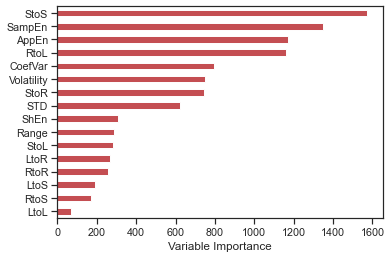

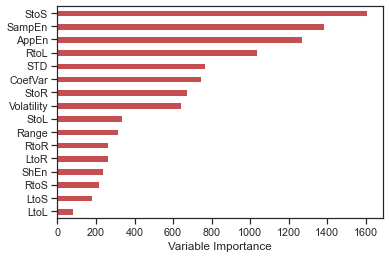

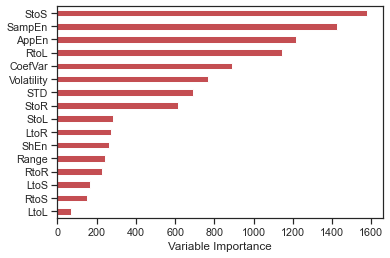

In [9]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
    temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
    param_distributions = {'iterations': randint(105, 110),
                           'depth': randint(7,10)}
    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=search.best_params_['iterations'], learning_rate=0.1, depth=search.best_params_['depth'], loss_function='Logloss')
    model.fit(X_train, y_train)
    
    iterations_list.append(search.best_params_['iterations'])
    max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [11]:
prob = model.predict_proba(df.loc[:100,x_values])
prob

array([[0.02299783, 0.97700217],
       [0.1222193 , 0.8777807 ],
       [0.11476138, 0.88523862],
       [0.1041396 , 0.8958604 ],
       [0.10454267, 0.89545733],
       [0.19655836, 0.80344164],
       [0.12784683, 0.87215317],
       [0.15841762, 0.84158238],
       [0.09126407, 0.90873593],
       [0.43241961, 0.56758039],
       [0.47470499, 0.52529501],
       [0.48516942, 0.51483058],
       [0.99798385, 0.00201615],
       [0.06338436, 0.93661564],
       [0.33524155, 0.66475845],
       [0.7271279 , 0.2728721 ],
       [0.12275226, 0.87724774],
       [0.46095049, 0.53904951],
       [0.24882904, 0.75117096],
       [0.06556445, 0.93443555],
       [0.09657642, 0.90342358],
       [0.25720644, 0.74279356],
       [0.98996479, 0.01003521],
       [0.14435398, 0.85564602],
       [0.03468451, 0.96531549],
       [0.01978846, 0.98021154],
       [0.04286297, 0.95713703],
       [0.06307118, 0.93692882],
       [0.02791608, 0.97208392],
       [0.1943125 , 0.8056875 ],
       [0.

In [17]:
len("Predicted with 44.5% confidence on average.")
"Predicted with 44.5% confidence on average."[:-10:]

'Predicted with 44.5% confidence o'

In [45]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
print(iterations_list)
print(max_depth_list)

temp_list = []
temp_idx = []
for acc in acc_score:
    if acc >= 0.95:
        temp_list.append(acc)
        temp_idx.append(acc_score.index(acc))
for idx in temp_idx:
    print(iterations_list[idx])
    print(max_depth_list[idx])
    
#[[23080  1663]
# [ 1777 18448]]
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9529411764705882, 0.9968513853904282, 0.9256594724220624, 0.9979101358411703, 0.9521298174442191, 0.8075665576833255, 0.9972770592239619, 0.9412650602409639, 0.9691289966923925, 0.9832123411978222, 0.990667623833453, 0.8027210884353742, 0.9668789808917198, 0.541631973355537, 0.9902525476295968, 0.9910897875257025, 0.9838430467397576, 0.7616229923922232, 0.9736118746564046, 0.9970059880239521, 0.9968612680477087, 0.9974630021141649]

# Avg accuracy : 
# 0.9317418944405887

# Std of accuracy : 
# 0.10641487333785117

[[23081  1662]
 [ 1770 18455]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9529411764705882, 0.8066324147594582, 0.9972770592239619, 0.9412650602409639, 0.9696802646085998, 0.9832123411978222, 0.9899497487437185, 0.8022675736961451, 0.967515923566879, 0.5441298917568693, 0.9889233495790872, 0.9910897875257025, 0.9861511829197923, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.997489014438167, 0.9974630021141649]
658.3289397999179
[106, 106, 105, 106, 105, 109, 109, 105, 106, 109, 106, 105, 106, 105, 105, 109, 106, 107, 106, 106, 105, 107, 109]
[9, 9, 9, 9, 9, 8, 8, 9, 8, 8, 9, 9, 9, 8, 9, 8, 9

In [46]:
print(statistics.mode(iterations_list))
print(statistics.mode(max_depth_list))

106
9


In [ ]:
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9529411764705882, 0.8066324147594582, 0.9972770592239619, 0.9412650602409639, 0.9696802646085998, 0.9832123411978222, 0.9899497487437185, 0.8022675736961451, 0.967515923566879, 0.5441298917568693, 0.9889233495790872, 0.9910897875257025, 0.9861511829197923, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9319387052080821

# Std of accuracy : 
# 0.10621247183547902
# [[23081  1662]
#  [ 1770 18455]]

0:	learn: 0.6157812	total: 143ms	remaining: 15s
1:	learn: 0.5533271	total: 151ms	remaining: 7.84s
2:	learn: 0.5015089	total: 158ms	remaining: 5.43s
3:	learn: 0.4567675	total: 166ms	remaining: 4.22s
4:	learn: 0.4169857	total: 173ms	remaining: 3.5s
5:	learn: 0.3829044	total: 181ms	remaining: 3.01s
6:	learn: 0.3533128	total: 188ms	remaining: 2.66s
7:	learn: 0.3276228	total: 196ms	remaining: 2.4s
8:	learn: 0.3056765	total: 203ms	remaining: 2.19s
9:	learn: 0.2860088	total: 210ms	remaining: 2.02s
10:	learn: 0.2684961	total: 218ms	remaining: 1.88s
11:	learn: 0.2526751	total: 225ms	remaining: 1.76s
12:	learn: 0.2384779	total: 232ms	remaining: 1.66s
13:	learn: 0.2263840	total: 239ms	remaining: 1.57s
14:	learn: 0.2155843	total: 246ms	remaining: 1.49s
15:	learn: 0.2055059	total: 253ms	remaining: 1.42s
16:	learn: 0.1969583	total: 260ms	remaining: 1.36s
17:	learn: 0.1885935	total: 267ms	remaining: 1.3s
18:	learn: 0.1814757	total: 274ms	remaining: 1.25s
19:	learn: 0.1750006	total: 281ms	remaining: 1

73:	learn: 0.1055483	total: 593ms	remaining: 257ms
74:	learn: 0.1053893	total: 600ms	remaining: 248ms
75:	learn: 0.1051260	total: 608ms	remaining: 240ms
76:	learn: 0.1047994	total: 615ms	remaining: 232ms
77:	learn: 0.1042296	total: 622ms	remaining: 223ms
78:	learn: 0.1038415	total: 629ms	remaining: 215ms
79:	learn: 0.1036456	total: 636ms	remaining: 207ms
80:	learn: 0.1033345	total: 643ms	remaining: 198ms
81:	learn: 0.1029528	total: 649ms	remaining: 190ms
82:	learn: 0.1025181	total: 656ms	remaining: 182ms
83:	learn: 0.1021664	total: 663ms	remaining: 174ms
84:	learn: 0.1017823	total: 670ms	remaining: 166ms
85:	learn: 0.1014949	total: 677ms	remaining: 157ms
86:	learn: 0.1013282	total: 683ms	remaining: 149ms
87:	learn: 0.1010578	total: 690ms	remaining: 141ms
88:	learn: 0.1009124	total: 696ms	remaining: 133ms
89:	learn: 0.1007862	total: 702ms	remaining: 125ms
90:	learn: 0.1005237	total: 709ms	remaining: 117ms
91:	learn: 0.1003543	total: 715ms	remaining: 109ms
92:	learn: 0.1002591	total: 722

25:	learn: 0.1508088	total: 218ms	remaining: 670ms
26:	learn: 0.1474995	total: 225ms	remaining: 659ms
27:	learn: 0.1448648	total: 232ms	remaining: 646ms
28:	learn: 0.1422746	total: 239ms	remaining: 634ms
29:	learn: 0.1398365	total: 246ms	remaining: 622ms
30:	learn: 0.1372553	total: 253ms	remaining: 611ms
31:	learn: 0.1349692	total: 259ms	remaining: 600ms
32:	learn: 0.1329240	total: 266ms	remaining: 589ms
33:	learn: 0.1310507	total: 273ms	remaining: 578ms
34:	learn: 0.1297664	total: 280ms	remaining: 568ms
35:	learn: 0.1282347	total: 287ms	remaining: 557ms
36:	learn: 0.1268762	total: 294ms	remaining: 548ms
37:	learn: 0.1251955	total: 301ms	remaining: 538ms
38:	learn: 0.1243852	total: 307ms	remaining: 528ms
39:	learn: 0.1233251	total: 314ms	remaining: 518ms
40:	learn: 0.1221466	total: 321ms	remaining: 509ms
41:	learn: 0.1211077	total: 328ms	remaining: 499ms
42:	learn: 0.1202857	total: 334ms	remaining: 490ms
43:	learn: 0.1194803	total: 341ms	remaining: 481ms
44:	learn: 0.1186640	total: 348

102:	learn: 0.1032926	total: 799ms	remaining: 23.3ms
103:	learn: 0.1031524	total: 806ms	remaining: 15.5ms
104:	learn: 0.1027629	total: 813ms	remaining: 7.74ms
105:	learn: 0.1024532	total: 820ms	remaining: 0us
0:	learn: 0.6162132	total: 24.5ms	remaining: 2.57s
1:	learn: 0.5542612	total: 35ms	remaining: 1.82s
2:	learn: 0.5018592	total: 44.2ms	remaining: 1.51s
3:	learn: 0.4568522	total: 55.3ms	remaining: 1.41s
4:	learn: 0.4177779	total: 65.7ms	remaining: 1.33s
5:	learn: 0.3840648	total: 75.9ms	remaining: 1.26s
6:	learn: 0.3549937	total: 86.7ms	remaining: 1.23s
7:	learn: 0.3298870	total: 95.4ms	remaining: 1.17s
8:	learn: 0.3082258	total: 103ms	remaining: 1.11s
9:	learn: 0.2886101	total: 111ms	remaining: 1.06s
10:	learn: 0.2712000	total: 119ms	remaining: 1.02s
11:	learn: 0.2555521	total: 126ms	remaining: 984ms
12:	learn: 0.2420082	total: 133ms	remaining: 954ms
13:	learn: 0.2298561	total: 140ms	remaining: 921ms
14:	learn: 0.2193366	total: 147ms	remaining: 894ms
15:	learn: 0.2091605	total: 15

75:	learn: 0.0943750	total: 573ms	remaining: 226ms
76:	learn: 0.0941764	total: 580ms	remaining: 218ms
77:	learn: 0.0940246	total: 587ms	remaining: 211ms
78:	learn: 0.0938618	total: 594ms	remaining: 203ms
79:	learn: 0.0936994	total: 601ms	remaining: 195ms
80:	learn: 0.0935050	total: 608ms	remaining: 188ms
81:	learn: 0.0931512	total: 616ms	remaining: 180ms
82:	learn: 0.0929137	total: 622ms	remaining: 172ms
83:	learn: 0.0927003	total: 629ms	remaining: 165ms
84:	learn: 0.0923242	total: 636ms	remaining: 157ms
85:	learn: 0.0921589	total: 643ms	remaining: 150ms
86:	learn: 0.0918708	total: 650ms	remaining: 142ms
87:	learn: 0.0915763	total: 657ms	remaining: 134ms
88:	learn: 0.0914275	total: 664ms	remaining: 127ms
89:	learn: 0.0912556	total: 670ms	remaining: 119ms
90:	learn: 0.0908598	total: 677ms	remaining: 112ms
91:	learn: 0.0907343	total: 683ms	remaining: 104ms
92:	learn: 0.0906289	total: 690ms	remaining: 96.5ms
93:	learn: 0.0904261	total: 697ms	remaining: 89ms
94:	learn: 0.0902461	total: 703

25:	learn: 0.1496816	total: 231ms	remaining: 710ms
26:	learn: 0.1460551	total: 238ms	remaining: 696ms
27:	learn: 0.1434474	total: 245ms	remaining: 683ms
28:	learn: 0.1407905	total: 253ms	remaining: 670ms
29:	learn: 0.1384479	total: 259ms	remaining: 657ms
30:	learn: 0.1367158	total: 266ms	remaining: 643ms
31:	learn: 0.1348955	total: 274ms	remaining: 633ms
32:	learn: 0.1328583	total: 281ms	remaining: 621ms
33:	learn: 0.1310808	total: 288ms	remaining: 611ms
34:	learn: 0.1292499	total: 296ms	remaining: 600ms
35:	learn: 0.1278432	total: 304ms	remaining: 592ms
36:	learn: 0.1262756	total: 311ms	remaining: 580ms
37:	learn: 0.1251434	total: 319ms	remaining: 571ms
38:	learn: 0.1237182	total: 326ms	remaining: 560ms
39:	learn: 0.1223390	total: 333ms	remaining: 550ms
40:	learn: 0.1213536	total: 341ms	remaining: 540ms
41:	learn: 0.1199563	total: 348ms	remaining: 530ms
42:	learn: 0.1189167	total: 355ms	remaining: 520ms
43:	learn: 0.1181877	total: 362ms	remaining: 510ms
44:	learn: 0.1171587	total: 369

80:	learn: 0.1058783	total: 654ms	remaining: 202ms
81:	learn: 0.1055152	total: 661ms	remaining: 194ms
82:	learn: 0.1051882	total: 668ms	remaining: 185ms
83:	learn: 0.1048951	total: 676ms	remaining: 177ms
84:	learn: 0.1046670	total: 683ms	remaining: 169ms
85:	learn: 0.1044670	total: 690ms	remaining: 161ms
86:	learn: 0.1043360	total: 697ms	remaining: 152ms
87:	learn: 0.1040284	total: 704ms	remaining: 144ms
88:	learn: 0.1037803	total: 711ms	remaining: 136ms
89:	learn: 0.1036128	total: 717ms	remaining: 128ms
90:	learn: 0.1033965	total: 725ms	remaining: 119ms
91:	learn: 0.1032369	total: 732ms	remaining: 111ms
92:	learn: 0.1029695	total: 739ms	remaining: 103ms
93:	learn: 0.1027802	total: 746ms	remaining: 95.3ms
94:	learn: 0.1025609	total: 754ms	remaining: 87.3ms
95:	learn: 0.1022492	total: 761ms	remaining: 79.2ms
96:	learn: 0.1019596	total: 768ms	remaining: 71.3ms
97:	learn: 0.1018534	total: 775ms	remaining: 63.3ms
98:	learn: 0.1016587	total: 783ms	remaining: 55.3ms
99:	learn: 0.1015375	tota

55:	learn: 0.1171238	total: 409ms	remaining: 365ms
56:	learn: 0.1164412	total: 417ms	remaining: 359ms
57:	learn: 0.1157001	total: 424ms	remaining: 351ms
58:	learn: 0.1151264	total: 431ms	remaining: 343ms
59:	learn: 0.1147429	total: 438ms	remaining: 336ms
60:	learn: 0.1142183	total: 446ms	remaining: 329ms
61:	learn: 0.1136093	total: 453ms	remaining: 322ms
62:	learn: 0.1131736	total: 461ms	remaining: 315ms
63:	learn: 0.1128142	total: 469ms	remaining: 307ms
64:	learn: 0.1125428	total: 476ms	remaining: 300ms
65:	learn: 0.1123038	total: 484ms	remaining: 293ms
66:	learn: 0.1118737	total: 491ms	remaining: 286ms
67:	learn: 0.1114593	total: 500ms	remaining: 279ms
68:	learn: 0.1111683	total: 507ms	remaining: 272ms
69:	learn: 0.1107408	total: 515ms	remaining: 265ms
70:	learn: 0.1103962	total: 522ms	remaining: 257ms
71:	learn: 0.1101512	total: 529ms	remaining: 250ms
72:	learn: 0.1097632	total: 537ms	remaining: 243ms
73:	learn: 0.1094035	total: 544ms	remaining: 235ms
74:	learn: 0.1090816	total: 552

28:	learn: 0.1463297	total: 204ms	remaining: 542ms
29:	learn: 0.1440038	total: 211ms	remaining: 536ms
30:	learn: 0.1419965	total: 219ms	remaining: 529ms
31:	learn: 0.1397806	total: 226ms	remaining: 522ms
32:	learn: 0.1376701	total: 232ms	remaining: 514ms
33:	learn: 0.1357507	total: 239ms	remaining: 506ms
34:	learn: 0.1342845	total: 246ms	remaining: 499ms
35:	learn: 0.1326247	total: 253ms	remaining: 491ms
36:	learn: 0.1311400	total: 259ms	remaining: 483ms
37:	learn: 0.1300043	total: 266ms	remaining: 475ms
38:	learn: 0.1288776	total: 272ms	remaining: 468ms
39:	learn: 0.1277218	total: 279ms	remaining: 460ms
40:	learn: 0.1265610	total: 285ms	remaining: 452ms
41:	learn: 0.1254336	total: 292ms	remaining: 445ms
42:	learn: 0.1244111	total: 299ms	remaining: 438ms
43:	learn: 0.1237030	total: 306ms	remaining: 431ms
44:	learn: 0.1230068	total: 312ms	remaining: 423ms
45:	learn: 0.1221641	total: 320ms	remaining: 417ms
46:	learn: 0.1212208	total: 327ms	remaining: 410ms
47:	learn: 0.1203486	total: 335

96:	learn: 0.0867399	total: 744ms	remaining: 69ms
97:	learn: 0.0865236	total: 753ms	remaining: 61.4ms
98:	learn: 0.0862920	total: 760ms	remaining: 53.7ms
99:	learn: 0.0861864	total: 767ms	remaining: 46ms
100:	learn: 0.0860469	total: 774ms	remaining: 38.3ms
101:	learn: 0.0857302	total: 782ms	remaining: 30.7ms
102:	learn: 0.0855357	total: 789ms	remaining: 23ms
103:	learn: 0.0854207	total: 796ms	remaining: 15.3ms
104:	learn: 0.0852351	total: 804ms	remaining: 7.66ms
105:	learn: 0.0850354	total: 811ms	remaining: 0us
0:	learn: 0.6164968	total: 9.31ms	remaining: 978ms
1:	learn: 0.5548732	total: 18.5ms	remaining: 964ms
2:	learn: 0.5027490	total: 26.4ms	remaining: 906ms
3:	learn: 0.4578701	total: 35.7ms	remaining: 911ms
4:	learn: 0.4193568	total: 43.2ms	remaining: 872ms
5:	learn: 0.3857198	total: 52.1ms	remaining: 868ms
6:	learn: 0.3574984	total: 59.5ms	remaining: 842ms
7:	learn: 0.3323083	total: 68.2ms	remaining: 835ms
8:	learn: 0.3102322	total: 75.5ms	remaining: 814ms
9:	learn: 0.2909135	tota

53:	learn: 0.1174008	total: 445ms	remaining: 428ms
54:	learn: 0.1168466	total: 453ms	remaining: 420ms
55:	learn: 0.1160403	total: 461ms	remaining: 411ms
56:	learn: 0.1157402	total: 468ms	remaining: 403ms
57:	learn: 0.1153562	total: 477ms	remaining: 394ms
58:	learn: 0.1149954	total: 483ms	remaining: 385ms
59:	learn: 0.1143425	total: 491ms	remaining: 376ms
60:	learn: 0.1136532	total: 498ms	remaining: 367ms
61:	learn: 0.1132693	total: 505ms	remaining: 358ms
62:	learn: 0.1129425	total: 511ms	remaining: 349ms
63:	learn: 0.1124733	total: 518ms	remaining: 340ms
64:	learn: 0.1121266	total: 525ms	remaining: 331ms
65:	learn: 0.1117654	total: 532ms	remaining: 322ms
66:	learn: 0.1113213	total: 539ms	remaining: 314ms
67:	learn: 0.1110201	total: 546ms	remaining: 305ms
68:	learn: 0.1106029	total: 554ms	remaining: 297ms
69:	learn: 0.1101025	total: 561ms	remaining: 289ms
70:	learn: 0.1097300	total: 569ms	remaining: 280ms
71:	learn: 0.1094644	total: 577ms	remaining: 272ms
72:	learn: 0.1089621	total: 585

4:	learn: 0.4084928	total: 65.5ms	remaining: 1.32s
5:	learn: 0.3734877	total: 74.5ms	remaining: 1.24s
6:	learn: 0.3443027	total: 82.3ms	remaining: 1.16s
7:	learn: 0.3184229	total: 91.2ms	remaining: 1.12s
8:	learn: 0.2960921	total: 96ms	remaining: 1.03s
9:	learn: 0.2760898	total: 103ms	remaining: 990ms
10:	learn: 0.2586004	total: 110ms	remaining: 952ms
11:	learn: 0.2423306	total: 118ms	remaining: 921ms
12:	learn: 0.2283761	total: 126ms	remaining: 904ms
13:	learn: 0.2164290	total: 133ms	remaining: 875ms
14:	learn: 0.2052188	total: 140ms	remaining: 850ms
15:	learn: 0.1949444	total: 147ms	remaining: 827ms
16:	learn: 0.1856935	total: 154ms	remaining: 807ms
17:	learn: 0.1775329	total: 161ms	remaining: 787ms
18:	learn: 0.1706638	total: 168ms	remaining: 769ms
19:	learn: 0.1645468	total: 175ms	remaining: 751ms
20:	learn: 0.1584539	total: 182ms	remaining: 735ms
21:	learn: 0.1533203	total: 188ms	remaining: 719ms
22:	learn: 0.1484899	total: 195ms	remaining: 705ms
23:	learn: 0.1440232	total: 202ms	

78:	learn: 0.1062536	total: 600ms	remaining: 205ms
79:	learn: 0.1060642	total: 607ms	remaining: 197ms
80:	learn: 0.1056969	total: 614ms	remaining: 189ms
81:	learn: 0.1051918	total: 621ms	remaining: 182ms
82:	learn: 0.1048704	total: 628ms	remaining: 174ms
83:	learn: 0.1045022	total: 635ms	remaining: 166ms
84:	learn: 0.1042320	total: 641ms	remaining: 158ms
85:	learn: 0.1040013	total: 648ms	remaining: 151ms
86:	learn: 0.1038017	total: 654ms	remaining: 143ms
87:	learn: 0.1034857	total: 661ms	remaining: 135ms
88:	learn: 0.1033735	total: 667ms	remaining: 127ms
89:	learn: 0.1032408	total: 674ms	remaining: 120ms
90:	learn: 0.1030763	total: 680ms	remaining: 112ms
91:	learn: 0.1026861	total: 687ms	remaining: 105ms
92:	learn: 0.1023996	total: 694ms	remaining: 97ms
93:	learn: 0.1021965	total: 701ms	remaining: 89.4ms
94:	learn: 0.1020311	total: 707ms	remaining: 81.9ms
95:	learn: 0.1018520	total: 714ms	remaining: 74.4ms
96:	learn: 0.1015222	total: 721ms	remaining: 66.9ms
97:	learn: 0.1012802	total: 

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0:	learn: 0.6168041	total: 72.8ms	remaining: 7.65s
1:	learn: 0.5552329	total: 87.4ms	remaining: 4.55s
2:	learn: 0.5042204	total: 97.8ms	remaining: 3.36s
3:	learn: 0.4599971	total: 107ms	remaining: 2.73s
4:	learn: 0.4216227	total: 115ms	remaining: 2.32s
5:	learn: 0.3877945	total: 123ms	remaining: 2.05s
6:	learn: 0.3591494	total: 130ms	remaining: 1.84s
7:	learn: 0.3338692	total: 138ms	remaining: 1.69s
8:	learn: 0.3123454	total: 146ms	remaining: 1.57s
9:	learn: 0.2926079	total: 154ms	remaining: 1.48s
10:	learn: 0.2764110	total: 161ms	remaining: 1.39s
11:	learn: 0.2606406	total: 168ms	remaining: 1.32s
12:	learn: 0.2465400	total: 175ms	remaining: 1.25s
13:	learn: 0.2343899	total: 182ms	remaining: 1.2s
14:	learn: 0.2235759	total: 189ms	remaining: 1.15s
15:	learn: 0.2139430	total: 197ms	remaining: 1.1s
16:	learn: 0.2053858	total: 204ms	remaining: 1.07s
17:	learn: 0.1970029	total: 211ms	remaining: 1.03s
18:	learn: 0.1904549	total: 218ms	remaining: 996ms
19:	learn: 0.1840986	total: 225ms	remain

75:	learn: 0.1104199	total: 591ms	remaining: 233ms
76:	learn: 0.1100121	total: 598ms	remaining: 225ms
77:	learn: 0.1096133	total: 606ms	remaining: 217ms
78:	learn: 0.1092321	total: 613ms	remaining: 210ms
79:	learn: 0.1089453	total: 620ms	remaining: 201ms
80:	learn: 0.1086857	total: 627ms	remaining: 193ms
81:	learn: 0.1082551	total: 633ms	remaining: 185ms
82:	learn: 0.1080239	total: 640ms	remaining: 177ms
83:	learn: 0.1078945	total: 646ms	remaining: 169ms
84:	learn: 0.1076302	total: 653ms	remaining: 161ms
85:	learn: 0.1073518	total: 660ms	remaining: 153ms
86:	learn: 0.1071813	total: 666ms	remaining: 146ms
87:	learn: 0.1067960	total: 674ms	remaining: 138ms
88:	learn: 0.1066360	total: 681ms	remaining: 130ms
89:	learn: 0.1064726	total: 688ms	remaining: 122ms
90:	learn: 0.1062603	total: 695ms	remaining: 115ms
91:	learn: 0.1061308	total: 702ms	remaining: 107ms
92:	learn: 0.1057034	total: 709ms	remaining: 99.2ms
93:	learn: 0.1054286	total: 718ms	remaining: 91.7ms
94:	learn: 0.1052668	total: 7

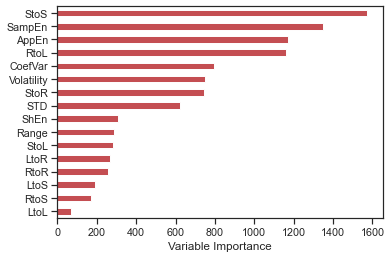

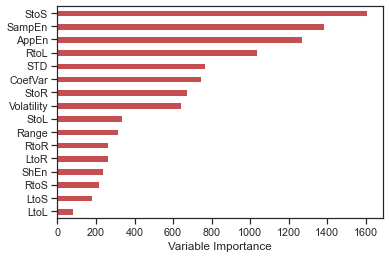

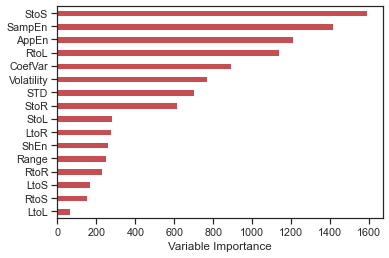

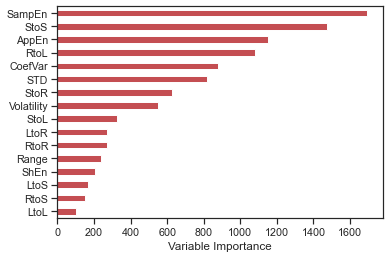

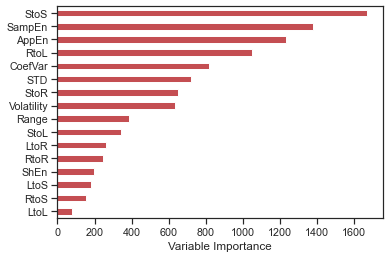

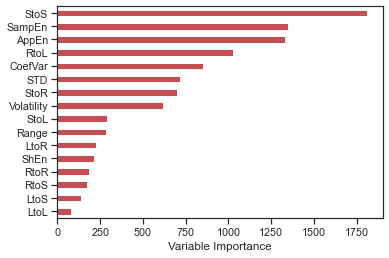

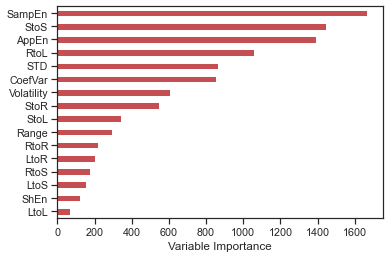

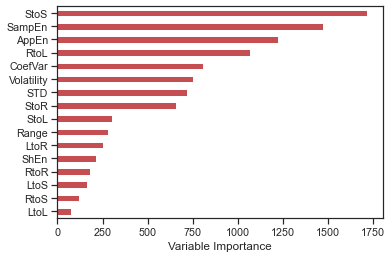

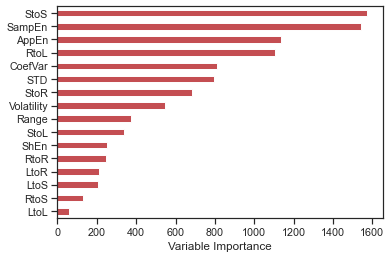

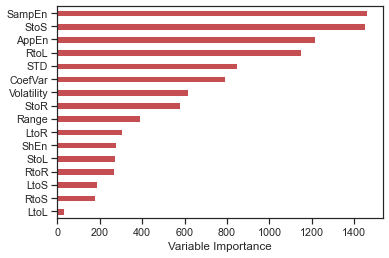

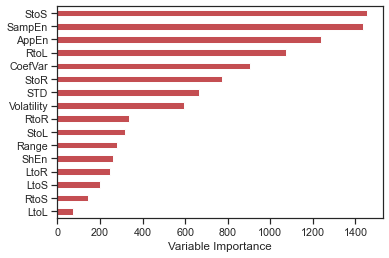

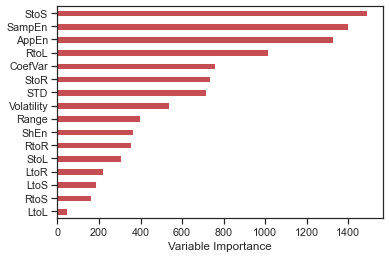

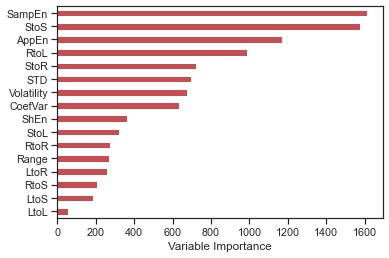

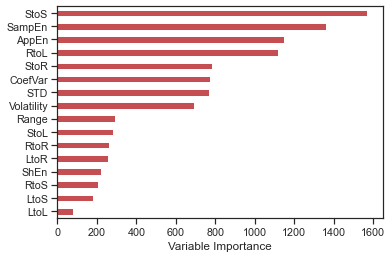

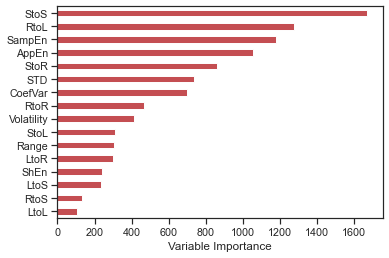

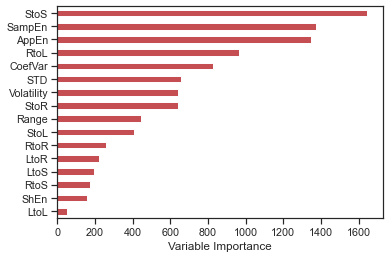

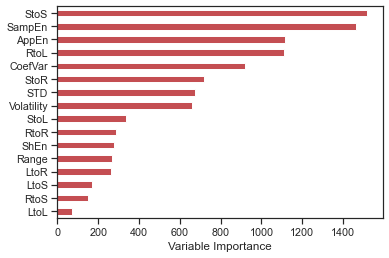

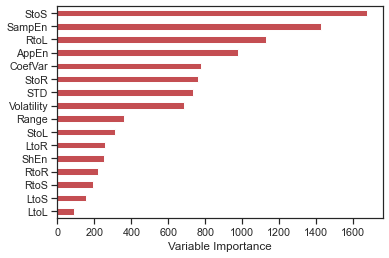

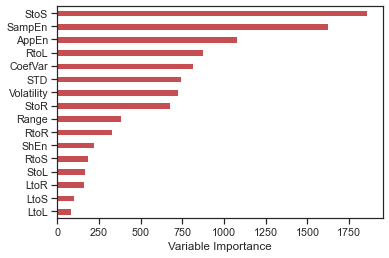

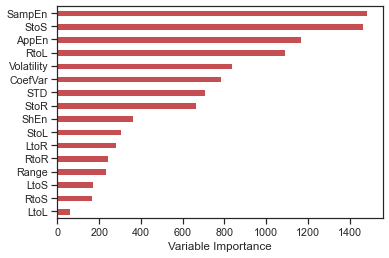

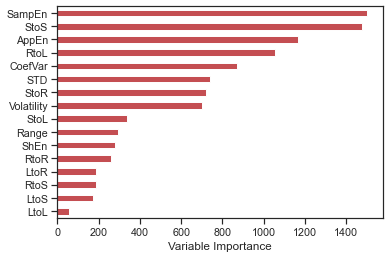

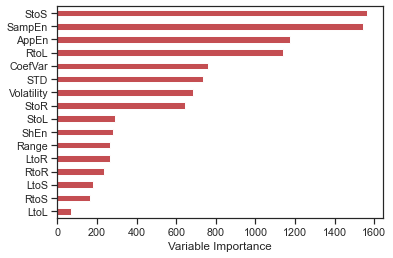

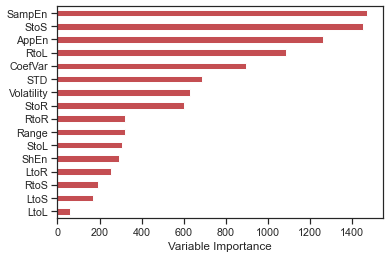

In [9]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
#     temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
#     param_distributions = {'iterations': randint(105, 110),
#                            'depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=106, learning_rate=0.1, depth=9, loss_function='Logloss')
    model.fit(X_train, y_train)
    
#     iterations_list.append(search.best_params_['iterations'])
#     max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [10]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
# [[23080  1663]
#  [ 1757 18468]]
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9525354969574037, 0.8155067725361981, 0.9972770592239619, 0.9397590361445783, 0.9707828004410143, 0.9832123411978222, 0.990667623833453, 0.8022675736961451, 0.967515923566879, 0.5420482930890924, 0.9902525476295968, 0.9910897875257025, 0.9849971148297749, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.9968612680477087, 0.9970401691331924]

# Avg accuracy : 
# 0.9321920102954995

# Std of accuracy : 
# 0.10610803049760552

[[23080  1663]
 [ 1757 18468]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.92     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9525354969574037, 0.8155067725361981, 0.9972770592239619, 0.9397590361445783, 0.9707828004410143, 0.9832123411978222, 0.990667623833453, 0.8022675736961451, 0.967515923566879, 0.5420482930890924, 0.9902525476295968, 0.9910897875257025, 0.9849971148297749, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.9968612680477087, 0.9970401691331924]
21.379119999997783


0:	learn: 0.6173012	total: 157ms	remaining: 15.6s
1:	learn: 0.5550178	total: 160ms	remaining: 7.83s
2:	learn: 0.5038201	total: 162ms	remaining: 5.25s
3:	learn: 0.4590089	total: 165ms	remaining: 3.96s
4:	learn: 0.4217088	total: 167ms	remaining: 3.18s
5:	learn: 0.3889888	total: 170ms	remaining: 2.66s
6:	learn: 0.3602172	total: 172ms	remaining: 2.29s
7:	learn: 0.3355493	total: 175ms	remaining: 2.01s
8:	learn: 0.3139150	total: 177ms	remaining: 1.79s
9:	learn: 0.2956375	total: 179ms	remaining: 1.61s
10:	learn: 0.2790435	total: 182ms	remaining: 1.47s
11:	learn: 0.2640873	total: 184ms	remaining: 1.35s
12:	learn: 0.2499926	total: 186ms	remaining: 1.25s
13:	learn: 0.2375672	total: 189ms	remaining: 1.16s
14:	learn: 0.2272318	total: 191ms	remaining: 1.08s
15:	learn: 0.2174500	total: 193ms	remaining: 1.01s
16:	learn: 0.2088242	total: 196ms	remaining: 955ms
17:	learn: 0.2012978	total: 198ms	remaining: 901ms
18:	learn: 0.1943584	total: 200ms	remaining: 853ms
19:	learn: 0.1879611	total: 202ms	remaini

78:	learn: 0.1179899	total: 177ms	remaining: 47.1ms
79:	learn: 0.1175785	total: 180ms	remaining: 44.9ms
80:	learn: 0.1174311	total: 182ms	remaining: 42.7ms
81:	learn: 0.1170987	total: 185ms	remaining: 40.5ms
82:	learn: 0.1169646	total: 187ms	remaining: 38.3ms
83:	learn: 0.1166771	total: 190ms	remaining: 36.1ms
84:	learn: 0.1163697	total: 192ms	remaining: 33.9ms
85:	learn: 0.1160093	total: 195ms	remaining: 31.7ms
86:	learn: 0.1159373	total: 197ms	remaining: 29.4ms
87:	learn: 0.1157220	total: 199ms	remaining: 27.1ms
88:	learn: 0.1155328	total: 202ms	remaining: 24.9ms
89:	learn: 0.1152526	total: 205ms	remaining: 22.8ms
90:	learn: 0.1150453	total: 207ms	remaining: 20.5ms
91:	learn: 0.1148138	total: 209ms	remaining: 18.2ms
92:	learn: 0.1146219	total: 211ms	remaining: 15.9ms
93:	learn: 0.1144339	total: 214ms	remaining: 13.6ms
94:	learn: 0.1142215	total: 216ms	remaining: 11.4ms
95:	learn: 0.1140941	total: 218ms	remaining: 9.1ms
96:	learn: 0.1137854	total: 221ms	remaining: 6.84ms
97:	learn: 0.

63:	learn: 0.1211633	total: 220ms	remaining: 124ms
64:	learn: 0.1209110	total: 223ms	remaining: 120ms
65:	learn: 0.1203782	total: 226ms	remaining: 117ms
66:	learn: 0.1197984	total: 229ms	remaining: 113ms
67:	learn: 0.1194272	total: 232ms	remaining: 109ms
68:	learn: 0.1191497	total: 235ms	remaining: 106ms
69:	learn: 0.1189737	total: 238ms	remaining: 102ms
70:	learn: 0.1184724	total: 241ms	remaining: 98.3ms
71:	learn: 0.1181449	total: 243ms	remaining: 94.5ms
72:	learn: 0.1177975	total: 245ms	remaining: 90.8ms
73:	learn: 0.1172969	total: 248ms	remaining: 87.1ms
74:	learn: 0.1170445	total: 250ms	remaining: 83.4ms
75:	learn: 0.1168414	total: 253ms	remaining: 79.8ms
76:	learn: 0.1166853	total: 255ms	remaining: 76.1ms
77:	learn: 0.1163809	total: 257ms	remaining: 72.6ms
78:	learn: 0.1162835	total: 260ms	remaining: 69ms
79:	learn: 0.1161918	total: 262ms	remaining: 65.5ms
80:	learn: 0.1160460	total: 264ms	remaining: 62ms
81:	learn: 0.1159149	total: 266ms	remaining: 58.5ms
82:	learn: 0.1158000	to

77:	learn: 0.1188340	total: 180ms	remaining: 50.8ms
78:	learn: 0.1185566	total: 182ms	remaining: 48.5ms
79:	learn: 0.1181811	total: 185ms	remaining: 46.2ms
80:	learn: 0.1179969	total: 187ms	remaining: 43.9ms
81:	learn: 0.1177205	total: 189ms	remaining: 41.6ms
82:	learn: 0.1175533	total: 192ms	remaining: 39.2ms
83:	learn: 0.1172342	total: 194ms	remaining: 36.9ms
84:	learn: 0.1169148	total: 196ms	remaining: 34.6ms
85:	learn: 0.1164826	total: 198ms	remaining: 32.3ms
86:	learn: 0.1164132	total: 200ms	remaining: 29.9ms
87:	learn: 0.1162806	total: 202ms	remaining: 27.6ms
88:	learn: 0.1161113	total: 205ms	remaining: 25.3ms
89:	learn: 0.1158985	total: 207ms	remaining: 23ms
90:	learn: 0.1158126	total: 209ms	remaining: 20.6ms
91:	learn: 0.1156517	total: 211ms	remaining: 18.3ms
92:	learn: 0.1154705	total: 213ms	remaining: 16ms
93:	learn: 0.1151846	total: 215ms	remaining: 13.7ms
94:	learn: 0.1150320	total: 217ms	remaining: 11.4ms
95:	learn: 0.1149032	total: 219ms	remaining: 9.14ms
96:	learn: 0.114

57:	learn: 0.1298806	total: 237ms	remaining: 171ms
58:	learn: 0.1293880	total: 239ms	remaining: 166ms
59:	learn: 0.1289146	total: 242ms	remaining: 161ms
60:	learn: 0.1286625	total: 244ms	remaining: 156ms
61:	learn: 0.1283012	total: 246ms	remaining: 151ms
62:	learn: 0.1275470	total: 248ms	remaining: 146ms
63:	learn: 0.1271248	total: 251ms	remaining: 141ms
64:	learn: 0.1267646	total: 254ms	remaining: 137ms
65:	learn: 0.1264778	total: 256ms	remaining: 132ms
66:	learn: 0.1259389	total: 258ms	remaining: 127ms
67:	learn: 0.1255851	total: 261ms	remaining: 123ms
68:	learn: 0.1251914	total: 263ms	remaining: 118ms
69:	learn: 0.1249939	total: 265ms	remaining: 114ms
70:	learn: 0.1244030	total: 267ms	remaining: 109ms
71:	learn: 0.1240939	total: 269ms	remaining: 105ms
72:	learn: 0.1235556	total: 272ms	remaining: 101ms
73:	learn: 0.1230815	total: 274ms	remaining: 96.3ms
74:	learn: 0.1228069	total: 276ms	remaining: 92.1ms
75:	learn: 0.1226447	total: 279ms	remaining: 88ms
76:	learn: 0.1223732	total: 28

78:	learn: 0.1204362	total: 208ms	remaining: 55.4ms
79:	learn: 0.1201962	total: 211ms	remaining: 52.6ms
80:	learn: 0.1200689	total: 213ms	remaining: 49.9ms
81:	learn: 0.1198492	total: 215ms	remaining: 47.2ms
82:	learn: 0.1194038	total: 218ms	remaining: 44.6ms
83:	learn: 0.1192108	total: 220ms	remaining: 41.8ms
84:	learn: 0.1188761	total: 222ms	remaining: 39.2ms
85:	learn: 0.1185176	total: 224ms	remaining: 36.5ms
86:	learn: 0.1183487	total: 226ms	remaining: 33.8ms
87:	learn: 0.1182887	total: 228ms	remaining: 31.1ms
88:	learn: 0.1180617	total: 231ms	remaining: 28.5ms
89:	learn: 0.1178610	total: 233ms	remaining: 25.9ms
90:	learn: 0.1177720	total: 235ms	remaining: 23.2ms
91:	learn: 0.1177070	total: 237ms	remaining: 20.6ms
92:	learn: 0.1172942	total: 239ms	remaining: 18ms
93:	learn: 0.1169906	total: 241ms	remaining: 15.4ms
94:	learn: 0.1167469	total: 243ms	remaining: 12.8ms
95:	learn: 0.1166149	total: 246ms	remaining: 10.2ms
96:	learn: 0.1165044	total: 248ms	remaining: 7.66ms
97:	learn: 0.1

69:	learn: 0.1241065	total: 242ms	remaining: 104ms
70:	learn: 0.1236860	total: 245ms	remaining: 99.9ms
71:	learn: 0.1233807	total: 247ms	remaining: 95.9ms
72:	learn: 0.1231060	total: 249ms	remaining: 92.1ms
73:	learn: 0.1229539	total: 252ms	remaining: 88.4ms
74:	learn: 0.1226871	total: 254ms	remaining: 84.6ms
75:	learn: 0.1225115	total: 256ms	remaining: 80.8ms
76:	learn: 0.1222476	total: 258ms	remaining: 77.2ms
77:	learn: 0.1218042	total: 261ms	remaining: 73.6ms
78:	learn: 0.1216847	total: 263ms	remaining: 70ms
79:	learn: 0.1215369	total: 266ms	remaining: 66.4ms
80:	learn: 0.1214060	total: 268ms	remaining: 62.9ms
81:	learn: 0.1210046	total: 271ms	remaining: 59.4ms
82:	learn: 0.1207397	total: 273ms	remaining: 55.9ms
83:	learn: 0.1204599	total: 275ms	remaining: 52.5ms
84:	learn: 0.1202397	total: 278ms	remaining: 49ms
85:	learn: 0.1198246	total: 280ms	remaining: 45.6ms
86:	learn: 0.1197151	total: 282ms	remaining: 42.1ms
87:	learn: 0.1196084	total: 284ms	remaining: 38.7ms
88:	learn: 0.1193

31:	learn: 0.1541521	total: 86.5ms	remaining: 184ms
32:	learn: 0.1525536	total: 88.7ms	remaining: 180ms
33:	learn: 0.1506416	total: 91.2ms	remaining: 177ms
34:	learn: 0.1490651	total: 93.8ms	remaining: 174ms
35:	learn: 0.1471950	total: 96.3ms	remaining: 171ms
36:	learn: 0.1455975	total: 98.9ms	remaining: 168ms
37:	learn: 0.1443942	total: 101ms	remaining: 165ms
38:	learn: 0.1430333	total: 103ms	remaining: 162ms
39:	learn: 0.1418112	total: 106ms	remaining: 159ms
40:	learn: 0.1407805	total: 108ms	remaining: 155ms
41:	learn: 0.1399589	total: 110ms	remaining: 152ms
42:	learn: 0.1390078	total: 112ms	remaining: 149ms
43:	learn: 0.1380179	total: 114ms	remaining: 146ms
44:	learn: 0.1369341	total: 117ms	remaining: 143ms
45:	learn: 0.1360162	total: 119ms	remaining: 140ms
46:	learn: 0.1353169	total: 121ms	remaining: 137ms
47:	learn: 0.1344909	total: 123ms	remaining: 134ms
48:	learn: 0.1336575	total: 126ms	remaining: 131ms
49:	learn: 0.1328612	total: 128ms	remaining: 128ms
50:	learn: 0.1321240	tota

0:	learn: 0.6180996	total: 3.23ms	remaining: 320ms
1:	learn: 0.5565835	total: 6.27ms	remaining: 307ms
2:	learn: 0.5065665	total: 9.12ms	remaining: 295ms
3:	learn: 0.4623403	total: 11.7ms	remaining: 280ms
4:	learn: 0.4241234	total: 14.2ms	remaining: 270ms
5:	learn: 0.3916763	total: 17ms	remaining: 266ms
6:	learn: 0.3635753	total: 19.7ms	remaining: 261ms
7:	learn: 0.3393148	total: 22.4ms	remaining: 258ms
8:	learn: 0.3191378	total: 24.9ms	remaining: 252ms
9:	learn: 0.3005873	total: 27.5ms	remaining: 248ms
10:	learn: 0.2843652	total: 30.2ms	remaining: 245ms
11:	learn: 0.2696763	total: 32.8ms	remaining: 241ms
12:	learn: 0.2564933	total: 35.4ms	remaining: 237ms
13:	learn: 0.2448977	total: 38.1ms	remaining: 234ms
14:	learn: 0.2341568	total: 41ms	remaining: 232ms
15:	learn: 0.2242259	total: 43.8ms	remaining: 230ms
16:	learn: 0.2157736	total: 46.5ms	remaining: 227ms
17:	learn: 0.2084348	total: 49.3ms	remaining: 224ms
18:	learn: 0.2017654	total: 51.9ms	remaining: 221ms
19:	learn: 0.1959056	total

73:	learn: 0.1222598	total: 197ms	remaining: 69.1ms
74:	learn: 0.1220187	total: 199ms	remaining: 66.3ms
75:	learn: 0.1216691	total: 201ms	remaining: 63.6ms
76:	learn: 0.1214284	total: 204ms	remaining: 60.9ms
77:	learn: 0.1211416	total: 206ms	remaining: 58.2ms
78:	learn: 0.1210257	total: 209ms	remaining: 55.5ms
79:	learn: 0.1206750	total: 211ms	remaining: 52.8ms
80:	learn: 0.1205297	total: 214ms	remaining: 50.1ms
81:	learn: 0.1201157	total: 216ms	remaining: 47.5ms
82:	learn: 0.1199617	total: 219ms	remaining: 44.8ms
83:	learn: 0.1196783	total: 221ms	remaining: 42.1ms
84:	learn: 0.1193519	total: 223ms	remaining: 39.4ms
85:	learn: 0.1189689	total: 226ms	remaining: 36.7ms
86:	learn: 0.1188655	total: 228ms	remaining: 34ms
87:	learn: 0.1186860	total: 230ms	remaining: 31.4ms
88:	learn: 0.1185466	total: 232ms	remaining: 28.7ms
89:	learn: 0.1183557	total: 235ms	remaining: 26.1ms
90:	learn: 0.1182192	total: 237ms	remaining: 23.4ms
91:	learn: 0.1181310	total: 239ms	remaining: 20.8ms
92:	learn: 0.1

75:	learn: 0.1032627	total: 265ms	remaining: 83.8ms
76:	learn: 0.1029900	total: 268ms	remaining: 79.9ms
77:	learn: 0.1026302	total: 270ms	remaining: 76.2ms
78:	learn: 0.1023657	total: 273ms	remaining: 72.5ms
79:	learn: 0.1020748	total: 275ms	remaining: 68.8ms
80:	learn: 0.1019409	total: 278ms	remaining: 65.1ms
81:	learn: 0.1015783	total: 280ms	remaining: 61.5ms
82:	learn: 0.1013465	total: 282ms	remaining: 57.8ms
83:	learn: 0.1010681	total: 285ms	remaining: 54.3ms
84:	learn: 0.1008474	total: 287ms	remaining: 50.7ms
85:	learn: 0.1005205	total: 290ms	remaining: 47.1ms
86:	learn: 0.1004446	total: 292ms	remaining: 43.6ms
87:	learn: 0.1002975	total: 294ms	remaining: 40.1ms
88:	learn: 0.1000740	total: 296ms	remaining: 36.6ms
89:	learn: 0.0996978	total: 299ms	remaining: 33.2ms
90:	learn: 0.0995370	total: 301ms	remaining: 29.7ms
91:	learn: 0.0993245	total: 303ms	remaining: 26.3ms
92:	learn: 0.0991400	total: 305ms	remaining: 23ms
93:	learn: 0.0988387	total: 307ms	remaining: 19.6ms
94:	learn: 0.0

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0:	learn: 0.6183193	total: 6.55ms	remaining: 648ms
1:	learn: 0.5570182	total: 9.24ms	remaining: 453ms
2:	learn: 0.5061584	total: 11.8ms	remaining: 380ms
3:	learn: 0.4618096	total: 14.1ms	remaining: 339ms
4:	learn: 0.4243914	total: 16.6ms	remaining: 316ms
5:	learn: 0.3927389	total: 19ms	remaining: 298ms
6:	learn: 0.3644063	total: 21.4ms	remaining: 284ms
7:	learn: 0.3399769	total: 24.1ms	remaining: 277ms
8:	learn: 0.3191549	total: 26.5ms	remaining: 268ms
9:	learn: 0.3006234	total: 29ms	remaining: 261ms
10:	learn: 0.2847795	total: 31.6ms	remaining: 256ms
11:	learn: 0.2699538	total: 34.1ms	remaining: 250ms
12:	learn: 0.2562132	total: 36.8ms	remaining: 246ms
13:	learn: 0.2441835	total: 39.6ms	remaining: 243ms
14:	learn: 0.2344091	total: 42ms	remaining: 238ms
15:	learn: 0.2248623	total: 44.6ms	remaining: 234ms
16:	learn: 0.2163982	total: 47.1ms	remaining: 230ms
17:	learn: 0.2090027	total: 49.7ms	remaining: 227ms
18:	learn: 0.2020756	total: 52ms	remaining: 222ms
19:	learn: 0.1960880	total: 54

93:	learn: 0.1195991	total: 244ms	remaining: 15.6ms
94:	learn: 0.1193871	total: 247ms	remaining: 13ms
95:	learn: 0.1191078	total: 249ms	remaining: 10.4ms
96:	learn: 0.1187253	total: 252ms	remaining: 7.8ms
97:	learn: 0.1185626	total: 255ms	remaining: 5.2ms
98:	learn: 0.1182594	total: 257ms	remaining: 2.6ms
99:	learn: 0.1181014	total: 260ms	remaining: 0us
---Run time is 8.892542999994475 seconds ---

Accuracy of each fold: 
 [0.9107551487414187, 0.9557809330628804, 0.9962216624685138, 0.9370503597122302, 0.9973876698014629, 0.9484787018255578, 0.8243811303129379, 0.9972770592239619, 0.9437751004016064, 0.9707828004410143, 0.9841197822141561, 0.9885139985642498, 0.7868480725623582, 0.9707006369426752, 0.5203996669442131, 0.9915817456801064, 0.9910897875257025, 0.9861511829197923, 0.7430262045646661, 0.9747113798790544, 0.9965782720273738, 0.9968612680477087, 0.9970401691331924]

Avg accuracy : 
0.9308483796955145

Std of accuracy : 
0.11135096999367239


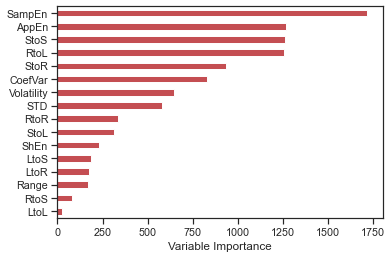

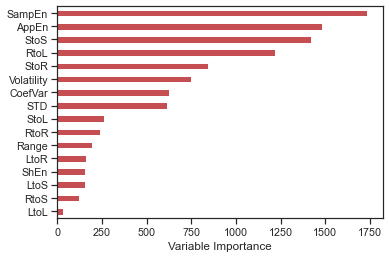

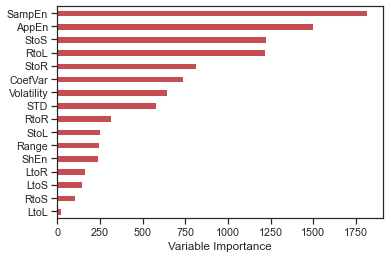

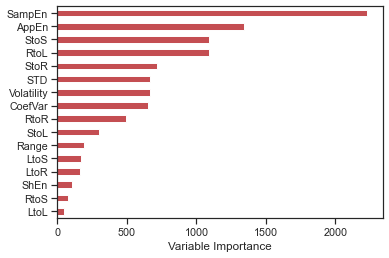

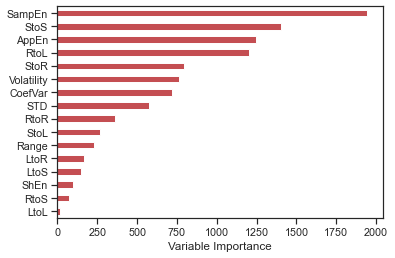

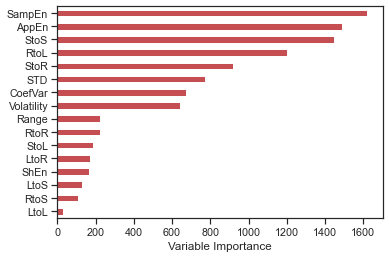

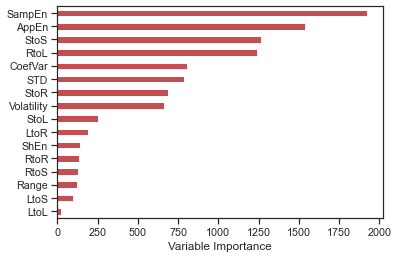

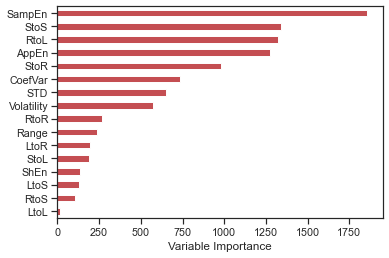

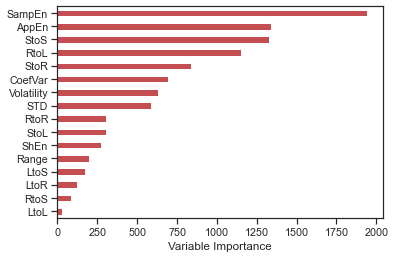

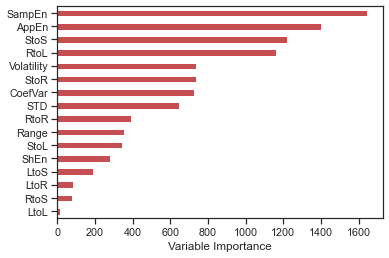

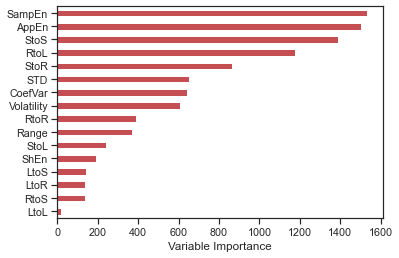

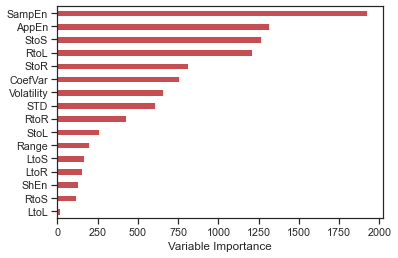

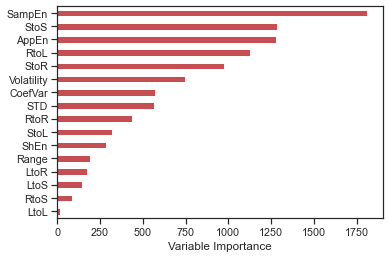

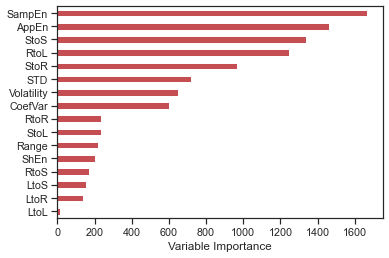

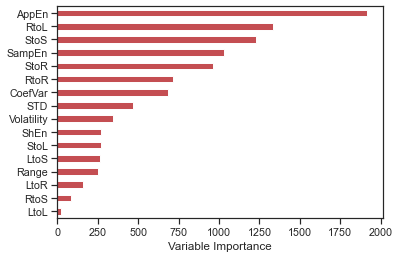

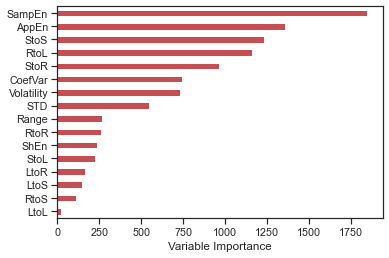

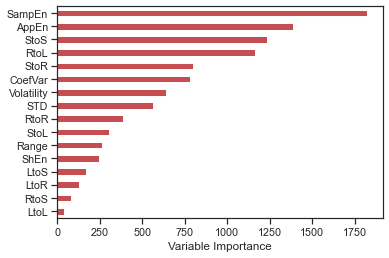

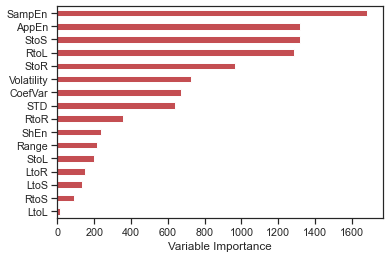

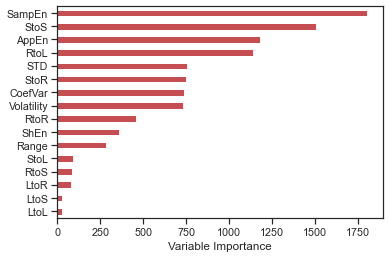

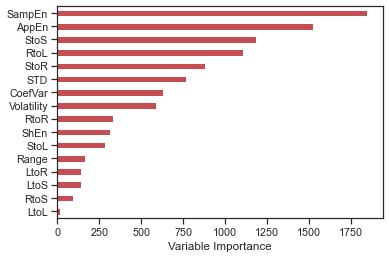

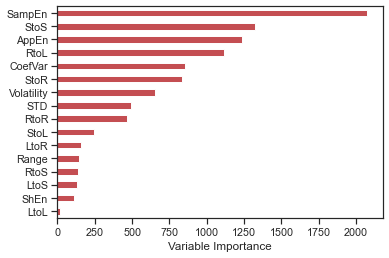

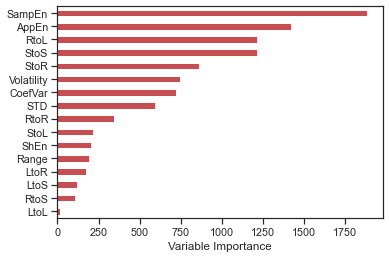

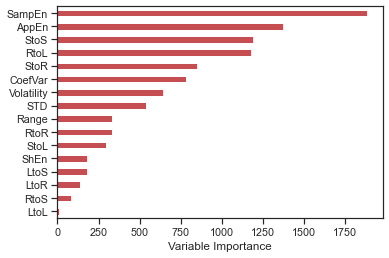

In [10]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
#     temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
#     param_distributions = {'iterations': randint(105, 110),
#                            'depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)


    model = CatBoostClassifier(learning_rate=0.1, iterations=100, depth=5, loss_function='Logloss')
    model.fit(X_train, y_train)
    
#     iterations_list.append(search.best_params_['iterations'])
#     max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [12]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

[[23166  1577]
 [ 1692 18533]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     24743
           1       0.92      0.92      0.92     20225

    accuracy                           0.93     44968
   macro avg       0.93      0.93      0.93     44968
weighted avg       0.93      0.93      0.93     44968

[0.914187643020595, 0.9578093306288032, 0.9949622166246851, 0.9310551558752997, 0.9968652037617555, 0.9594320486815415, 0.7585240541802896, 0.998638529611981, 0.9397590361445783, 0.9735391400220507, 0.9818511796733213, 0.990667623833453, 0.8476190476190476, 0.954140127388535, 0.6232306411323897, 0.9902525476295968, 0.9897189856065799, 0.9849971148297749, 0.7497886728655959, 0.9686641011544805, 0.9957228400342173, 0.9981167608286252, 0.9966173361522199]
100.3481230000034
